In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

Using TensorFlow backend.


## Data Visualization and Preprocessing

In [2]:
base_text_dir = "/home/kabilan/Desktop/caption/dataset/texts/"
image_tokens=pd.read_csv(base_text_dir+'Flickr8k.lemma.token.txt',sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv(base_text_dir+"Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv(base_text_dir+"Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv(base_text_dir+"Flickr_8k.devImages.txt",names=["img_id"])

In [3]:
base_img_dir="/home/kabilan/Desktop/caption/dataset/images/"
path=base_img_dir

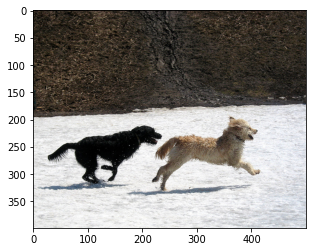

In [4]:
img=cv2.imread(base_img_dir+train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));

In [5]:
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [6]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [7]:
image_tokens.head()

,img_id,img_caption
0,1305564994_00513f9a5b.jpg,<start> A man in street racer armor be examine...
1,1305564994_00513f9a5b.jpg,<start> Two racer drive a white bike down a ro...
2,1305564994_00513f9a5b.jpg,<start> Two motorist be ride along on their ve...
3,1305564994_00513f9a5b.jpg,<start> Two person be in a small race car driv...
4,1305564994_00513f9a5b.jpg,<start> Two person in race uniform in a street...


In [8]:
train_image_names.head()

,img_id
0,2513260012_03d33305cf.jpg
1,2903617548_d3e38d7f88.jpg
2,3338291921_fe7ae0c8f8.jpg
3,488416045_1c6d903fe0.jpg
4,2644326817_8f45080b87.jpg


### Creating dictionaries to map image_id and their corresponding captions

In [9]:
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████████████████████████████████| 6000/6000 [00:12<00:00, 462.78it/s]


In [10]:
train_captions

{'2513260012_03d33305cf.jpg': ['<start> A black dog be run after a white dog in the snow . <end>',
  '<start> Black dog chase brown dog through snow <end>',
  '<start> Two dog chase each other across the snowy ground . <end>',
  '<start> Two dog play together in the snow . <end>',
  '<start> Two dog run through a low lie body of water . <end>'],
 '2903617548_d3e38d7f88.jpg': ['<start> A little baby play croquet . <end>',
  '<start> A little girl play croquet next to a truck . <end>',
  '<start> A child be play croquette by a truck . <end>',
  '<start> A kid be in front of a car with a put and a ball . <end>',
  '<start> A little boy be play with a croquet hammer and ball beside a car . <end>'],
 '3338291921_fe7ae0c8f8.jpg': ['<start> A brown dog in the snow have something hot pink in its mouth . <end>',
  '<start> A brown dog in the snow hold a pink hat . <end>',
  '<start> A brown dog be hold a pink shirt in the snow . <end>',
  '<start> A dog be carry something pink in its mouth whil

In [11]:
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.20it/s]


In [12]:
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 290.94it/s]


### ResNet50 model for encoding images

In [13]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-04-21 22:34:54.916768: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-04-21 22:35:00.256096: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-21 22:35:00.256178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kabilan-pt4987): /proc/driver/nvidia/version does not exist
2022-04-21 22:35:00.258702: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-21 22:35:00.274153: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2022-04-21 22:35:00.275587: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ed762a70e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-21

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [17]:
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

100%|████████████████████████████████████████████████████████████████| 6000/6000 [05:40<00:00, 17.65it/s]


In [ ]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [18]:
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.93it/s]


In [ ]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [23]:
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 16.97it/s]


In [ ]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

### Setting hyper parameters for vocabulary size and maximum length

In [24]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 610524.60it/s]

1991192
6328


In [26]:
vocab_size=len(unique_words)+1
max_length=40

### Creating dictionaries containg mapping of words to indices and indices to words

In [27]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

### Transforming data into dictonary mapping of image_id to encoded captions

In [28]:
#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|█████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 56849.56it/s]


In [29]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|                                                                           | 0/6000 [00:00<?, ?it/s]

[[2895, 1412, 1747, 2759, 1984, 4653, 2387, 2878, 3948, 2759, 4978, 1671, 513, 2506, 1252], [2895, 331, 2759, 3629, 3294, 2759, 2915, 513, 1252], [2895, 3106, 2759, 3629, 1880, 3186, 2326, 1671, 2875, 2217, 2506, 1252], [2895, 3106, 2759, 3687, 74, 4978, 1671, 513, 2506, 1252], [2895, 3106, 2759, 4653, 2915, 2878, 5390, 5779, 1290, 30, 3409, 2506, 1252]]


In [30]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|█████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 33228.44it/s]


In [31]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|                                                                           | 0/6000 [00:00<?, ?it/s]

[[2895 1412 1747 2759 1984 4653 2387 2878 3948 2759 4978 1671  513 2506
  1252    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2895  331 2759 3629 3294 2759 2915  513 1252    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2895 3106 2759 3629 1880 3186 2326 1671 2875 2217 2506 1252    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2895 3106 2759 3687   74 4978 1671  513 2506 1252    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2895 3106 2759 4653 2915 2878 5390 5779 1290   30 3409 2506 1252    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [32]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [33]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[2895]

## Data Generator for Modelling

In [34]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

## Modelling

In [35]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

In [36]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


## Model

In [37]:
#model
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 256)      1620224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [39]:
len(train_encoded_captions)

6000

## Training

In [40]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

  1%|▍                                                                | 45/6000 [00:00<00:55, 107.96it/s]

Epoch 1/1


  1%|▌                                                                | 57/6000 [00:00<00:54, 109.95it/s]

   2/1200 [..............................] - ETA: 24:56 - loss: 8.4125 - accuracy: 0.3144    

  1%|▋                                                                 | 68/6000 [00:02<07:26, 13.28it/s]

   4/1200 [..............................] - ETA: 23:56 - loss: 6.9991 - accuracy: 0.4949

  1%|▊                                                                 | 76/6000 [00:05<12:40,  7.78it/s]

   5/1200 [..............................] - ETA: 23:24 - loss: 6.2762 - accuracy: 0.5241

  1%|▉                                                                 | 82/6000 [00:06<13:49,  7.13it/s]

   6/1200 [..............................] - ETA: 22:59 - loss: 6.0417 - accuracy: 0.5356

  1%|▉                                                                 | 86/6000 [00:07<15:46,  6.25it/s]

   7/1200 [..............................] - ETA: 22:24 - loss: 5.7145 - accuracy: 0.5544

  2%|▉                                                                 | 90/6000 [00:08<17:14,  5.71it/s]

   8/1200 [..............................] - ETA: 21:56 - loss: 5.4850 - accuracy: 0.5662

  2%|█                                                                 | 95/6000 [00:09<17:34,  5.60it/s]

   9/1200 [..............................] - ETA: 21:33 - loss: 5.2179 - accuracy: 0.5817

  2%|█                                                                | 100/6000 [00:10<17:46,  5.53it/s]

  10/1200 [..............................] - ETA: 21:13 - loss: 5.0087 - accuracy: 0.5895

  2%|█▏                                                               | 105/6000 [00:10<17:51,  5.50it/s]

  11/1200 [..............................] - ETA: 21:02 - loss: 4.7948 - accuracy: 0.5989

  2%|█▏                                                               | 110/6000 [00:11<18:12,  5.39it/s]

  12/1200 [..............................] - ETA: 20:53 - loss: 4.6380 - accuracy: 0.6043

  2%|█▏                                                               | 115/6000 [00:12<18:30,  5.30it/s]

  13/1200 [..............................] - ETA: 20:48 - loss: 4.4810 - accuracy: 0.6099

  2%|█▎                                                               | 120/6000 [00:13<18:52,  5.19it/s]

  14/1200 [..............................] - ETA: 20:37 - loss: 4.3812 - accuracy: 0.6122

  2%|█▎                                                               | 125/6000 [00:14<18:46,  5.22it/s]

  15/1200 [..............................] - ETA: 20:28 - loss: 4.2844 - accuracy: 0.6147

  2%|█▍                                                               | 130/6000 [00:15<18:34,  5.27it/s]

  16/1200 [..............................] - ETA: 20:20 - loss: 4.1687 - accuracy: 0.6208

  2%|█▍                                                               | 135/6000 [00:16<18:37,  5.25it/s]

  17/1200 [..............................] - ETA: 20:13 - loss: 4.0758 - accuracy: 0.6253

  2%|█▌                                                               | 140/6000 [00:17<18:29,  5.28it/s]

  18/1200 [..............................] - ETA: 20:06 - loss: 4.0071 - accuracy: 0.6259

  2%|█▌                                                               | 145/6000 [00:18<18:27,  5.28it/s]

  19/1200 [..............................] - ETA: 20:00 - loss: 3.9529 - accuracy: 0.6266

  2%|█▋                                                               | 150/6000 [00:19<18:29,  5.27it/s]

  20/1200 [..............................] - ETA: 19:55 - loss: 3.8882 - accuracy: 0.6281

  3%|█▋                                                               | 155/6000 [00:20<18:24,  5.29it/s]

  21/1200 [..............................] - ETA: 19:50 - loss: 3.8312 - accuracy: 0.6303

  3%|█▋                                                               | 160/6000 [00:21<18:18,  5.31it/s]

  22/1200 [..............................] - ETA: 19:45 - loss: 3.7977 - accuracy: 0.6308

  3%|█▊                                                               | 165/6000 [00:22<18:21,  5.30it/s]

  23/1200 [..............................] - ETA: 19:40 - loss: 3.7418 - accuracy: 0.6329

  3%|█▊                                                               | 170/6000 [00:23<18:15,  5.32it/s]

  24/1200 [..............................] - ETA: 19:37 - loss: 3.6947 - accuracy: 0.6349

  3%|█▉                                                               | 175/6000 [00:24<18:17,  5.31it/s]

  25/1200 [..............................] - ETA: 19:33 - loss: 3.6717 - accuracy: 0.6346

  3%|█▉                                                               | 180/6000 [00:25<18:13,  5.32it/s]

  26/1200 [..............................] - ETA: 19:33 - loss: 3.6220 - accuracy: 0.6372

  3%|██                                                               | 185/6000 [00:26<18:44,  5.17it/s]

  27/1200 [..............................] - ETA: 19:35 - loss: 3.5847 - accuracy: 0.6376

  3%|██                                                               | 190/6000 [00:27<19:21,  5.00it/s]

  28/1200 [..............................] - ETA: 19:38 - loss: 3.5476 - accuracy: 0.6400

  3%|██                                                               | 195/6000 [00:28<19:54,  4.86it/s]

  29/1200 [..............................] - ETA: 19:43 - loss: 3.5165 - accuracy: 0.6414

  3%|██▏                                                              | 200/6000 [00:29<20:33,  4.70it/s]

  30/1200 [..............................] - ETA: 19:42 - loss: 3.4825 - accuracy: 0.6429

  3%|██▏                                                              | 205/6000 [00:30<20:20,  4.75it/s]

  31/1200 [..............................] - ETA: 19:38 - loss: 3.4573 - accuracy: 0.6443

  4%|██▎                                                              | 210/6000 [00:31<19:32,  4.94it/s]

  32/1200 [..............................] - ETA: 19:35 - loss: 3.4362 - accuracy: 0.6441

  4%|██▎                                                              | 215/6000 [00:32<19:09,  5.03it/s]

  33/1200 [..............................] - ETA: 19:35 - loss: 3.4126 - accuracy: 0.6445

  4%|██▍                                                              | 220/6000 [00:33<19:21,  4.97it/s]

  34/1200 [..............................] - ETA: 19:31 - loss: 3.3816 - accuracy: 0.6456

  4%|██▍                                                              | 225/6000 [00:34<18:51,  5.10it/s]

  35/1200 [..............................] - ETA: 19:27 - loss: 3.3621 - accuracy: 0.6459

  4%|██▍                                                              | 230/6000 [00:35<18:29,  5.20it/s]

  36/1200 [..............................] - ETA: 19:25 - loss: 3.3334 - accuracy: 0.6473

  4%|██▌                                                              | 235/6000 [00:36<18:31,  5.19it/s]

  37/1200 [..............................] - ETA: 19:26 - loss: 3.3097 - accuracy: 0.6482

  4%|██▌                                                              | 240/6000 [00:37<19:02,  5.04it/s]

  38/1200 [..............................] - ETA: 19:23 - loss: 3.2856 - accuracy: 0.6487

  4%|██▋                                                              | 245/6000 [00:38<18:47,  5.10it/s]

  39/1200 [..............................] - ETA: 19:21 - loss: 3.2529 - accuracy: 0.6512

  4%|██▋                                                              | 250/6000 [00:39<18:38,  5.14it/s]

  40/1200 [>.............................] - ETA: 19:18 - loss: 3.2303 - accuracy: 0.6523

  4%|██▊                                                              | 255/6000 [00:40<18:27,  5.19it/s]

  41/1200 [>.............................] - ETA: 19:16 - loss: 3.2054 - accuracy: 0.6533

  4%|██▊                                                              | 260/6000 [00:41<18:21,  5.21it/s]

  42/1200 [>.............................] - ETA: 19:13 - loss: 3.1801 - accuracy: 0.6544

  4%|██▊                                                              | 265/6000 [00:42<18:08,  5.27it/s]

  43/1200 [>.............................] - ETA: 19:15 - loss: 3.1566 - accuracy: 0.6560

  4%|██▉                                                              | 270/6000 [00:43<19:11,  4.98it/s]

  44/1200 [>.............................] - ETA: 19:14 - loss: 3.1353 - accuracy: 0.6575

  5%|██▉                                                              | 275/6000 [00:44<19:00,  5.02it/s]

  45/1200 [>.............................] - ETA: 19:11 - loss: 3.1212 - accuracy: 0.6578

  5%|███                                                              | 280/6000 [00:45<18:35,  5.13it/s]

  46/1200 [>.............................] - ETA: 19:08 - loss: 3.1133 - accuracy: 0.6578

  5%|███                                                              | 285/6000 [00:46<18:07,  5.26it/s]

  47/1200 [>.............................] - ETA: 19:05 - loss: 3.0986 - accuracy: 0.6575

  5%|███▏                                                             | 290/6000 [00:46<18:04,  5.27it/s]

  48/1200 [>.............................] - ETA: 19:03 - loss: 3.0802 - accuracy: 0.6583

  5%|███▏                                                             | 295/6000 [00:47<17:50,  5.33it/s]

  49/1200 [>.............................] - ETA: 19:00 - loss: 3.0703 - accuracy: 0.6584

  5%|███▎                                                             | 300/6000 [00:48<17:42,  5.36it/s]

  50/1200 [>.............................] - ETA: 18:57 - loss: 3.0609 - accuracy: 0.6584

  5%|███▎                                                             | 305/6000 [00:49<17:41,  5.37it/s]

  51/1200 [>.............................] - ETA: 18:55 - loss: 3.0522 - accuracy: 0.6584

  5%|███▎                                                             | 310/6000 [00:50<17:37,  5.38it/s]

  52/1200 [>.............................] - ETA: 18:52 - loss: 3.0419 - accuracy: 0.6588

  5%|███▍                                                             | 315/6000 [00:51<17:34,  5.39it/s]

  53/1200 [>.............................] - ETA: 18:50 - loss: 3.0281 - accuracy: 0.6599

  5%|███▍                                                             | 320/6000 [00:52<17:30,  5.41it/s]

  54/1200 [>.............................] - ETA: 18:47 - loss: 3.0189 - accuracy: 0.6600

  5%|███▌                                                             | 325/6000 [00:53<17:22,  5.44it/s]

  55/1200 [>.............................] - ETA: 18:45 - loss: 3.0056 - accuracy: 0.6604

  6%|███▌                                                             | 330/6000 [00:54<17:20,  5.45it/s]

  56/1200 [>.............................] - ETA: 18:42 - loss: 2.9963 - accuracy: 0.6603

  6%|███▋                                                             | 335/6000 [00:55<17:16,  5.46it/s]

  57/1200 [>.............................] - ETA: 18:40 - loss: 2.9827 - accuracy: 0.6611

  6%|███▋                                                             | 340/6000 [00:56<17:09,  5.50it/s]

  58/1200 [>.............................] - ETA: 18:38 - loss: 2.9723 - accuracy: 0.6614

  6%|███▋                                                             | 345/6000 [00:57<17:12,  5.48it/s]

  59/1200 [>.............................] - ETA: 18:35 - loss: 2.9666 - accuracy: 0.6617

  6%|███▊                                                             | 350/6000 [00:57<17:06,  5.50it/s]

  60/1200 [>.............................] - ETA: 18:33 - loss: 2.9585 - accuracy: 0.6619

  6%|███▊                                                             | 355/6000 [00:58<17:07,  5.49it/s]

  61/1200 [>.............................] - ETA: 18:31 - loss: 2.9534 - accuracy: 0.6618

  6%|███▉                                                             | 360/6000 [00:59<17:10,  5.47it/s]

  62/1200 [>.............................] - ETA: 18:28 - loss: 2.9420 - accuracy: 0.6624

  6%|███▉                                                             | 365/6000 [01:00<17:03,  5.51it/s]

  63/1200 [>.............................] - ETA: 18:26 - loss: 2.9323 - accuracy: 0.6629

  6%|████                                                             | 370/6000 [01:01<16:59,  5.52it/s]

  64/1200 [>.............................] - ETA: 18:24 - loss: 2.9259 - accuracy: 0.6634

  6%|████                                                             | 375/6000 [01:02<17:02,  5.50it/s]

  65/1200 [>.............................] - ETA: 18:22 - loss: 2.9192 - accuracy: 0.6634

  6%|████                                                             | 380/6000 [01:03<17:01,  5.50it/s]

  66/1200 [>.............................] - ETA: 18:20 - loss: 2.9147 - accuracy: 0.6630

  6%|████▏                                                            | 385/6000 [01:04<16:54,  5.53it/s]

  67/1200 [>.............................] - ETA: 18:17 - loss: 2.9076 - accuracy: 0.6631

  6%|████▏                                                            | 390/6000 [01:05<16:54,  5.53it/s]

  68/1200 [>.............................] - ETA: 18:15 - loss: 2.9000 - accuracy: 0.6632

  7%|████▎                                                            | 395/6000 [01:06<16:51,  5.54it/s]

  69/1200 [>.............................] - ETA: 18:13 - loss: 2.8973 - accuracy: 0.6627

  7%|████▎                                                            | 400/6000 [01:07<16:50,  5.54it/s]

  70/1200 [>.............................] - ETA: 18:11 - loss: 2.8868 - accuracy: 0.6633

  7%|████▍                                                            | 405/6000 [01:07<16:49,  5.54it/s]

  71/1200 [>.............................] - ETA: 18:09 - loss: 2.8775 - accuracy: 0.6637

  7%|████▍                                                            | 410/6000 [01:08<16:50,  5.53it/s]

  72/1200 [>.............................] - ETA: 18:07 - loss: 2.8724 - accuracy: 0.6636

  7%|████▍                                                            | 415/6000 [01:09<16:48,  5.54it/s]

  73/1200 [>.............................] - ETA: 18:05 - loss: 2.8662 - accuracy: 0.6638

  7%|████▌                                                            | 420/6000 [01:10<16:45,  5.55it/s]

  74/1200 [>.............................] - ETA: 18:04 - loss: 2.8602 - accuracy: 0.6640

  7%|████▌                                                            | 425/6000 [01:11<16:53,  5.50it/s]

  75/1200 [>.............................] - ETA: 18:02 - loss: 2.8581 - accuracy: 0.6638

  7%|████▋                                                            | 430/6000 [01:12<16:50,  5.51it/s]

  76/1200 [>.............................] - ETA: 18:00 - loss: 2.8512 - accuracy: 0.6641

  7%|████▋                                                            | 435/6000 [01:13<16:45,  5.53it/s]

  77/1200 [>.............................] - ETA: 17:58 - loss: 2.8460 - accuracy: 0.6642

  7%|████▊                                                            | 440/6000 [01:14<16:50,  5.50it/s]

  78/1200 [>.............................] - ETA: 17:57 - loss: 2.8401 - accuracy: 0.6645

  7%|████▊                                                            | 445/6000 [01:15<16:49,  5.50it/s]

  79/1200 [>.............................] - ETA: 17:55 - loss: 2.8315 - accuracy: 0.6653

  8%|████▉                                                            | 450/6000 [01:16<16:44,  5.53it/s]

  80/1200 [=>............................] - ETA: 17:53 - loss: 2.8287 - accuracy: 0.6650

  8%|████▉                                                            | 455/6000 [01:16<16:50,  5.49it/s]

  81/1200 [=>............................] - ETA: 17:52 - loss: 2.8207 - accuracy: 0.6655

  8%|████▉                                                            | 460/6000 [01:17<16:46,  5.50it/s]

  82/1200 [=>............................] - ETA: 17:50 - loss: 2.8148 - accuracy: 0.6659

  8%|█████                                                            | 465/6000 [01:18<16:39,  5.54it/s]

  83/1200 [=>............................] - ETA: 17:48 - loss: 2.8128 - accuracy: 0.6658

  8%|█████                                                            | 470/6000 [01:19<16:40,  5.53it/s]

  84/1200 [=>............................] - ETA: 17:46 - loss: 2.8113 - accuracy: 0.6654

  8%|█████▏                                                           | 475/6000 [01:20<16:34,  5.56it/s]

  85/1200 [=>............................] - ETA: 17:45 - loss: 2.8058 - accuracy: 0.6656

  8%|█████▏                                                           | 480/6000 [01:21<16:35,  5.54it/s]

  86/1200 [=>............................] - ETA: 17:43 - loss: 2.8038 - accuracy: 0.6655

  8%|█████▎                                                           | 485/6000 [01:22<16:31,  5.56it/s]

  87/1200 [=>............................] - ETA: 17:41 - loss: 2.8015 - accuracy: 0.6658

  8%|█████▎                                                           | 490/6000 [01:23<16:31,  5.56it/s]

  88/1200 [=>............................] - ETA: 17:40 - loss: 2.7965 - accuracy: 0.6662

  8%|█████▎                                                           | 495/6000 [01:24<16:34,  5.53it/s]

  89/1200 [=>............................] - ETA: 17:38 - loss: 2.7915 - accuracy: 0.6664

  8%|█████▍                                                           | 500/6000 [01:25<16:33,  5.53it/s]

  90/1200 [=>............................] - ETA: 17:37 - loss: 2.7873 - accuracy: 0.6666

  8%|█████▍                                                           | 505/6000 [01:26<16:36,  5.52it/s]

  91/1200 [=>............................] - ETA: 17:35 - loss: 2.7858 - accuracy: 0.6667

  8%|█████▌                                                           | 510/6000 [01:26<16:34,  5.52it/s]

  92/1200 [=>............................] - ETA: 17:34 - loss: 2.7804 - accuracy: 0.6670

  9%|█████▌                                                           | 515/6000 [01:27<16:30,  5.54it/s]

  93/1200 [=>............................] - ETA: 17:32 - loss: 2.7768 - accuracy: 0.6671

  9%|█████▋                                                           | 520/6000 [01:28<16:30,  5.53it/s]

  94/1200 [=>............................] - ETA: 17:31 - loss: 2.7764 - accuracy: 0.6668

  9%|█████▋                                                           | 525/6000 [01:29<16:27,  5.54it/s]

  95/1200 [=>............................] - ETA: 17:29 - loss: 2.7740 - accuracy: 0.6670

  9%|█████▋                                                           | 530/6000 [01:30<16:34,  5.50it/s]

  96/1200 [=>............................] - ETA: 17:28 - loss: 2.7710 - accuracy: 0.6670

  9%|█████▊                                                           | 535/6000 [01:31<16:35,  5.49it/s]

  97/1200 [=>............................] - ETA: 17:27 - loss: 2.7665 - accuracy: 0.6673

  9%|█████▊                                                           | 540/6000 [01:32<16:36,  5.48it/s]

  98/1200 [=>............................] - ETA: 17:25 - loss: 2.7654 - accuracy: 0.6672

  9%|█████▉                                                           | 545/6000 [01:33<16:31,  5.50it/s]

  99/1200 [=>............................] - ETA: 17:24 - loss: 2.7678 - accuracy: 0.6671

  9%|█████▉                                                           | 550/6000 [01:34<16:29,  5.51it/s]

 100/1200 [=>............................] - ETA: 17:22 - loss: 2.7617 - accuracy: 0.6673

  9%|██████                                                           | 555/6000 [01:35<16:26,  5.52it/s]

 101/1200 [=>............................] - ETA: 17:21 - loss: 2.7613 - accuracy: 0.6671

  9%|██████                                                           | 560/6000 [01:35<16:27,  5.51it/s]

 102/1200 [=>............................] - ETA: 17:19 - loss: 2.7573 - accuracy: 0.6671

  9%|██████                                                           | 565/6000 [01:36<16:23,  5.53it/s]

 103/1200 [=>............................] - ETA: 17:18 - loss: 2.7579 - accuracy: 0.6667

 10%|██████▏                                                          | 570/6000 [01:37<16:21,  5.53it/s]

 104/1200 [=>............................] - ETA: 17:18 - loss: 2.7564 - accuracy: 0.6670

 10%|██████▏                                                          | 575/6000 [01:38<17:11,  5.26it/s]

 105/1200 [=>............................] - ETA: 17:17 - loss: 2.7512 - accuracy: 0.6674

 10%|██████▎                                                          | 580/6000 [01:39<16:54,  5.34it/s]

 106/1200 [=>............................] - ETA: 17:16 - loss: 2.7494 - accuracy: 0.6674

 10%|██████▎                                                          | 585/6000 [01:40<16:46,  5.38it/s]

 107/1200 [=>............................] - ETA: 17:14 - loss: 2.7437 - accuracy: 0.6678

 10%|██████▍                                                          | 590/6000 [01:41<16:36,  5.43it/s]

 108/1200 [=>............................] - ETA: 17:13 - loss: 2.7418 - accuracy: 0.6679

 10%|██████▍                                                          | 595/6000 [01:42<16:30,  5.46it/s]

 109/1200 [=>............................] - ETA: 17:11 - loss: 2.7391 - accuracy: 0.6681

 10%|██████▌                                                          | 600/6000 [01:43<16:26,  5.47it/s]

 110/1200 [=>............................] - ETA: 17:10 - loss: 2.7370 - accuracy: 0.6682

 10%|██████▌                                                          | 605/6000 [01:44<16:19,  5.51it/s]

 111/1200 [=>............................] - ETA: 17:09 - loss: 2.7331 - accuracy: 0.6684

 10%|██████▌                                                          | 610/6000 [01:45<16:20,  5.50it/s]

 112/1200 [=>............................] - ETA: 17:08 - loss: 2.7317 - accuracy: 0.6682

 10%|██████▋                                                          | 615/6000 [01:46<16:38,  5.39it/s]

 113/1200 [=>............................] - ETA: 17:07 - loss: 2.7304 - accuracy: 0.6679

 10%|██████▋                                                          | 620/6000 [01:47<16:33,  5.42it/s]

 114/1200 [=>............................] - ETA: 17:05 - loss: 2.7268 - accuracy: 0.6681

 10%|██████▊                                                          | 625/6000 [01:47<16:26,  5.45it/s]

 115/1200 [=>............................] - ETA: 17:04 - loss: 2.7227 - accuracy: 0.6685

 10%|██████▊                                                          | 630/6000 [01:48<16:21,  5.47it/s]

 116/1200 [=>............................] - ETA: 17:03 - loss: 2.7202 - accuracy: 0.6685

 11%|██████▉                                                          | 635/6000 [01:49<16:18,  5.48it/s]

 117/1200 [=>............................] - ETA: 17:01 - loss: 2.7177 - accuracy: 0.6683

 11%|██████▉                                                          | 640/6000 [01:50<16:13,  5.50it/s]

 118/1200 [=>............................] - ETA: 17:00 - loss: 2.7160 - accuracy: 0.6684

 11%|██████▉                                                          | 645/6000 [01:51<16:07,  5.54it/s]

 119/1200 [=>............................] - ETA: 17:00 - loss: 2.7131 - accuracy: 0.6685

 11%|███████                                                          | 650/6000 [01:52<16:37,  5.36it/s]

 120/1200 [==>...........................] - ETA: 17:01 - loss: 2.7103 - accuracy: 0.6685

 11%|███████                                                          | 655/6000 [01:53<17:52,  4.98it/s]

 121/1200 [==>...........................] - ETA: 17:03 - loss: 2.7077 - accuracy: 0.6686

 11%|███████▏                                                         | 660/6000 [01:55<19:27,  4.57it/s]

 122/1200 [==>...........................] - ETA: 17:03 - loss: 2.7028 - accuracy: 0.6691

 11%|███████▏                                                         | 665/6000 [01:56<19:16,  4.61it/s]

 123/1200 [==>...........................] - ETA: 17:02 - loss: 2.7016 - accuracy: 0.6690

 11%|███████▎                                                         | 670/6000 [01:57<18:19,  4.85it/s]

 124/1200 [==>...........................] - ETA: 17:01 - loss: 2.6961 - accuracy: 0.6695

 11%|███████▎                                                         | 675/6000 [01:58<18:12,  4.87it/s]

 125/1200 [==>...........................] - ETA: 17:00 - loss: 2.6957 - accuracy: 0.6693

 11%|███████▎                                                         | 680/6000 [01:58<17:38,  5.03it/s]

 126/1200 [==>...........................] - ETA: 16:59 - loss: 2.6933 - accuracy: 0.6693

 11%|███████▍                                                         | 685/6000 [01:59<17:08,  5.17it/s]

 127/1200 [==>...........................] - ETA: 16:57 - loss: 2.6907 - accuracy: 0.6692

 12%|███████▍                                                         | 690/6000 [02:00<16:47,  5.27it/s]

 128/1200 [==>...........................] - ETA: 16:56 - loss: 2.6876 - accuracy: 0.6694

 12%|███████▌                                                         | 695/6000 [02:01<16:39,  5.31it/s]

 129/1200 [==>...........................] - ETA: 16:55 - loss: 2.6860 - accuracy: 0.6693

 12%|███████▌                                                         | 700/6000 [02:02<16:29,  5.36it/s]

 130/1200 [==>...........................] - ETA: 16:54 - loss: 2.6831 - accuracy: 0.6695

 12%|███████▋                                                         | 705/6000 [02:03<16:43,  5.28it/s]

 131/1200 [==>...........................] - ETA: 16:53 - loss: 2.6845 - accuracy: 0.6689

 12%|███████▋                                                         | 710/6000 [02:04<16:39,  5.30it/s]

 132/1200 [==>...........................] - ETA: 16:52 - loss: 2.6812 - accuracy: 0.6689

 12%|███████▋                                                         | 715/6000 [02:05<16:42,  5.27it/s]

 133/1200 [==>...........................] - ETA: 16:51 - loss: 2.6792 - accuracy: 0.6689

 12%|███████▊                                                         | 720/6000 [02:06<16:27,  5.35it/s]

 134/1200 [==>...........................] - ETA: 16:50 - loss: 2.6781 - accuracy: 0.6690

 12%|███████▊                                                         | 725/6000 [02:07<16:15,  5.41it/s]

 135/1200 [==>...........................] - ETA: 16:49 - loss: 2.6773 - accuracy: 0.6689

 12%|███████▉                                                         | 730/6000 [02:08<16:11,  5.42it/s]

 136/1200 [==>...........................] - ETA: 16:47 - loss: 2.6761 - accuracy: 0.6688

 12%|███████▉                                                         | 735/6000 [02:09<16:06,  5.45it/s]

 137/1200 [==>...........................] - ETA: 16:46 - loss: 2.6738 - accuracy: 0.6690

 12%|████████                                                         | 740/6000 [02:10<16:02,  5.46it/s]

 138/1200 [==>...........................] - ETA: 16:45 - loss: 2.6730 - accuracy: 0.6689

 12%|████████                                                         | 745/6000 [02:10<15:55,  5.50it/s]

 139/1200 [==>...........................] - ETA: 16:44 - loss: 2.6701 - accuracy: 0.6690

 12%|████████▏                                                        | 750/6000 [02:11<15:57,  5.48it/s]

 140/1200 [==>...........................] - ETA: 16:42 - loss: 2.6650 - accuracy: 0.6693

 13%|████████▏                                                        | 755/6000 [02:12<15:53,  5.50it/s]

 141/1200 [==>...........................] - ETA: 16:41 - loss: 2.6616 - accuracy: 0.6694

 13%|████████▏                                                        | 760/6000 [02:13<15:49,  5.52it/s]

 142/1200 [==>...........................] - ETA: 16:40 - loss: 2.6576 - accuracy: 0.6697

 13%|████████▎                                                        | 765/6000 [02:14<15:46,  5.53it/s]

 143/1200 [==>...........................] - ETA: 16:39 - loss: 2.6548 - accuracy: 0.6697

 13%|████████▎                                                        | 770/6000 [02:15<15:46,  5.53it/s]

 144/1200 [==>...........................] - ETA: 16:37 - loss: 2.6527 - accuracy: 0.6694

 13%|████████▍                                                        | 775/6000 [02:16<15:42,  5.54it/s]

 145/1200 [==>...........................] - ETA: 16:36 - loss: 2.6511 - accuracy: 0.6692

 13%|████████▍                                                        | 780/6000 [02:17<15:44,  5.53it/s]

 146/1200 [==>...........................] - ETA: 16:35 - loss: 2.6467 - accuracy: 0.6693

 13%|████████▌                                                        | 785/6000 [02:18<15:42,  5.53it/s]

 147/1200 [==>...........................] - ETA: 16:34 - loss: 2.6429 - accuracy: 0.6693

 13%|████████▌                                                        | 790/6000 [02:19<15:44,  5.51it/s]

 148/1200 [==>...........................] - ETA: 16:32 - loss: 2.6380 - accuracy: 0.6695

 13%|████████▌                                                        | 795/6000 [02:19<15:46,  5.50it/s]

 149/1200 [==>...........................] - ETA: 16:31 - loss: 2.6353 - accuracy: 0.6695

 13%|████████▋                                                        | 800/6000 [02:20<15:40,  5.53it/s]

 150/1200 [==>...........................] - ETA: 16:30 - loss: 2.6318 - accuracy: 0.6694

 13%|████████▋                                                        | 805/6000 [02:21<15:38,  5.53it/s]

 151/1200 [==>...........................] - ETA: 16:29 - loss: 2.6273 - accuracy: 0.6695

 14%|████████▊                                                        | 810/6000 [02:22<15:43,  5.50it/s]

 152/1200 [==>...........................] - ETA: 16:28 - loss: 2.6230 - accuracy: 0.6695

 14%|████████▊                                                        | 815/6000 [02:23<15:39,  5.52it/s]

 153/1200 [==>...........................] - ETA: 16:26 - loss: 2.6198 - accuracy: 0.6692

 14%|████████▉                                                        | 820/6000 [02:24<15:40,  5.51it/s]

 154/1200 [==>...........................] - ETA: 16:25 - loss: 2.6148 - accuracy: 0.6694

 14%|████████▉                                                        | 825/6000 [02:25<15:40,  5.50it/s]

 155/1200 [==>...........................] - ETA: 16:24 - loss: 2.6093 - accuracy: 0.6695

 14%|████████▉                                                        | 830/6000 [02:26<15:36,  5.52it/s]

 156/1200 [==>...........................] - ETA: 16:23 - loss: 2.6038 - accuracy: 0.6698

 14%|█████████                                                        | 835/6000 [02:27<15:38,  5.50it/s]

 157/1200 [==>...........................] - ETA: 16:22 - loss: 2.5995 - accuracy: 0.6698

 14%|█████████                                                        | 840/6000 [02:28<15:36,  5.51it/s]

 158/1200 [==>...........................] - ETA: 16:21 - loss: 2.5955 - accuracy: 0.6696

 14%|█████████▏                                                       | 845/6000 [02:29<15:38,  5.49it/s]

 159/1200 [==>...........................] - ETA: 16:20 - loss: 2.5918 - accuracy: 0.6695

 14%|█████████▏                                                       | 850/6000 [02:29<15:36,  5.50it/s]

 160/1200 [===>..........................] - ETA: 16:18 - loss: 2.5867 - accuracy: 0.6697

 14%|█████████▎                                                       | 855/6000 [02:30<15:37,  5.49it/s]

 161/1200 [===>..........................] - ETA: 16:17 - loss: 2.5822 - accuracy: 0.6698

 14%|█████████▎                                                       | 860/6000 [02:31<15:39,  5.47it/s]

 162/1200 [===>..........................] - ETA: 16:16 - loss: 2.5791 - accuracy: 0.6695

 14%|█████████▎                                                       | 865/6000 [02:32<15:33,  5.50it/s]

 163/1200 [===>..........................] - ETA: 16:15 - loss: 2.5745 - accuracy: 0.6695

 14%|█████████▍                                                       | 870/6000 [02:33<15:32,  5.50it/s]

 164/1200 [===>..........................] - ETA: 16:14 - loss: 2.5699 - accuracy: 0.6694

 15%|█████████▍                                                       | 875/6000 [02:34<15:31,  5.50it/s]

 165/1200 [===>..........................] - ETA: 16:13 - loss: 2.5644 - accuracy: 0.6696

 15%|█████████▌                                                       | 880/6000 [02:35<15:32,  5.49it/s]

 166/1200 [===>..........................] - ETA: 16:12 - loss: 2.5603 - accuracy: 0.6696

 15%|█████████▌                                                       | 885/6000 [02:36<15:32,  5.49it/s]

 167/1200 [===>..........................] - ETA: 16:10 - loss: 2.5567 - accuracy: 0.6696

 15%|█████████▋                                                       | 890/6000 [02:37<15:32,  5.48it/s]

 168/1200 [===>..........................] - ETA: 16:09 - loss: 2.5519 - accuracy: 0.6696

 15%|█████████▋                                                       | 895/6000 [02:38<15:28,  5.50it/s]

 169/1200 [===>..........................] - ETA: 16:08 - loss: 2.5460 - accuracy: 0.6700

 15%|█████████▊                                                       | 900/6000 [02:39<15:26,  5.51it/s]

 170/1200 [===>..........................] - ETA: 16:07 - loss: 2.5420 - accuracy: 0.6700

 15%|█████████▊                                                       | 905/6000 [02:39<15:24,  5.51it/s]

 171/1200 [===>..........................] - ETA: 16:06 - loss: 2.5376 - accuracy: 0.6702

 15%|█████████▊                                                       | 910/6000 [02:40<15:21,  5.52it/s]

 172/1200 [===>..........................] - ETA: 16:05 - loss: 2.5319 - accuracy: 0.6704

 15%|█████████▉                                                       | 915/6000 [02:41<15:19,  5.53it/s]

 173/1200 [===>..........................] - ETA: 16:04 - loss: 2.5283 - accuracy: 0.6705

 15%|█████████▉                                                       | 920/6000 [02:42<15:18,  5.53it/s]

 174/1200 [===>..........................] - ETA: 16:02 - loss: 2.5234 - accuracy: 0.6706

 15%|██████████                                                       | 925/6000 [02:43<15:17,  5.53it/s]

 175/1200 [===>..........................] - ETA: 16:01 - loss: 2.5173 - accuracy: 0.6710

 16%|██████████                                                       | 930/6000 [02:44<15:28,  5.46it/s]

 176/1200 [===>..........................] - ETA: 16:00 - loss: 2.5118 - accuracy: 0.6711

 16%|██████████▏                                                      | 935/6000 [02:45<15:25,  5.47it/s]

 177/1200 [===>..........................] - ETA: 15:59 - loss: 2.5078 - accuracy: 0.6713

 16%|██████████▏                                                      | 940/6000 [02:46<15:23,  5.48it/s]

 178/1200 [===>..........................] - ETA: 15:58 - loss: 2.5030 - accuracy: 0.6714

 16%|██████████▏                                                      | 945/6000 [02:47<15:19,  5.50it/s]

 179/1200 [===>..........................] - ETA: 15:57 - loss: 2.4987 - accuracy: 0.6715

 16%|██████████▎                                                      | 950/6000 [02:48<15:42,  5.36it/s]

 180/1200 [===>..........................] - ETA: 15:56 - loss: 2.4920 - accuracy: 0.6719

 16%|██████████▎                                                      | 955/6000 [02:49<15:35,  5.40it/s]

 181/1200 [===>..........................] - ETA: 15:56 - loss: 2.4871 - accuracy: 0.6721

 16%|██████████▍                                                      | 960/6000 [02:50<15:52,  5.29it/s]

 182/1200 [===>..........................] - ETA: 15:55 - loss: 2.4823 - accuracy: 0.6724

 16%|██████████▍                                                      | 965/6000 [02:51<15:42,  5.34it/s]

 183/1200 [===>..........................] - ETA: 15:54 - loss: 2.4789 - accuracy: 0.6724

 16%|██████████▌                                                      | 970/6000 [02:51<15:31,  5.40it/s]

 184/1200 [===>..........................] - ETA: 15:52 - loss: 2.4737 - accuracy: 0.6728

 16%|██████████▌                                                      | 975/6000 [02:52<15:28,  5.41it/s]

 185/1200 [===>..........................] - ETA: 15:51 - loss: 2.4704 - accuracy: 0.6729

 16%|██████████▌                                                      | 980/6000 [02:53<15:20,  5.45it/s]

 186/1200 [===>..........................] - ETA: 15:50 - loss: 2.4668 - accuracy: 0.6731

 16%|██████████▋                                                      | 985/6000 [02:54<15:12,  5.50it/s]

 187/1200 [===>..........................] - ETA: 15:49 - loss: 2.4629 - accuracy: 0.6733

 16%|██████████▋                                                      | 990/6000 [02:55<15:12,  5.49it/s]

 188/1200 [===>..........................] - ETA: 15:48 - loss: 2.4579 - accuracy: 0.6736

 17%|██████████▊                                                      | 995/6000 [02:56<15:09,  5.51it/s]

 189/1200 [===>..........................] - ETA: 15:47 - loss: 2.4542 - accuracy: 0.6739

 17%|██████████▋                                                     | 1000/6000 [02:57<15:12,  5.48it/s]

 190/1200 [===>..........................] - ETA: 15:46 - loss: 2.4504 - accuracy: 0.6740

 17%|██████████▋                                                     | 1005/6000 [02:58<15:24,  5.40it/s]

 191/1200 [===>..........................] - ETA: 15:45 - loss: 2.4465 - accuracy: 0.6742

 17%|██████████▊                                                     | 1010/6000 [02:59<15:17,  5.44it/s]

 192/1200 [===>..........................] - ETA: 15:44 - loss: 2.4431 - accuracy: 0.6743

 17%|██████████▊                                                     | 1015/6000 [03:00<15:13,  5.46it/s]

 193/1200 [===>..........................] - ETA: 15:43 - loss: 2.4382 - accuracy: 0.6747

 17%|██████████▉                                                     | 1020/6000 [03:01<15:07,  5.49it/s]

 194/1200 [===>..........................] - ETA: 15:42 - loss: 2.4357 - accuracy: 0.6747

 17%|██████████▉                                                     | 1025/6000 [03:01<15:05,  5.49it/s]

 195/1200 [===>..........................] - ETA: 15:41 - loss: 2.4312 - accuracy: 0.6750

 17%|██████████▉                                                     | 1030/6000 [03:02<15:09,  5.46it/s]

 196/1200 [===>..........................] - ETA: 15:40 - loss: 2.4276 - accuracy: 0.6752

 17%|███████████                                                     | 1035/6000 [03:03<15:06,  5.48it/s]

 197/1200 [===>..........................] - ETA: 15:39 - loss: 2.4256 - accuracy: 0.6751

 17%|███████████                                                     | 1040/6000 [03:04<15:05,  5.48it/s]

 198/1200 [===>..........................] - ETA: 15:37 - loss: 2.4223 - accuracy: 0.6753

 17%|███████████▏                                                    | 1045/6000 [03:05<15:04,  5.48it/s]

 199/1200 [===>..........................] - ETA: 15:36 - loss: 2.4188 - accuracy: 0.6756

 18%|███████████▏                                                    | 1050/6000 [03:06<14:58,  5.51it/s]

 200/1200 [====>.........................] - ETA: 15:35 - loss: 2.4147 - accuracy: 0.6758

 18%|███████████▎                                                    | 1055/6000 [03:07<15:01,  5.48it/s]

 201/1200 [====>.........................] - ETA: 15:34 - loss: 2.4118 - accuracy: 0.6759

 18%|███████████▎                                                    | 1060/6000 [03:08<14:59,  5.49it/s]

 202/1200 [====>.........................] - ETA: 15:33 - loss: 2.4083 - accuracy: 0.6760

 18%|███████████▎                                                    | 1065/6000 [03:09<15:00,  5.48it/s]

 203/1200 [====>.........................] - ETA: 15:32 - loss: 2.4044 - accuracy: 0.6762

 18%|███████████▍                                                    | 1070/6000 [03:10<14:55,  5.50it/s]

 204/1200 [====>.........................] - ETA: 15:31 - loss: 2.4010 - accuracy: 0.6765

 18%|███████████▍                                                    | 1075/6000 [03:11<14:54,  5.50it/s]

 205/1200 [====>.........................] - ETA: 15:30 - loss: 2.3964 - accuracy: 0.6768

 18%|███████████▌                                                    | 1080/6000 [03:11<14:50,  5.52it/s]

 206/1200 [====>.........................] - ETA: 15:29 - loss: 2.3919 - accuracy: 0.6772

 18%|███████████▌                                                    | 1085/6000 [03:12<14:52,  5.51it/s]

 207/1200 [====>.........................] - ETA: 15:28 - loss: 2.3880 - accuracy: 0.6774

 18%|███████████▋                                                    | 1090/6000 [03:13<14:55,  5.48it/s]

 208/1200 [====>.........................] - ETA: 15:27 - loss: 2.3850 - accuracy: 0.6775

 18%|███████████▋                                                    | 1095/6000 [03:14<14:53,  5.49it/s]

 209/1200 [====>.........................] - ETA: 15:26 - loss: 2.3810 - accuracy: 0.6778

 18%|███████████▋                                                    | 1100/6000 [03:15<14:52,  5.49it/s]

 210/1200 [====>.........................] - ETA: 15:25 - loss: 2.3763 - accuracy: 0.6781

 18%|███████████▊                                                    | 1105/6000 [03:16<14:46,  5.52it/s]

 211/1200 [====>.........................] - ETA: 15:24 - loss: 2.3725 - accuracy: 0.6784

 18%|███████████▊                                                    | 1110/6000 [03:17<14:48,  5.50it/s]

 212/1200 [====>.........................] - ETA: 15:23 - loss: 2.3700 - accuracy: 0.6784

 19%|███████████▉                                                    | 1115/6000 [03:18<14:51,  5.48it/s]

 213/1200 [====>.........................] - ETA: 15:22 - loss: 2.3669 - accuracy: 0.6785

 19%|███████████▉                                                    | 1120/6000 [03:19<14:52,  5.47it/s]

 214/1200 [====>.........................] - ETA: 15:21 - loss: 2.3626 - accuracy: 0.6788

 19%|████████████                                                    | 1125/6000 [03:20<14:51,  5.47it/s]

 215/1200 [====>.........................] - ETA: 15:20 - loss: 2.3588 - accuracy: 0.6790

 19%|████████████                                                    | 1130/6000 [03:21<14:48,  5.48it/s]

 216/1200 [====>.........................] - ETA: 15:19 - loss: 2.3556 - accuracy: 0.6790

 19%|████████████                                                    | 1135/6000 [03:22<14:49,  5.47it/s]

 217/1200 [====>.........................] - ETA: 15:18 - loss: 2.3513 - accuracy: 0.6793

 19%|████████████▏                                                   | 1140/6000 [03:22<14:50,  5.46it/s]

 218/1200 [====>.........................] - ETA: 15:17 - loss: 2.3478 - accuracy: 0.6795

 19%|████████████▏                                                   | 1145/6000 [03:23<14:48,  5.47it/s]

 219/1200 [====>.........................] - ETA: 15:15 - loss: 2.3432 - accuracy: 0.6800

 19%|████████████▎                                                   | 1150/6000 [03:24<14:41,  5.50it/s]

 220/1200 [====>.........................] - ETA: 15:14 - loss: 2.3383 - accuracy: 0.6804

 19%|████████████▎                                                   | 1155/6000 [03:25<14:42,  5.49it/s]

 221/1200 [====>.........................] - ETA: 15:13 - loss: 2.3348 - accuracy: 0.6808

 19%|████████████▎                                                   | 1160/6000 [03:26<14:42,  5.48it/s]

 222/1200 [====>.........................] - ETA: 15:12 - loss: 2.3314 - accuracy: 0.6809

 19%|████████████▍                                                   | 1165/6000 [03:27<14:43,  5.47it/s]

 223/1200 [====>.........................] - ETA: 15:11 - loss: 2.3281 - accuracy: 0.6812

 20%|████████████▍                                                   | 1170/6000 [03:28<14:45,  5.45it/s]

 224/1200 [====>.........................] - ETA: 15:10 - loss: 2.3253 - accuracy: 0.6813

 20%|████████████▌                                                   | 1175/6000 [03:29<14:46,  5.44it/s]

 225/1200 [====>.........................] - ETA: 15:09 - loss: 2.3228 - accuracy: 0.6814

 20%|████████████▌                                                   | 1180/6000 [03:30<14:43,  5.45it/s]

 226/1200 [====>.........................] - ETA: 15:08 - loss: 2.3192 - accuracy: 0.6817

 20%|████████████▋                                                   | 1185/6000 [03:31<14:42,  5.46it/s]

 227/1200 [====>.........................] - ETA: 15:07 - loss: 2.3159 - accuracy: 0.6819

 20%|████████████▋                                                   | 1190/6000 [03:32<14:41,  5.46it/s]

 228/1200 [====>.........................] - ETA: 15:06 - loss: 2.3127 - accuracy: 0.6821

 20%|████████████▋                                                   | 1195/6000 [03:33<14:42,  5.45it/s]

 229/1200 [====>.........................] - ETA: 15:05 - loss: 2.3096 - accuracy: 0.6823

 20%|████████████▊                                                   | 1200/6000 [03:33<14:44,  5.42it/s]

 230/1200 [====>.........................] - ETA: 15:04 - loss: 2.3066 - accuracy: 0.6825

 20%|████████████▊                                                   | 1205/6000 [03:34<14:41,  5.44it/s]

 231/1200 [====>.........................] - ETA: 15:03 - loss: 2.3039 - accuracy: 0.6827

 20%|████████████▉                                                   | 1210/6000 [03:35<14:42,  5.43it/s]

 232/1200 [====>.........................] - ETA: 15:02 - loss: 2.3010 - accuracy: 0.6828

 20%|████████████▉                                                   | 1215/6000 [03:36<14:37,  5.45it/s]

 233/1200 [====>.........................] - ETA: 15:01 - loss: 2.2986 - accuracy: 0.6829

 20%|█████████████                                                   | 1220/6000 [03:37<14:36,  5.45it/s]

 234/1200 [====>.........................] - ETA: 15:00 - loss: 2.2949 - accuracy: 0.6832

 20%|█████████████                                                   | 1225/6000 [03:38<14:35,  5.46it/s]

 235/1200 [====>.........................] - ETA: 14:59 - loss: 2.2918 - accuracy: 0.6835

 20%|█████████████                                                   | 1230/6000 [03:39<14:31,  5.47it/s]

 236/1200 [====>.........................] - ETA: 14:58 - loss: 2.2890 - accuracy: 0.6837

 21%|█████████████▏                                                  | 1235/6000 [03:40<14:31,  5.46it/s]

 237/1200 [====>.........................] - ETA: 14:57 - loss: 2.2867 - accuracy: 0.6838

 21%|█████████████▏                                                  | 1240/6000 [03:41<14:33,  5.45it/s]

 238/1200 [====>.........................] - ETA: 14:56 - loss: 2.2834 - accuracy: 0.6840

 21%|█████████████▎                                                  | 1245/6000 [03:42<14:31,  5.46it/s]

 239/1200 [====>.........................] - ETA: 14:55 - loss: 2.2805 - accuracy: 0.6842

 21%|█████████████▎                                                  | 1250/6000 [03:43<14:29,  5.46it/s]

 240/1200 [=====>........................] - ETA: 14:54 - loss: 2.2776 - accuracy: 0.6844

 21%|█████████████▍                                                  | 1255/6000 [03:44<14:27,  5.47it/s]

 241/1200 [=====>........................] - ETA: 14:53 - loss: 2.2755 - accuracy: 0.6844

 21%|█████████████▍                                                  | 1260/6000 [03:44<14:24,  5.49it/s]

 242/1200 [=====>........................] - ETA: 14:52 - loss: 2.2729 - accuracy: 0.6846

 21%|█████████████▍                                                  | 1265/6000 [03:45<14:21,  5.50it/s]

 243/1200 [=====>........................] - ETA: 14:51 - loss: 2.2695 - accuracy: 0.6849

 21%|█████████████▌                                                  | 1270/6000 [03:46<14:21,  5.49it/s]

 244/1200 [=====>........................] - ETA: 14:50 - loss: 2.2680 - accuracy: 0.6848

 21%|█████████████▌                                                  | 1275/6000 [03:47<14:22,  5.48it/s]

 245/1200 [=====>........................] - ETA: 14:49 - loss: 2.2643 - accuracy: 0.6851

 21%|█████████████▋                                                  | 1280/6000 [03:48<14:25,  5.45it/s]

 246/1200 [=====>........................] - ETA: 14:49 - loss: 2.2615 - accuracy: 0.6853

 21%|█████████████▋                                                  | 1285/6000 [03:49<14:36,  5.38it/s]

 247/1200 [=====>........................] - ETA: 14:48 - loss: 2.2588 - accuracy: 0.6855

 22%|█████████████▊                                                  | 1290/6000 [03:50<14:31,  5.40it/s]

 248/1200 [=====>........................] - ETA: 14:47 - loss: 2.2565 - accuracy: 0.6856

 22%|█████████████▊                                                  | 1295/6000 [03:51<14:25,  5.44it/s]

 249/1200 [=====>........................] - ETA: 14:46 - loss: 2.2546 - accuracy: 0.6856

 22%|█████████████▊                                                  | 1300/6000 [03:52<14:27,  5.42it/s]

 250/1200 [=====>........................] - ETA: 14:45 - loss: 2.2514 - accuracy: 0.6859

 22%|█████████████▉                                                  | 1305/6000 [03:53<14:21,  5.45it/s]

 251/1200 [=====>........................] - ETA: 14:44 - loss: 2.2483 - accuracy: 0.6861

 22%|█████████████▉                                                  | 1310/6000 [03:54<14:19,  5.46it/s]

 252/1200 [=====>........................] - ETA: 14:43 - loss: 2.2455 - accuracy: 0.6863

 22%|██████████████                                                  | 1315/6000 [03:55<14:14,  5.48it/s]

 253/1200 [=====>........................] - ETA: 14:42 - loss: 2.2428 - accuracy: 0.6864

 22%|██████████████                                                  | 1320/6000 [03:55<14:14,  5.48it/s]

 254/1200 [=====>........................] - ETA: 14:41 - loss: 2.2402 - accuracy: 0.6866

 22%|██████████████▏                                                 | 1325/6000 [03:56<14:17,  5.45it/s]

 255/1200 [=====>........................] - ETA: 14:40 - loss: 2.2380 - accuracy: 0.6868

 22%|██████████████▏                                                 | 1330/6000 [03:57<14:12,  5.48it/s]

 256/1200 [=====>........................] - ETA: 14:39 - loss: 2.2358 - accuracy: 0.6869

 22%|██████████████▏                                                 | 1335/6000 [03:58<14:12,  5.47it/s]

 257/1200 [=====>........................] - ETA: 14:38 - loss: 2.2332 - accuracy: 0.6870

 22%|██████████████▎                                                 | 1340/6000 [03:59<14:10,  5.48it/s]

 258/1200 [=====>........................] - ETA: 14:37 - loss: 2.2307 - accuracy: 0.6872

 22%|██████████████▎                                                 | 1345/6000 [04:00<14:07,  5.50it/s]

 259/1200 [=====>........................] - ETA: 14:36 - loss: 2.2277 - accuracy: 0.6874

 22%|██████████████▍                                                 | 1350/6000 [04:01<14:25,  5.37it/s]

 260/1200 [=====>........................] - ETA: 14:35 - loss: 2.2266 - accuracy: 0.6874

 23%|██████████████▍                                                 | 1355/6000 [04:02<14:22,  5.39it/s]

 261/1200 [=====>........................] - ETA: 14:34 - loss: 2.2239 - accuracy: 0.6876

 23%|██████████████▌                                                 | 1360/6000 [04:03<14:35,  5.30it/s]

 262/1200 [=====>........................] - ETA: 14:33 - loss: 2.2219 - accuracy: 0.6876

 23%|██████████████▌                                                 | 1365/6000 [04:04<14:38,  5.28it/s]

 263/1200 [=====>........................] - ETA: 14:32 - loss: 2.2182 - accuracy: 0.6881

 23%|██████████████▌                                                 | 1370/6000 [04:05<14:40,  5.26it/s]

 264/1200 [=====>........................] - ETA: 14:31 - loss: 2.2167 - accuracy: 0.6881

 23%|██████████████▋                                                 | 1375/6000 [04:06<14:33,  5.30it/s]

 265/1200 [=====>........................] - ETA: 14:30 - loss: 2.2137 - accuracy: 0.6884

 23%|██████████████▋                                                 | 1380/6000 [04:07<14:24,  5.34it/s]

 266/1200 [=====>........................] - ETA: 14:30 - loss: 2.2125 - accuracy: 0.6884

 23%|██████████████▊                                                 | 1385/6000 [04:08<14:25,  5.33it/s]

 267/1200 [=====>........................] - ETA: 14:29 - loss: 2.2092 - accuracy: 0.6886

 23%|██████████████▊                                                 | 1390/6000 [04:08<14:15,  5.39it/s]

 268/1200 [=====>........................] - ETA: 14:28 - loss: 2.2068 - accuracy: 0.6888

 23%|██████████████▉                                                 | 1395/6000 [04:09<14:12,  5.40it/s]

 269/1200 [=====>........................] - ETA: 14:27 - loss: 2.2043 - accuracy: 0.6890

 23%|██████████████▉                                                 | 1400/6000 [04:10<14:08,  5.42it/s]

 270/1200 [=====>........................] - ETA: 14:26 - loss: 2.2010 - accuracy: 0.6892

 23%|██████████████▉                                                 | 1405/6000 [04:11<14:08,  5.41it/s]

 271/1200 [=====>........................] - ETA: 14:25 - loss: 2.1984 - accuracy: 0.6895

 24%|███████████████                                                 | 1410/6000 [04:12<14:04,  5.43it/s]

 272/1200 [=====>........................] - ETA: 14:24 - loss: 2.1958 - accuracy: 0.6897

 24%|███████████████                                                 | 1415/6000 [04:13<13:57,  5.47it/s]

 273/1200 [=====>........................] - ETA: 14:23 - loss: 2.1933 - accuracy: 0.6899

 24%|███████████████▏                                                | 1420/6000 [04:14<13:56,  5.48it/s]

 274/1200 [=====>........................] - ETA: 14:22 - loss: 2.1910 - accuracy: 0.6900

 24%|███████████████▏                                                | 1425/6000 [04:15<13:52,  5.50it/s]

 275/1200 [=====>........................] - ETA: 14:21 - loss: 2.1888 - accuracy: 0.6901

 24%|███████████████▎                                                | 1430/6000 [04:16<13:54,  5.48it/s]

 276/1200 [=====>........................] - ETA: 14:20 - loss: 2.1865 - accuracy: 0.6903

 24%|███████████████▎                                                | 1435/6000 [04:17<13:53,  5.48it/s]

 277/1200 [=====>........................] - ETA: 14:19 - loss: 2.1845 - accuracy: 0.6905

 24%|███████████████▎                                                | 1440/6000 [04:18<13:49,  5.49it/s]

 278/1200 [=====>........................] - ETA: 14:18 - loss: 2.1823 - accuracy: 0.6906

 24%|███████████████▍                                                | 1445/6000 [04:19<13:49,  5.49it/s]

 279/1200 [=====>........................] - ETA: 14:17 - loss: 2.1800 - accuracy: 0.6908

 24%|███████████████▍                                                | 1450/6000 [04:19<13:51,  5.47it/s]

 280/1200 [======>.......................] - ETA: 14:16 - loss: 2.1777 - accuracy: 0.6910

 24%|███████████████▌                                                | 1455/6000 [04:20<13:53,  5.45it/s]

 281/1200 [======>.......................] - ETA: 14:15 - loss: 2.1748 - accuracy: 0.6913

 24%|███████████████▌                                                | 1460/6000 [04:21<13:51,  5.46it/s]

 282/1200 [======>.......................] - ETA: 14:14 - loss: 2.1720 - accuracy: 0.6916

 24%|███████████████▋                                                | 1465/6000 [04:22<13:48,  5.47it/s]

 283/1200 [======>.......................] - ETA: 14:13 - loss: 2.1698 - accuracy: 0.6917

 24%|███████████████▋                                                | 1470/6000 [04:23<13:44,  5.49it/s]

 284/1200 [======>.......................] - ETA: 14:12 - loss: 2.1692 - accuracy: 0.6917

 25%|███████████████▋                                                | 1475/6000 [04:24<13:45,  5.48it/s]

 285/1200 [======>.......................] - ETA: 14:11 - loss: 2.1666 - accuracy: 0.6919

 25%|███████████████▊                                                | 1480/6000 [04:25<13:43,  5.49it/s]

 286/1200 [======>.......................] - ETA: 14:10 - loss: 2.1647 - accuracy: 0.6920

 25%|███████████████▊                                                | 1485/6000 [04:26<13:41,  5.49it/s]

 287/1200 [======>.......................] - ETA: 14:09 - loss: 2.1625 - accuracy: 0.6921

 25%|███████████████▉                                                | 1490/6000 [04:27<13:38,  5.51it/s]

 288/1200 [======>.......................] - ETA: 14:08 - loss: 2.1606 - accuracy: 0.6923

 25%|███████████████▉                                                | 1495/6000 [04:28<13:39,  5.50it/s]

 289/1200 [======>.......................] - ETA: 14:07 - loss: 2.1594 - accuracy: 0.6923

 25%|████████████████                                                | 1500/6000 [04:29<13:40,  5.48it/s]

 290/1200 [======>.......................] - ETA: 14:06 - loss: 2.1560 - accuracy: 0.6926

 25%|████████████████                                                | 1505/6000 [04:29<13:43,  5.46it/s]

 291/1200 [======>.......................] - ETA: 14:05 - loss: 2.1535 - accuracy: 0.6928

 25%|████████████████                                                | 1510/6000 [04:30<13:42,  5.46it/s]

 292/1200 [======>.......................] - ETA: 14:04 - loss: 2.1518 - accuracy: 0.6929

 25%|████████████████▏                                               | 1515/6000 [04:31<13:37,  5.49it/s]

 293/1200 [======>.......................] - ETA: 14:03 - loss: 2.1498 - accuracy: 0.6930

 25%|████████████████▏                                               | 1520/6000 [04:32<13:42,  5.45it/s]

 294/1200 [======>.......................] - ETA: 14:02 - loss: 2.1469 - accuracy: 0.6933

 25%|████████████████▎                                               | 1525/6000 [04:33<13:38,  5.47it/s]

 295/1200 [======>.......................] - ETA: 14:01 - loss: 2.1449 - accuracy: 0.6934

 26%|████████████████▎                                               | 1530/6000 [04:34<13:54,  5.36it/s]

 296/1200 [======>.......................] - ETA: 14:00 - loss: 2.1432 - accuracy: 0.6935

 26%|████████████████▎                                               | 1535/6000 [04:35<13:46,  5.41it/s]

 297/1200 [======>.......................] - ETA: 13:59 - loss: 2.1409 - accuracy: 0.6936

 26%|████████████████▍                                               | 1540/6000 [04:36<13:42,  5.42it/s]

 298/1200 [======>.......................] - ETA: 13:58 - loss: 2.1394 - accuracy: 0.6937

 26%|████████████████▍                                               | 1545/6000 [04:37<13:36,  5.45it/s]

 299/1200 [======>.......................] - ETA: 13:57 - loss: 2.1369 - accuracy: 0.6938

 26%|████████████████▌                                               | 1550/6000 [04:38<13:38,  5.44it/s]

 300/1200 [======>.......................] - ETA: 13:56 - loss: 2.1342 - accuracy: 0.6941

 26%|████████████████▌                                               | 1555/6000 [04:39<13:35,  5.45it/s]

 301/1200 [======>.......................] - ETA: 13:55 - loss: 2.1316 - accuracy: 0.6944

 26%|████████████████▋                                               | 1560/6000 [04:40<13:35,  5.44it/s]

 302/1200 [======>.......................] - ETA: 13:54 - loss: 2.1300 - accuracy: 0.6945

 26%|████████████████▋                                               | 1565/6000 [04:40<13:30,  5.47it/s]

 303/1200 [======>.......................] - ETA: 13:53 - loss: 2.1284 - accuracy: 0.6946

 26%|████████████████▋                                               | 1570/6000 [04:41<13:31,  5.46it/s]

 304/1200 [======>.......................] - ETA: 13:52 - loss: 2.1261 - accuracy: 0.6948

 26%|████████████████▊                                               | 1575/6000 [04:42<13:30,  5.46it/s]

 305/1200 [======>.......................] - ETA: 13:51 - loss: 2.1243 - accuracy: 0.6949

 26%|████████████████▊                                               | 1580/6000 [04:43<13:28,  5.46it/s]

 306/1200 [======>.......................] - ETA: 13:50 - loss: 2.1236 - accuracy: 0.6948

 26%|████████████████▉                                               | 1585/6000 [04:44<13:26,  5.48it/s]

 307/1200 [======>.......................] - ETA: 13:49 - loss: 2.1204 - accuracy: 0.6952

 26%|████████████████▉                                               | 1590/6000 [04:45<13:24,  5.48it/s]

 308/1200 [======>.......................] - ETA: 13:48 - loss: 2.1187 - accuracy: 0.6953

 27%|█████████████████                                               | 1595/6000 [04:46<13:25,  5.47it/s]

 309/1200 [======>.......................] - ETA: 13:47 - loss: 2.1167 - accuracy: 0.6955

 27%|█████████████████                                               | 1600/6000 [04:47<13:21,  5.49it/s]

 310/1200 [======>.......................] - ETA: 13:46 - loss: 2.1150 - accuracy: 0.6955

 27%|█████████████████                                               | 1605/6000 [04:48<13:17,  5.51it/s]

 311/1200 [======>.......................] - ETA: 13:45 - loss: 2.1125 - accuracy: 0.6957

 27%|█████████████████▏                                              | 1610/6000 [04:49<13:21,  5.48it/s]

 312/1200 [======>.......................] - ETA: 13:44 - loss: 2.1113 - accuracy: 0.6957

 27%|█████████████████▏                                              | 1615/6000 [04:50<13:18,  5.49it/s]

 313/1200 [======>.......................] - ETA: 13:43 - loss: 2.1094 - accuracy: 0.6958

 27%|█████████████████▎                                              | 1620/6000 [04:51<13:19,  5.48it/s]

 314/1200 [======>.......................] - ETA: 13:42 - loss: 2.1072 - accuracy: 0.6960

 27%|█████████████████▎                                              | 1625/6000 [04:51<13:22,  5.45it/s]

 315/1200 [======>.......................] - ETA: 13:42 - loss: 2.1055 - accuracy: 0.6962

 27%|█████████████████▍                                              | 1630/6000 [04:52<13:18,  5.47it/s]

 316/1200 [======>.......................] - ETA: 13:41 - loss: 2.1031 - accuracy: 0.6964

 27%|█████████████████▍                                              | 1635/6000 [04:53<13:18,  5.47it/s]

 317/1200 [======>.......................] - ETA: 13:40 - loss: 2.1009 - accuracy: 0.6966

 27%|█████████████████▍                                              | 1640/6000 [04:54<13:15,  5.48it/s]

 318/1200 [======>.......................] - ETA: 13:39 - loss: 2.0994 - accuracy: 0.6967

 27%|█████████████████▌                                              | 1645/6000 [04:55<13:13,  5.49it/s]

 319/1200 [======>.......................] - ETA: 13:38 - loss: 2.0971 - accuracy: 0.6969

 28%|█████████████████▌                                              | 1650/6000 [04:56<13:12,  5.49it/s]

 320/1200 [=======>......................] - ETA: 13:37 - loss: 2.0956 - accuracy: 0.6970

 28%|█████████████████▋                                              | 1655/6000 [04:57<13:08,  5.51it/s]

 321/1200 [=======>......................] - ETA: 13:36 - loss: 2.0942 - accuracy: 0.6971

 28%|█████████████████▋                                              | 1660/6000 [04:58<13:10,  5.49it/s]

 322/1200 [=======>......................] - ETA: 13:35 - loss: 2.0937 - accuracy: 0.6971

 28%|█████████████████▊                                              | 1665/6000 [04:59<13:12,  5.47it/s]

 323/1200 [=======>......................] - ETA: 13:34 - loss: 2.0919 - accuracy: 0.6973

 28%|█████████████████▊                                              | 1670/6000 [05:00<13:12,  5.46it/s]

 324/1200 [=======>......................] - ETA: 13:33 - loss: 2.0901 - accuracy: 0.6974

 28%|█████████████████▊                                              | 1675/6000 [05:01<13:10,  5.47it/s]

 325/1200 [=======>......................] - ETA: 13:32 - loss: 2.0887 - accuracy: 0.6975

 28%|█████████████████▉                                              | 1680/6000 [05:01<13:08,  5.48it/s]

 326/1200 [=======>......................] - ETA: 13:31 - loss: 2.0875 - accuracy: 0.6976

 28%|█████████████████▉                                              | 1685/6000 [05:02<13:07,  5.48it/s]

 327/1200 [=======>......................] - ETA: 13:30 - loss: 2.0857 - accuracy: 0.6977

 28%|██████████████████                                              | 1690/6000 [05:03<13:06,  5.48it/s]

 328/1200 [=======>......................] - ETA: 13:29 - loss: 2.0838 - accuracy: 0.6979

 28%|██████████████████                                              | 1695/6000 [05:04<13:07,  5.47it/s]

 329/1200 [=======>......................] - ETA: 13:28 - loss: 2.0815 - accuracy: 0.6981

 28%|██████████████████▏                                             | 1700/6000 [05:05<13:06,  5.47it/s]

 330/1200 [=======>......................] - ETA: 13:27 - loss: 2.0800 - accuracy: 0.6982

 28%|██████████████████▏                                             | 1705/6000 [05:06<13:09,  5.44it/s]

 331/1200 [=======>......................] - ETA: 13:26 - loss: 2.0781 - accuracy: 0.6983

 28%|██████████████████▏                                             | 1710/6000 [05:07<13:07,  5.44it/s]

 332/1200 [=======>......................] - ETA: 13:25 - loss: 2.0760 - accuracy: 0.6986

 29%|██████████████████▎                                             | 1715/6000 [05:08<13:05,  5.45it/s]

 333/1200 [=======>......................] - ETA: 13:24 - loss: 2.0743 - accuracy: 0.6987

 29%|██████████████████▎                                             | 1720/6000 [05:09<13:05,  5.45it/s]

 334/1200 [=======>......................] - ETA: 13:23 - loss: 2.0730 - accuracy: 0.6988

 29%|██████████████████▍                                             | 1725/6000 [05:10<13:07,  5.43it/s]

 335/1200 [=======>......................] - ETA: 13:22 - loss: 2.0707 - accuracy: 0.6990

 29%|██████████████████▍                                             | 1730/6000 [05:11<13:08,  5.41it/s]

 336/1200 [=======>......................] - ETA: 13:21 - loss: 2.0696 - accuracy: 0.6990

 29%|██████████████████▌                                             | 1735/6000 [05:12<13:06,  5.42it/s]

 337/1200 [=======>......................] - ETA: 13:20 - loss: 2.0680 - accuracy: 0.6992

 29%|██████████████████▌                                             | 1740/6000 [05:13<13:10,  5.39it/s]

 338/1200 [=======>......................] - ETA: 13:19 - loss: 2.0663 - accuracy: 0.6993

 29%|██████████████████▌                                             | 1745/6000 [05:13<13:11,  5.37it/s]

 339/1200 [=======>......................] - ETA: 13:19 - loss: 2.0652 - accuracy: 0.6994

 29%|██████████████████▋                                             | 1750/6000 [05:14<13:06,  5.40it/s]

 340/1200 [=======>......................] - ETA: 13:18 - loss: 2.0627 - accuracy: 0.6996

 29%|██████████████████▋                                             | 1755/6000 [05:15<13:03,  5.42it/s]

 341/1200 [=======>......................] - ETA: 13:17 - loss: 2.0617 - accuracy: 0.6996

 29%|██████████████████▊                                             | 1760/6000 [05:16<13:05,  5.40it/s]

 342/1200 [=======>......................] - ETA: 13:16 - loss: 2.0599 - accuracy: 0.6998

 29%|██████████████████▊                                             | 1765/6000 [05:17<13:02,  5.41it/s]

 343/1200 [=======>......................] - ETA: 13:15 - loss: 2.0578 - accuracy: 0.7000

 30%|██████████████████▉                                             | 1770/6000 [05:18<13:00,  5.42it/s]

 344/1200 [=======>......................] - ETA: 13:14 - loss: 2.0562 - accuracy: 0.7002

 30%|██████████████████▉                                             | 1775/6000 [05:19<13:03,  5.40it/s]

 345/1200 [=======>......................] - ETA: 13:13 - loss: 2.0542 - accuracy: 0.7003

 30%|██████████████████▉                                             | 1780/6000 [05:20<12:56,  5.43it/s]

 346/1200 [=======>......................] - ETA: 13:12 - loss: 2.0522 - accuracy: 0.7005

 30%|███████████████████                                             | 1785/6000 [05:21<13:00,  5.40it/s]

 347/1200 [=======>......................] - ETA: 13:11 - loss: 2.0504 - accuracy: 0.7007

 30%|███████████████████                                             | 1790/6000 [05:22<13:01,  5.39it/s]

 348/1200 [=======>......................] - ETA: 13:10 - loss: 2.0489 - accuracy: 0.7008

 30%|███████████████████▏                                            | 1795/6000 [05:23<12:58,  5.40it/s]

 349/1200 [=======>......................] - ETA: 13:09 - loss: 2.0472 - accuracy: 0.7010

 30%|███████████████████▏                                            | 1800/6000 [05:24<12:57,  5.40it/s]

 350/1200 [=======>......................] - ETA: 13:08 - loss: 2.0447 - accuracy: 0.7012

 30%|███████████████████▎                                            | 1805/6000 [05:25<12:53,  5.43it/s]

 351/1200 [=======>......................] - ETA: 13:07 - loss: 2.0437 - accuracy: 0.7013

 30%|███████████████████▎                                            | 1810/6000 [05:25<12:55,  5.40it/s]

 352/1200 [=======>......................] - ETA: 13:06 - loss: 2.0428 - accuracy: 0.7013

 30%|███████████████████▎                                            | 1815/6000 [05:26<12:53,  5.41it/s]

 353/1200 [=======>......................] - ETA: 13:05 - loss: 2.0417 - accuracy: 0.7014

 30%|███████████████████▍                                            | 1820/6000 [05:27<12:52,  5.41it/s]

 354/1200 [=======>......................] - ETA: 13:04 - loss: 2.0403 - accuracy: 0.7015

 30%|███████████████████▍                                            | 1825/6000 [05:28<12:49,  5.42it/s]

 355/1200 [=======>......................] - ETA: 13:04 - loss: 2.0395 - accuracy: 0.7015

 30%|███████████████████▌                                            | 1830/6000 [05:29<12:47,  5.43it/s]

 356/1200 [=======>......................] - ETA: 13:03 - loss: 2.0375 - accuracy: 0.7017

 31%|███████████████████▌                                            | 1835/6000 [05:30<12:49,  5.41it/s]

 357/1200 [=======>......................] - ETA: 13:02 - loss: 2.0370 - accuracy: 0.7017

 31%|███████████████████▋                                            | 1840/6000 [05:31<12:50,  5.40it/s]

 358/1200 [=======>......................] - ETA: 13:01 - loss: 2.0358 - accuracy: 0.7018

 31%|███████████████████▋                                            | 1845/6000 [05:32<12:51,  5.38it/s]

 359/1200 [=======>......................] - ETA: 13:00 - loss: 2.0342 - accuracy: 0.7020

 31%|███████████████████▋                                            | 1850/6000 [05:33<12:50,  5.39it/s]

 360/1200 [========>.....................] - ETA: 12:59 - loss: 2.0328 - accuracy: 0.7021

 31%|███████████████████▊                                            | 1855/6000 [05:34<12:50,  5.38it/s]

 361/1200 [========>.....................] - ETA: 12:58 - loss: 2.0312 - accuracy: 0.7022

 31%|███████████████████▊                                            | 1860/6000 [05:35<13:05,  5.27it/s]

 362/1200 [========>.....................] - ETA: 12:57 - loss: 2.0297 - accuracy: 0.7023

 31%|███████████████████▉                                            | 1865/6000 [05:36<12:57,  5.32it/s]

 363/1200 [========>.....................] - ETA: 12:56 - loss: 2.0282 - accuracy: 0.7025

 31%|███████████████████▉                                            | 1870/6000 [05:37<12:55,  5.32it/s]

 364/1200 [========>.....................] - ETA: 12:55 - loss: 2.0265 - accuracy: 0.7026

 31%|████████████████████                                            | 1875/6000 [05:38<12:50,  5.35it/s]

 365/1200 [========>.....................] - ETA: 12:54 - loss: 2.0249 - accuracy: 0.7028

 31%|████████████████████                                            | 1880/6000 [05:39<12:45,  5.38it/s]

 366/1200 [========>.....................] - ETA: 12:53 - loss: 2.0238 - accuracy: 0.7029

 31%|████████████████████                                            | 1885/6000 [05:39<12:42,  5.40it/s]

 367/1200 [========>.....................] - ETA: 12:52 - loss: 2.0225 - accuracy: 0.7029

 32%|████████████████████▏                                           | 1890/6000 [05:40<12:38,  5.42it/s]

 368/1200 [========>.....................] - ETA: 12:52 - loss: 2.0201 - accuracy: 0.7031

 32%|████████████████████▏                                           | 1895/6000 [05:41<13:08,  5.20it/s]

 369/1200 [========>.....................] - ETA: 12:51 - loss: 2.0186 - accuracy: 0.7033

 32%|████████████████████▎                                           | 1900/6000 [05:42<13:17,  5.14it/s]

 370/1200 [========>.....................] - ETA: 12:50 - loss: 2.0169 - accuracy: 0.7034

 32%|████████████████████▎                                           | 1905/6000 [05:43<13:26,  5.08it/s]

 371/1200 [========>.....................] - ETA: 12:50 - loss: 2.0150 - accuracy: 0.7036

 32%|████████████████████▎                                           | 1910/6000 [05:44<13:35,  5.02it/s]

 372/1200 [========>.....................] - ETA: 12:49 - loss: 2.0135 - accuracy: 0.7037

 32%|████████████████████▍                                           | 1915/6000 [05:46<14:01,  4.86it/s]

 373/1200 [========>.....................] - ETA: 12:48 - loss: 2.0120 - accuracy: 0.7038

 32%|████████████████████▍                                           | 1920/6000 [05:47<14:09,  4.80it/s]

 374/1200 [========>.....................] - ETA: 12:48 - loss: 2.0100 - accuracy: 0.7041

 32%|████████████████████▌                                           | 1925/6000 [05:48<14:02,  4.84it/s]

 375/1200 [========>.....................] - ETA: 12:47 - loss: 2.0081 - accuracy: 0.7043

 32%|████████████████████▌                                           | 1930/6000 [05:49<14:19,  4.74it/s]

 376/1200 [========>.....................] - ETA: 12:46 - loss: 2.0067 - accuracy: 0.7044

 32%|████████████████████▋                                           | 1935/6000 [05:50<14:02,  4.82it/s]

 377/1200 [========>.....................] - ETA: 12:46 - loss: 2.0048 - accuracy: 0.7046

 32%|████████████████████▋                                           | 1940/6000 [05:51<13:59,  4.84it/s]

 378/1200 [========>.....................] - ETA: 12:45 - loss: 2.0037 - accuracy: 0.7047

 32%|████████████████████▋                                           | 1945/6000 [05:52<14:32,  4.65it/s]

 379/1200 [========>.....................] - ETA: 12:45 - loss: 2.0025 - accuracy: 0.7048

 32%|████████████████████▊                                           | 1950/6000 [05:53<14:30,  4.65it/s]

 380/1200 [========>.....................] - ETA: 12:44 - loss: 2.0007 - accuracy: 0.7050

 33%|████████████████████▊                                           | 1955/6000 [05:54<14:06,  4.78it/s]

 381/1200 [========>.....................] - ETA: 12:44 - loss: 1.9992 - accuracy: 0.7051

 33%|████████████████████▉                                           | 1960/6000 [05:55<15:08,  4.45it/s]

 382/1200 [========>.....................] - ETA: 12:43 - loss: 1.9981 - accuracy: 0.7052

 33%|████████████████████▉                                           | 1965/6000 [05:56<14:29,  4.64it/s]

 383/1200 [========>.....................] - ETA: 12:42 - loss: 1.9972 - accuracy: 0.7053

 33%|█████████████████████                                           | 1970/6000 [05:57<13:53,  4.84it/s]

 384/1200 [========>.....................] - ETA: 12:41 - loss: 1.9952 - accuracy: 0.7055

 33%|█████████████████████                                           | 1975/6000 [05:58<13:30,  4.96it/s]

 385/1200 [========>.....................] - ETA: 12:40 - loss: 1.9937 - accuracy: 0.7056

 33%|█████████████████████                                           | 1980/6000 [05:59<13:11,  5.08it/s]

 386/1200 [========>.....................] - ETA: 12:39 - loss: 1.9921 - accuracy: 0.7058

 33%|█████████████████████▏                                          | 1985/6000 [06:00<12:56,  5.17it/s]

 387/1200 [========>.....................] - ETA: 12:38 - loss: 1.9906 - accuracy: 0.7059

 33%|█████████████████████▏                                          | 1990/6000 [06:01<12:53,  5.18it/s]

 388/1200 [========>.....................] - ETA: 12:37 - loss: 1.9890 - accuracy: 0.7060

 33%|█████████████████████▎                                          | 1995/6000 [06:02<12:50,  5.20it/s]

 389/1200 [========>.....................] - ETA: 12:36 - loss: 1.9875 - accuracy: 0.7062

 33%|█████████████████████▎                                          | 2000/6000 [06:03<12:56,  5.15it/s]

 390/1200 [========>.....................] - ETA: 12:36 - loss: 1.9865 - accuracy: 0.7062

 33%|█████████████████████▍                                          | 2005/6000 [06:04<13:29,  4.94it/s]

 391/1200 [========>.....................] - ETA: 12:35 - loss: 1.9862 - accuracy: 0.7062

 34%|█████████████████████▍                                          | 2010/6000 [06:05<13:28,  4.94it/s]

 392/1200 [========>.....................] - ETA: 12:34 - loss: 1.9849 - accuracy: 0.7063

 34%|█████████████████████▍                                          | 2015/6000 [06:06<13:15,  5.01it/s]

 393/1200 [========>.....................] - ETA: 12:33 - loss: 1.9838 - accuracy: 0.7064

 34%|█████████████████████▌                                          | 2020/6000 [06:07<13:03,  5.08it/s]

 394/1200 [========>.....................] - ETA: 12:32 - loss: 1.9824 - accuracy: 0.7066

 34%|█████████████████████▌                                          | 2025/6000 [06:08<12:50,  5.16it/s]

 395/1200 [========>.....................] - ETA: 12:32 - loss: 1.9813 - accuracy: 0.7066

 34%|█████████████████████▋                                          | 2030/6000 [06:09<12:40,  5.22it/s]

 396/1200 [========>.....................] - ETA: 12:31 - loss: 1.9794 - accuracy: 0.7068

 34%|█████████████████████▋                                          | 2035/6000 [06:10<12:38,  5.23it/s]

 397/1200 [========>.....................] - ETA: 12:30 - loss: 1.9777 - accuracy: 0.7069

 34%|█████████████████████▊                                          | 2040/6000 [06:11<12:36,  5.23it/s]

 398/1200 [========>.....................] - ETA: 12:29 - loss: 1.9767 - accuracy: 0.7070

 34%|█████████████████████▊                                          | 2045/6000 [06:12<12:31,  5.26it/s]

 399/1200 [========>.....................] - ETA: 12:28 - loss: 1.9755 - accuracy: 0.7072

 34%|█████████████████████▊                                          | 2050/6000 [06:13<12:31,  5.26it/s]

 400/1200 [=========>....................] - ETA: 12:27 - loss: 1.9743 - accuracy: 0.7073

 34%|█████████████████████▉                                          | 2055/6000 [06:14<12:26,  5.28it/s]

 401/1200 [=========>....................] - ETA: 12:26 - loss: 1.9735 - accuracy: 0.7074

 34%|█████████████████████▉                                          | 2060/6000 [06:14<12:24,  5.29it/s]

 402/1200 [=========>....................] - ETA: 12:25 - loss: 1.9716 - accuracy: 0.7076

 34%|██████████████████████                                          | 2065/6000 [06:15<12:22,  5.30it/s]

 403/1200 [=========>....................] - ETA: 12:24 - loss: 1.9704 - accuracy: 0.7077

 34%|██████████████████████                                          | 2070/6000 [06:16<12:19,  5.31it/s]

 404/1200 [=========>....................] - ETA: 12:23 - loss: 1.9688 - accuracy: 0.7078

 35%|██████████████████████▏                                         | 2075/6000 [06:17<12:21,  5.30it/s]

 405/1200 [=========>....................] - ETA: 12:22 - loss: 1.9674 - accuracy: 0.7079

 35%|██████████████████████▏                                         | 2080/6000 [06:18<12:20,  5.29it/s]

 406/1200 [=========>....................] - ETA: 12:21 - loss: 1.9661 - accuracy: 0.7081

 35%|██████████████████████▏                                         | 2085/6000 [06:19<12:16,  5.31it/s]

 407/1200 [=========>....................] - ETA: 12:21 - loss: 1.9644 - accuracy: 0.7082

 35%|██████████████████████▎                                         | 2090/6000 [06:20<12:15,  5.31it/s]

 408/1200 [=========>....................] - ETA: 12:20 - loss: 1.9632 - accuracy: 0.7084

 35%|██████████████████████▎                                         | 2095/6000 [06:21<12:12,  5.33it/s]

 409/1200 [=========>....................] - ETA: 12:19 - loss: 1.9622 - accuracy: 0.7085

 35%|██████████████████████▍                                         | 2100/6000 [06:22<12:10,  5.34it/s]

 410/1200 [=========>....................] - ETA: 12:18 - loss: 1.9604 - accuracy: 0.7087

 35%|██████████████████████▍                                         | 2105/6000 [06:23<12:11,  5.32it/s]

 411/1200 [=========>....................] - ETA: 12:17 - loss: 1.9596 - accuracy: 0.7087

 35%|██████████████████████▌                                         | 2110/6000 [06:24<12:11,  5.32it/s]

 412/1200 [=========>....................] - ETA: 12:16 - loss: 1.9582 - accuracy: 0.7089

 35%|██████████████████████▌                                         | 2115/6000 [06:25<12:13,  5.30it/s]

 413/1200 [=========>....................] - ETA: 12:15 - loss: 1.9572 - accuracy: 0.7090

 35%|██████████████████████▌                                         | 2120/6000 [06:26<12:09,  5.32it/s]

 414/1200 [=========>....................] - ETA: 12:14 - loss: 1.9569 - accuracy: 0.7090

 35%|██████████████████████▋                                         | 2125/6000 [06:27<12:10,  5.31it/s]

 415/1200 [=========>....................] - ETA: 12:13 - loss: 1.9558 - accuracy: 0.7090

 36%|██████████████████████▋                                         | 2130/6000 [06:28<12:07,  5.32it/s]

 416/1200 [=========>....................] - ETA: 12:12 - loss: 1.9546 - accuracy: 0.7092

 36%|██████████████████████▊                                         | 2135/6000 [06:29<12:05,  5.32it/s]

 417/1200 [=========>....................] - ETA: 12:11 - loss: 1.9537 - accuracy: 0.7093

 36%|██████████████████████▊                                         | 2140/6000 [06:30<12:10,  5.28it/s]

 418/1200 [=========>....................] - ETA: 12:10 - loss: 1.9528 - accuracy: 0.7093

 36%|██████████████████████▉                                         | 2145/6000 [06:30<12:05,  5.32it/s]

 419/1200 [=========>....................] - ETA: 12:09 - loss: 1.9515 - accuracy: 0.7094

 36%|██████████████████████▉                                         | 2150/6000 [06:31<12:02,  5.33it/s]

 420/1200 [=========>....................] - ETA: 12:09 - loss: 1.9501 - accuracy: 0.7095

 36%|██████████████████████▉                                         | 2155/6000 [06:32<12:03,  5.32it/s]

 421/1200 [=========>....................] - ETA: 12:08 - loss: 1.9482 - accuracy: 0.7098

 36%|███████████████████████                                         | 2160/6000 [06:33<12:08,  5.27it/s]

 422/1200 [=========>....................] - ETA: 12:07 - loss: 1.9470 - accuracy: 0.7099

 36%|███████████████████████                                         | 2165/6000 [06:34<12:11,  5.25it/s]

 423/1200 [=========>....................] - ETA: 12:06 - loss: 1.9460 - accuracy: 0.7100

 36%|███████████████████████▏                                        | 2170/6000 [06:35<12:09,  5.25it/s]

 424/1200 [=========>....................] - ETA: 12:05 - loss: 1.9450 - accuracy: 0.7101

 36%|███████████████████████▏                                        | 2175/6000 [06:36<12:02,  5.30it/s]

 425/1200 [=========>....................] - ETA: 12:04 - loss: 1.9441 - accuracy: 0.7102

 36%|███████████████████████▎                                        | 2180/6000 [06:37<11:59,  5.31it/s]

 426/1200 [=========>....................] - ETA: 12:03 - loss: 1.9429 - accuracy: 0.7102

 36%|███████████████████████▎                                        | 2185/6000 [06:38<11:57,  5.31it/s]

 427/1200 [=========>....................] - ETA: 12:02 - loss: 1.9414 - accuracy: 0.7104

 36%|███████████████████████▎                                        | 2190/6000 [06:39<11:57,  5.31it/s]

 428/1200 [=========>....................] - ETA: 12:01 - loss: 1.9403 - accuracy: 0.7105

 37%|███████████████████████▍                                        | 2195/6000 [06:40<11:55,  5.32it/s]

 429/1200 [=========>....................] - ETA: 12:00 - loss: 1.9394 - accuracy: 0.7106

 37%|███████████████████████▍                                        | 2200/6000 [06:41<12:00,  5.27it/s]

 430/1200 [=========>....................] - ETA: 11:59 - loss: 1.9378 - accuracy: 0.7108

 37%|███████████████████████▌                                        | 2205/6000 [06:42<11:58,  5.28it/s]

 431/1200 [=========>....................] - ETA: 11:58 - loss: 1.9366 - accuracy: 0.7109

 37%|███████████████████████▌                                        | 2210/6000 [06:43<11:54,  5.30it/s]

 432/1200 [=========>....................] - ETA: 11:58 - loss: 1.9352 - accuracy: 0.7110

 37%|███████████████████████▋                                        | 2215/6000 [06:44<11:52,  5.32it/s]

 433/1200 [=========>....................] - ETA: 11:57 - loss: 1.9343 - accuracy: 0.7111

 37%|███████████████████████▋                                        | 2224/6000 [06:45<09:12,  6.84it/s]

 434/1200 [=========>....................] - ETA: 11:56 - loss: 1.9331 - accuracy: 0.7112

 37%|███████████████████████▋                                        | 2226/6000 [06:46<12:01,  5.23it/s]

 435/1200 [=========>....................] - ETA: 11:55 - loss: 1.9319 - accuracy: 0.7113

 37%|███████████████████████▊                                        | 2230/6000 [06:47<12:46,  4.92it/s]

 436/1200 [=========>....................] - ETA: 11:54 - loss: 1.9305 - accuracy: 0.7115

 37%|███████████████████████▊                                        | 2235/6000 [06:47<12:22,  5.07it/s]

 437/1200 [=========>....................] - ETA: 11:53 - loss: 1.9297 - accuracy: 0.7115

 37%|███████████████████████▉                                        | 2240/6000 [06:48<12:08,  5.16it/s]

 438/1200 [=========>....................] - ETA: 11:52 - loss: 1.9291 - accuracy: 0.7116

 37%|███████████████████████▉                                        | 2245/6000 [06:49<12:00,  5.21it/s]

 439/1200 [=========>....................] - ETA: 11:51 - loss: 1.9281 - accuracy: 0.7117

 38%|████████████████████████                                        | 2250/6000 [06:50<11:55,  5.24it/s]

 440/1200 [==========>...................] - ETA: 11:50 - loss: 1.9267 - accuracy: 0.7118

 38%|████████████████████████                                        | 2255/6000 [06:51<11:49,  5.28it/s]

 441/1200 [==========>...................] - ETA: 11:49 - loss: 1.9259 - accuracy: 0.7119

 38%|████████████████████████                                        | 2260/6000 [06:52<11:48,  5.28it/s]

 442/1200 [==========>...................] - ETA: 11:48 - loss: 1.9251 - accuracy: 0.7119

 38%|████████████████████████▏                                       | 2265/6000 [06:53<11:45,  5.29it/s]

 443/1200 [==========>...................] - ETA: 11:47 - loss: 1.9243 - accuracy: 0.7119

 38%|████████████████████████▏                                       | 2270/6000 [06:54<11:40,  5.33it/s]

 444/1200 [==========>...................] - ETA: 11:46 - loss: 1.9228 - accuracy: 0.7121

 38%|████████████████████████▎                                       | 2275/6000 [06:55<11:39,  5.33it/s]

 445/1200 [==========>...................] - ETA: 11:45 - loss: 1.9221 - accuracy: 0.7121

 38%|████████████████████████▎                                       | 2280/6000 [06:56<11:40,  5.31it/s]

 446/1200 [==========>...................] - ETA: 11:45 - loss: 1.9207 - accuracy: 0.7122

 38%|████████████████████████▎                                       | 2285/6000 [06:57<11:41,  5.30it/s]

 447/1200 [==========>...................] - ETA: 11:44 - loss: 1.9192 - accuracy: 0.7124

 38%|████████████████████████▍                                       | 2290/6000 [06:58<11:36,  5.33it/s]

 448/1200 [==========>...................] - ETA: 11:43 - loss: 1.9189 - accuracy: 0.7124

 38%|████████████████████████▍                                       | 2295/6000 [06:59<11:40,  5.29it/s]

 449/1200 [==========>...................] - ETA: 11:42 - loss: 1.9179 - accuracy: 0.7125

 38%|████████████████████████▌                                       | 2300/6000 [07:00<11:37,  5.31it/s]

 450/1200 [==========>...................] - ETA: 11:41 - loss: 1.9166 - accuracy: 0.7126

 38%|████████████████████████▌                                       | 2305/6000 [07:01<11:40,  5.28it/s]

 451/1200 [==========>...................] - ETA: 11:40 - loss: 1.9159 - accuracy: 0.7127

 38%|████████████████████████▋                                       | 2310/6000 [07:02<11:40,  5.27it/s]

 452/1200 [==========>...................] - ETA: 11:39 - loss: 1.9154 - accuracy: 0.7127

 39%|████████████████████████▋                                       | 2315/6000 [07:03<11:37,  5.28it/s]

 453/1200 [==========>...................] - ETA: 11:38 - loss: 1.9143 - accuracy: 0.7128

 39%|████████████████████████▋                                       | 2320/6000 [07:03<11:35,  5.29it/s]

 454/1200 [==========>...................] - ETA: 11:37 - loss: 1.9127 - accuracy: 0.7129

 39%|████████████████████████▊                                       | 2325/6000 [07:04<11:36,  5.28it/s]

 455/1200 [==========>...................] - ETA: 11:36 - loss: 1.9118 - accuracy: 0.7130

 39%|████████████████████████▊                                       | 2330/6000 [07:05<11:32,  5.30it/s]

 456/1200 [==========>...................] - ETA: 11:35 - loss: 1.9109 - accuracy: 0.7131

 39%|████████████████████████▉                                       | 2335/6000 [07:06<11:33,  5.28it/s]

 457/1200 [==========>...................] - ETA: 11:34 - loss: 1.9097 - accuracy: 0.7132

 39%|████████████████████████▉                                       | 2340/6000 [07:07<11:33,  5.28it/s]

 458/1200 [==========>...................] - ETA: 11:34 - loss: 1.9085 - accuracy: 0.7133

 39%|█████████████████████████                                       | 2345/6000 [07:08<11:48,  5.16it/s]

 459/1200 [==========>...................] - ETA: 11:33 - loss: 1.9074 - accuracy: 0.7134

 39%|█████████████████████████                                       | 2350/6000 [07:09<11:40,  5.21it/s]

 460/1200 [==========>...................] - ETA: 11:32 - loss: 1.9063 - accuracy: 0.7135

 39%|█████████████████████████                                       | 2355/6000 [07:10<11:35,  5.24it/s]

 461/1200 [==========>...................] - ETA: 11:31 - loss: 1.9055 - accuracy: 0.7136

 39%|█████████████████████████▏                                      | 2360/6000 [07:11<11:31,  5.26it/s]

 462/1200 [==========>...................] - ETA: 11:30 - loss: 1.9042 - accuracy: 0.7137

 39%|█████████████████████████▏                                      | 2365/6000 [07:12<11:26,  5.29it/s]

 463/1200 [==========>...................] - ETA: 11:29 - loss: 1.9028 - accuracy: 0.7139

 40%|█████████████████████████▎                                      | 2370/6000 [07:13<11:26,  5.29it/s]

 464/1200 [==========>...................] - ETA: 11:28 - loss: 1.9018 - accuracy: 0.7140

 40%|█████████████████████████▎                                      | 2375/6000 [07:14<11:25,  5.29it/s]

 465/1200 [==========>...................] - ETA: 11:27 - loss: 1.9005 - accuracy: 0.7141

 40%|█████████████████████████▍                                      | 2380/6000 [07:15<11:25,  5.28it/s]

 466/1200 [==========>...................] - ETA: 11:26 - loss: 1.8998 - accuracy: 0.7142

 40%|█████████████████████████▍                                      | 2385/6000 [07:16<11:21,  5.30it/s]

 467/1200 [==========>...................] - ETA: 11:25 - loss: 1.8984 - accuracy: 0.7143

 40%|█████████████████████████▍                                      | 2390/6000 [07:17<11:20,  5.30it/s]

 468/1200 [==========>...................] - ETA: 11:24 - loss: 1.8969 - accuracy: 0.7145

 40%|█████████████████████████▌                                      | 2395/6000 [07:18<11:19,  5.30it/s]

 469/1200 [==========>...................] - ETA: 11:23 - loss: 1.8960 - accuracy: 0.7146

 40%|█████████████████████████▌                                      | 2400/6000 [07:19<11:15,  5.33it/s]

 470/1200 [==========>...................] - ETA: 11:23 - loss: 1.8949 - accuracy: 0.7147

 40%|█████████████████████████▋                                      | 2405/6000 [07:20<11:17,  5.31it/s]

 471/1200 [==========>...................] - ETA: 11:22 - loss: 1.8938 - accuracy: 0.7148

 40%|█████████████████████████▋                                      | 2410/6000 [07:20<11:16,  5.31it/s]

 472/1200 [==========>...................] - ETA: 11:21 - loss: 1.8926 - accuracy: 0.7149

 40%|█████████████████████████▊                                      | 2415/6000 [07:21<11:16,  5.30it/s]

 473/1200 [==========>...................] - ETA: 11:20 - loss: 1.8912 - accuracy: 0.7151

 40%|█████████████████████████▊                                      | 2420/6000 [07:22<11:12,  5.32it/s]

 474/1200 [==========>...................] - ETA: 11:19 - loss: 1.8897 - accuracy: 0.7152

 40%|█████████████████████████▊                                      | 2425/6000 [07:23<11:13,  5.31it/s]

 475/1200 [==========>...................] - ETA: 11:18 - loss: 1.8885 - accuracy: 0.7153

 40%|█████████████████████████▉                                      | 2430/6000 [07:24<11:10,  5.33it/s]

 476/1200 [==========>...................] - ETA: 11:17 - loss: 1.8873 - accuracy: 0.7155

 41%|█████████████████████████▉                                      | 2435/6000 [07:25<11:14,  5.29it/s]

 477/1200 [==========>...................] - ETA: 11:16 - loss: 1.8861 - accuracy: 0.7156

 41%|██████████████████████████                                      | 2440/6000 [07:26<11:09,  5.32it/s]

 478/1200 [==========>...................] - ETA: 11:15 - loss: 1.8859 - accuracy: 0.7155

 41%|██████████████████████████                                      | 2445/6000 [07:27<11:11,  5.30it/s]

 479/1200 [==========>...................] - ETA: 11:14 - loss: 1.8847 - accuracy: 0.7156

 41%|██████████████████████████▏                                     | 2450/6000 [07:28<11:10,  5.30it/s]

 480/1200 [===========>..................] - ETA: 11:13 - loss: 1.8834 - accuracy: 0.7157

 41%|██████████████████████████▏                                     | 2455/6000 [07:29<11:09,  5.29it/s]

 481/1200 [===========>..................] - ETA: 11:12 - loss: 1.8821 - accuracy: 0.7158

 41%|██████████████████████████▏                                     | 2460/6000 [07:30<11:07,  5.30it/s]

 482/1200 [===========>..................] - ETA: 11:11 - loss: 1.8808 - accuracy: 0.7160

 41%|██████████████████████████▎                                     | 2465/6000 [07:31<11:08,  5.29it/s]

 483/1200 [===========>..................] - ETA: 11:11 - loss: 1.8797 - accuracy: 0.7161

 41%|██████████████████████████▎                                     | 2470/6000 [07:32<11:07,  5.29it/s]

 484/1200 [===========>..................] - ETA: 11:10 - loss: 1.8785 - accuracy: 0.7162

 41%|██████████████████████████▍                                     | 2475/6000 [07:33<11:07,  5.28it/s]

 485/1200 [===========>..................] - ETA: 11:09 - loss: 1.8773 - accuracy: 0.7163

 41%|██████████████████████████▍                                     | 2480/6000 [07:34<11:21,  5.17it/s]

 486/1200 [===========>..................] - ETA: 11:08 - loss: 1.8761 - accuracy: 0.7164

 41%|██████████████████████████▌                                     | 2485/6000 [07:35<11:17,  5.19it/s]

 487/1200 [===========>..................] - ETA: 11:07 - loss: 1.8748 - accuracy: 0.7165

 42%|██████████████████████████▌                                     | 2490/6000 [07:36<11:24,  5.13it/s]

 488/1200 [===========>..................] - ETA: 11:06 - loss: 1.8739 - accuracy: 0.7166

 42%|██████████████████████████▌                                     | 2495/6000 [07:37<11:18,  5.17it/s]

 489/1200 [===========>..................] - ETA: 11:05 - loss: 1.8737 - accuracy: 0.7166

 42%|██████████████████████████▋                                     | 2500/6000 [07:38<11:11,  5.21it/s]

 490/1200 [===========>..................] - ETA: 11:04 - loss: 1.8732 - accuracy: 0.7166

 42%|██████████████████████████▋                                     | 2505/6000 [07:39<11:11,  5.21it/s]

 491/1200 [===========>..................] - ETA: 11:03 - loss: 1.8723 - accuracy: 0.7167

 42%|██████████████████████████▊                                     | 2510/6000 [07:40<11:06,  5.23it/s]

 492/1200 [===========>..................] - ETA: 11:02 - loss: 1.8720 - accuracy: 0.7167

 42%|██████████████████████████▊                                     | 2515/6000 [07:41<11:08,  5.21it/s]

 493/1200 [===========>..................] - ETA: 11:02 - loss: 1.8712 - accuracy: 0.7167

 42%|██████████████████████████▉                                     | 2520/6000 [07:41<11:07,  5.22it/s]

 494/1200 [===========>..................] - ETA: 11:01 - loss: 1.8703 - accuracy: 0.7168

 42%|██████████████████████████▉                                     | 2525/6000 [07:42<10:59,  5.27it/s]

 495/1200 [===========>..................] - ETA: 11:00 - loss: 1.8696 - accuracy: 0.7169

 42%|██████████████████████████▉                                     | 2530/6000 [07:43<10:57,  5.28it/s]

 496/1200 [===========>..................] - ETA: 10:59 - loss: 1.8686 - accuracy: 0.7170

 42%|███████████████████████████                                     | 2535/6000 [07:44<10:53,  5.30it/s]

 497/1200 [===========>..................] - ETA: 10:58 - loss: 1.8676 - accuracy: 0.7170

 42%|███████████████████████████                                     | 2540/6000 [07:45<10:52,  5.31it/s]

 498/1200 [===========>..................] - ETA: 10:57 - loss: 1.8664 - accuracy: 0.7171

 42%|███████████████████████████▏                                    | 2545/6000 [07:46<10:49,  5.32it/s]

 499/1200 [===========>..................] - ETA: 10:56 - loss: 1.8651 - accuracy: 0.7173

 42%|███████████████████████████▏                                    | 2550/6000 [07:47<10:48,  5.32it/s]

 500/1200 [===========>..................] - ETA: 10:55 - loss: 1.8639 - accuracy: 0.7174

 43%|███████████████████████████▎                                    | 2555/6000 [07:48<10:46,  5.33it/s]

 501/1200 [===========>..................] - ETA: 10:54 - loss: 1.8630 - accuracy: 0.7175

 43%|███████████████████████████▎                                    | 2560/6000 [07:49<10:47,  5.31it/s]

 502/1200 [===========>..................] - ETA: 10:53 - loss: 1.8619 - accuracy: 0.7175

 43%|███████████████████████████▎                                    | 2565/6000 [07:50<10:46,  5.32it/s]

 503/1200 [===========>..................] - ETA: 10:52 - loss: 1.8610 - accuracy: 0.7176

 43%|███████████████████████████▍                                    | 2570/6000 [07:51<10:49,  5.28it/s]

 504/1200 [===========>..................] - ETA: 10:51 - loss: 1.8595 - accuracy: 0.7177

 43%|███████████████████████████▍                                    | 2575/6000 [07:52<10:55,  5.23it/s]

 505/1200 [===========>..................] - ETA: 10:50 - loss: 1.8589 - accuracy: 0.7178

 43%|███████████████████████████▌                                    | 2580/6000 [07:53<10:55,  5.22it/s]

 506/1200 [===========>..................] - ETA: 10:50 - loss: 1.8585 - accuracy: 0.7178

 43%|███████████████████████████▌                                    | 2585/6000 [07:54<10:50,  5.25it/s]

 507/1200 [===========>..................] - ETA: 10:49 - loss: 1.8570 - accuracy: 0.7180

 43%|███████████████████████████▋                                    | 2590/6000 [07:55<10:47,  5.26it/s]

 508/1200 [===========>..................] - ETA: 10:48 - loss: 1.8560 - accuracy: 0.7181

 43%|███████████████████████████▋                                    | 2595/6000 [07:56<10:48,  5.25it/s]

 509/1200 [===========>..................] - ETA: 10:47 - loss: 1.8548 - accuracy: 0.7183

 43%|███████████████████████████▋                                    | 2600/6000 [07:57<10:47,  5.25it/s]

 510/1200 [===========>..................] - ETA: 10:46 - loss: 1.8539 - accuracy: 0.7184

 43%|███████████████████████████▊                                    | 2605/6000 [07:58<10:46,  5.25it/s]

 511/1200 [===========>..................] - ETA: 10:45 - loss: 1.8530 - accuracy: 0.7184

 44%|███████████████████████████▊                                    | 2610/6000 [07:58<10:42,  5.28it/s]

 512/1200 [===========>..................] - ETA: 10:44 - loss: 1.8525 - accuracy: 0.7184

 44%|███████████████████████████▉                                    | 2615/6000 [07:59<10:43,  5.26it/s]

 513/1200 [===========>..................] - ETA: 10:43 - loss: 1.8515 - accuracy: 0.7185

 44%|███████████████████████████▉                                    | 2620/6000 [08:00<10:40,  5.28it/s]

 514/1200 [===========>..................] - ETA: 10:42 - loss: 1.8504 - accuracy: 0.7186

 44%|████████████████████████████                                    | 2625/6000 [08:01<10:39,  5.28it/s]

 515/1200 [===========>..................] - ETA: 10:41 - loss: 1.8497 - accuracy: 0.7186

 44%|████████████████████████████                                    | 2630/6000 [08:02<10:52,  5.16it/s]

 516/1200 [===========>..................] - ETA: 10:40 - loss: 1.8487 - accuracy: 0.7188

 44%|████████████████████████████                                    | 2635/6000 [08:03<10:59,  5.10it/s]

 517/1200 [===========>..................] - ETA: 10:40 - loss: 1.8482 - accuracy: 0.7188

 44%|████████████████████████████▏                                   | 2640/6000 [08:04<11:24,  4.91it/s]

 518/1200 [===========>..................] - ETA: 10:39 - loss: 1.8478 - accuracy: 0.7188

 44%|████████████████████████████▏                                   | 2645/6000 [08:06<11:31,  4.85it/s]

 519/1200 [===========>..................] - ETA: 10:38 - loss: 1.8467 - accuracy: 0.7189

 44%|████████████████████████████▎                                   | 2650/6000 [08:06<11:18,  4.94it/s]

 520/1200 [============>.................] - ETA: 10:37 - loss: 1.8455 - accuracy: 0.7190

 44%|████████████████████████████▎                                   | 2655/6000 [08:07<10:58,  5.08it/s]

 521/1200 [============>.................] - ETA: 10:36 - loss: 1.8450 - accuracy: 0.7191

 44%|████████████████████████████▎                                   | 2660/6000 [08:08<10:52,  5.12it/s]

 522/1200 [============>.................] - ETA: 10:35 - loss: 1.8445 - accuracy: 0.7191

 44%|████████████████████████████▍                                   | 2665/6000 [08:09<10:42,  5.19it/s]

 523/1200 [============>.................] - ETA: 10:34 - loss: 1.8439 - accuracy: 0.7191

 44%|████████████████████████████▍                                   | 2670/6000 [08:10<10:43,  5.18it/s]

 524/1200 [============>.................] - ETA: 10:33 - loss: 1.8432 - accuracy: 0.7191

 45%|████████████████████████████▌                                   | 2675/6000 [08:11<10:38,  5.20it/s]

 525/1200 [============>.................] - ETA: 10:33 - loss: 1.8414 - accuracy: 0.7193

 45%|████████████████████████████▌                                   | 2680/6000 [08:12<10:35,  5.22it/s]

 526/1200 [============>.................] - ETA: 10:32 - loss: 1.8407 - accuracy: 0.7193

 45%|████████████████████████████▋                                   | 2685/6000 [08:13<10:31,  5.25it/s]

 527/1200 [============>.................] - ETA: 10:31 - loss: 1.8396 - accuracy: 0.7194

 45%|████████████████████████████▋                                   | 2690/6000 [08:14<10:30,  5.25it/s]

 528/1200 [============>.................] - ETA: 10:30 - loss: 1.8386 - accuracy: 0.7195

 45%|████████████████████████████▋                                   | 2695/6000 [08:15<10:26,  5.27it/s]

 529/1200 [============>.................] - ETA: 10:29 - loss: 1.8373 - accuracy: 0.7196

 45%|████████████████████████████▊                                   | 2700/6000 [08:16<10:27,  5.26it/s]

 530/1200 [============>.................] - ETA: 10:28 - loss: 1.8363 - accuracy: 0.7197

 45%|████████████████████████████▊                                   | 2705/6000 [08:17<10:27,  5.25it/s]

 531/1200 [============>.................] - ETA: 10:27 - loss: 1.8359 - accuracy: 0.7198

 45%|████████████████████████████▉                                   | 2710/6000 [08:18<10:31,  5.21it/s]

 532/1200 [============>.................] - ETA: 10:26 - loss: 1.8350 - accuracy: 0.7198

 45%|████████████████████████████▉                                   | 2715/6000 [08:19<10:29,  5.22it/s]

 533/1200 [============>.................] - ETA: 10:25 - loss: 1.8339 - accuracy: 0.7199

 45%|█████████████████████████████                                   | 2720/6000 [08:20<10:28,  5.22it/s]

 534/1200 [============>.................] - ETA: 10:24 - loss: 1.8333 - accuracy: 0.7199

 45%|█████████████████████████████                                   | 2725/6000 [08:21<10:27,  5.22it/s]

 535/1200 [============>.................] - ETA: 10:23 - loss: 1.8329 - accuracy: 0.7199

 46%|█████████████████████████████                                   | 2730/6000 [08:22<10:25,  5.23it/s]

 536/1200 [============>.................] - ETA: 10:22 - loss: 1.8318 - accuracy: 0.7200

 46%|█████████████████████████████▏                                  | 2735/6000 [08:23<10:22,  5.25it/s]

 537/1200 [============>.................] - ETA: 10:22 - loss: 1.8311 - accuracy: 0.7200

 46%|█████████████████████████████▏                                  | 2740/6000 [08:24<10:20,  5.25it/s]

 538/1200 [============>.................] - ETA: 10:21 - loss: 1.8306 - accuracy: 0.7200

 46%|█████████████████████████████▎                                  | 2745/6000 [08:25<10:20,  5.24it/s]

 539/1200 [============>.................] - ETA: 10:20 - loss: 1.8295 - accuracy: 0.7201

 46%|█████████████████████████████▎                                  | 2750/6000 [08:26<10:21,  5.23it/s]

 540/1200 [============>.................] - ETA: 10:19 - loss: 1.8288 - accuracy: 0.7201

 46%|█████████████████████████████▍                                  | 2755/6000 [08:26<10:20,  5.23it/s]

 541/1200 [============>.................] - ETA: 10:18 - loss: 1.8281 - accuracy: 0.7203

 46%|█████████████████████████████▍                                  | 2760/6000 [08:27<10:18,  5.24it/s]

 542/1200 [============>.................] - ETA: 10:17 - loss: 1.8268 - accuracy: 0.7204

 46%|█████████████████████████████▍                                  | 2765/6000 [08:28<10:17,  5.24it/s]

 543/1200 [============>.................] - ETA: 10:16 - loss: 1.8263 - accuracy: 0.7205

 46%|█████████████████████████████▌                                  | 2770/6000 [08:29<10:20,  5.21it/s]

 544/1200 [============>.................] - ETA: 10:15 - loss: 1.8257 - accuracy: 0.7205

 46%|█████████████████████████████▌                                  | 2775/6000 [08:30<10:17,  5.23it/s]

 545/1200 [============>.................] - ETA: 10:14 - loss: 1.8251 - accuracy: 0.7206

 46%|█████████████████████████████▋                                  | 2780/6000 [08:31<10:18,  5.20it/s]

 546/1200 [============>.................] - ETA: 10:13 - loss: 1.8243 - accuracy: 0.7206

 46%|█████████████████████████████▋                                  | 2785/6000 [08:32<10:16,  5.21it/s]

 547/1200 [============>.................] - ETA: 10:12 - loss: 1.8231 - accuracy: 0.7207

 46%|█████████████████████████████▊                                  | 2790/6000 [08:33<10:17,  5.20it/s]

 548/1200 [============>.................] - ETA: 10:12 - loss: 1.8220 - accuracy: 0.7209

 47%|█████████████████████████████▊                                  | 2795/6000 [08:34<10:31,  5.07it/s]

 549/1200 [============>.................] - ETA: 10:11 - loss: 1.8210 - accuracy: 0.7209

 47%|█████████████████████████████▊                                  | 2800/6000 [08:35<10:24,  5.12it/s]

 550/1200 [============>.................] - ETA: 10:10 - loss: 1.8205 - accuracy: 0.7210

 47%|█████████████████████████████▉                                  | 2805/6000 [08:36<10:18,  5.17it/s]

 551/1200 [============>.................] - ETA: 10:09 - loss: 1.8195 - accuracy: 0.7211

 47%|█████████████████████████████▉                                  | 2810/6000 [08:37<10:13,  5.20it/s]

 552/1200 [============>.................] - ETA: 10:08 - loss: 1.8185 - accuracy: 0.7211

 47%|██████████████████████████████                                  | 2815/6000 [08:38<10:12,  5.20it/s]

 553/1200 [============>.................] - ETA: 10:07 - loss: 1.8177 - accuracy: 0.7212

 47%|██████████████████████████████                                  | 2820/6000 [08:39<10:13,  5.18it/s]

 554/1200 [============>.................] - ETA: 10:06 - loss: 1.8169 - accuracy: 0.7213

 47%|██████████████████████████████▏                                 | 2825/6000 [08:40<10:09,  5.21it/s]

 555/1200 [============>.................] - ETA: 10:05 - loss: 1.8160 - accuracy: 0.7213

 47%|██████████████████████████████▏                                 | 2830/6000 [08:41<10:12,  5.18it/s]

 556/1200 [============>.................] - ETA: 10:04 - loss: 1.8150 - accuracy: 0.7214

 47%|██████████████████████████████▏                                 | 2835/6000 [08:42<10:11,  5.18it/s]

 557/1200 [============>.................] - ETA: 10:03 - loss: 1.8143 - accuracy: 0.7215

 47%|██████████████████████████████▎                                 | 2840/6000 [08:43<10:07,  5.20it/s]

 558/1200 [============>.................] - ETA: 10:02 - loss: 1.8137 - accuracy: 0.7215

 47%|██████████████████████████████▎                                 | 2845/6000 [08:44<10:07,  5.19it/s]

 559/1200 [============>.................] - ETA: 10:02 - loss: 1.8136 - accuracy: 0.7215

 48%|██████████████████████████████▍                                 | 2850/6000 [08:45<10:06,  5.20it/s]

 560/1200 [=============>................] - ETA: 10:01 - loss: 1.8123 - accuracy: 0.7217

 48%|██████████████████████████████▍                                 | 2855/6000 [08:46<10:07,  5.18it/s]

 561/1200 [=============>................] - ETA: 10:00 - loss: 1.8116 - accuracy: 0.7217

 48%|██████████████████████████████▌                                 | 2860/6000 [08:47<10:02,  5.21it/s]

 562/1200 [=============>................] - ETA: 9:59 - loss: 1.8107 - accuracy: 0.7218 

 48%|██████████████████████████████▌                                 | 2865/6000 [08:48<10:04,  5.19it/s]

 563/1200 [=============>................] - ETA: 9:58 - loss: 1.8096 - accuracy: 0.7219

 48%|██████████████████████████████▌                                 | 2870/6000 [08:49<10:01,  5.20it/s]

 564/1200 [=============>................] - ETA: 9:57 - loss: 1.8091 - accuracy: 0.7219

 48%|██████████████████████████████▋                                 | 2875/6000 [08:50<09:58,  5.22it/s]

 565/1200 [=============>................] - ETA: 9:56 - loss: 1.8082 - accuracy: 0.7220

 48%|██████████████████████████████▋                                 | 2880/6000 [08:51<09:58,  5.21it/s]

 566/1200 [=============>................] - ETA: 9:55 - loss: 1.8076 - accuracy: 0.7220

 48%|██████████████████████████████▊                                 | 2885/6000 [08:52<09:58,  5.20it/s]

 567/1200 [=============>................] - ETA: 9:54 - loss: 1.8066 - accuracy: 0.7222

 48%|██████████████████████████████▊                                 | 2890/6000 [08:52<09:56,  5.21it/s]

 568/1200 [=============>................] - ETA: 9:53 - loss: 1.8057 - accuracy: 0.7223

 48%|██████████████████████████████▉                                 | 2895/6000 [08:53<09:57,  5.19it/s]

 569/1200 [=============>................] - ETA: 9:52 - loss: 1.8046 - accuracy: 0.7224

 48%|██████████████████████████████▉                                 | 2900/6000 [08:54<09:56,  5.20it/s]

 570/1200 [=============>................] - ETA: 9:51 - loss: 1.8038 - accuracy: 0.7225

 48%|██████████████████████████████▉                                 | 2905/6000 [08:55<09:56,  5.19it/s]

 571/1200 [=============>................] - ETA: 9:51 - loss: 1.8027 - accuracy: 0.7226

 48%|███████████████████████████████                                 | 2910/6000 [08:56<09:56,  5.18it/s]

 572/1200 [=============>................] - ETA: 9:50 - loss: 1.8020 - accuracy: 0.7227

 49%|███████████████████████████████                                 | 2915/6000 [08:57<09:52,  5.20it/s]

 573/1200 [=============>................] - ETA: 9:49 - loss: 1.8013 - accuracy: 0.7227

 49%|███████████████████████████████▏                                | 2920/6000 [08:58<09:52,  5.20it/s]

 574/1200 [=============>................] - ETA: 9:48 - loss: 1.8005 - accuracy: 0.7228

 49%|███████████████████████████████▏                                | 2925/6000 [08:59<09:48,  5.22it/s]

 575/1200 [=============>................] - ETA: 9:47 - loss: 1.8000 - accuracy: 0.7228

 49%|███████████████████████████████▎                                | 2930/6000 [09:00<09:45,  5.24it/s]

 576/1200 [=============>................] - ETA: 9:46 - loss: 1.7990 - accuracy: 0.7229

 49%|███████████████████████████████▎                                | 2935/6000 [09:01<09:43,  5.26it/s]

 577/1200 [=============>................] - ETA: 9:45 - loss: 1.7982 - accuracy: 0.7230

 49%|███████████████████████████████▎                                | 2940/6000 [09:02<09:41,  5.26it/s]

 578/1200 [=============>................] - ETA: 9:44 - loss: 1.7977 - accuracy: 0.7230

 49%|███████████████████████████████▍                                | 2945/6000 [09:03<09:42,  5.24it/s]

 579/1200 [=============>................] - ETA: 9:43 - loss: 1.7966 - accuracy: 0.7231

 49%|███████████████████████████████▍                                | 2950/6000 [09:04<09:44,  5.22it/s]

 580/1200 [=============>................] - ETA: 9:42 - loss: 1.7956 - accuracy: 0.7232

 49%|███████████████████████████████▌                                | 2955/6000 [09:05<09:45,  5.20it/s]

 581/1200 [=============>................] - ETA: 9:41 - loss: 1.7947 - accuracy: 0.7233

 49%|███████████████████████████████▌                                | 2960/6000 [09:06<09:41,  5.23it/s]

 582/1200 [=============>................] - ETA: 9:40 - loss: 1.7941 - accuracy: 0.7233

 49%|███████████████████████████████▋                                | 2965/6000 [09:07<09:39,  5.24it/s]

 583/1200 [=============>................] - ETA: 9:39 - loss: 1.7940 - accuracy: 0.7233

 50%|███████████████████████████████▋                                | 2970/6000 [09:08<09:36,  5.26it/s]

 584/1200 [=============>................] - ETA: 9:39 - loss: 1.7935 - accuracy: 0.7233

 50%|███████████████████████████████▋                                | 2975/6000 [09:09<09:35,  5.25it/s]

 585/1200 [=============>................] - ETA: 9:38 - loss: 1.7927 - accuracy: 0.7234

 50%|███████████████████████████████▊                                | 2980/6000 [09:10<09:38,  5.22it/s]

 586/1200 [=============>................] - ETA: 9:37 - loss: 1.7913 - accuracy: 0.7236

 50%|███████████████████████████████▊                                | 2985/6000 [09:11<09:35,  5.24it/s]

 587/1200 [=============>................] - ETA: 9:36 - loss: 1.7907 - accuracy: 0.7236

 50%|███████████████████████████████▉                                | 2990/6000 [09:12<09:36,  5.22it/s]

 588/1200 [=============>................] - ETA: 9:35 - loss: 1.7905 - accuracy: 0.7236

 50%|███████████████████████████████▉                                | 2995/6000 [09:13<09:34,  5.23it/s]

 589/1200 [=============>................] - ETA: 9:34 - loss: 1.7901 - accuracy: 0.7236

 50%|████████████████████████████████                                | 3000/6000 [09:14<09:32,  5.24it/s]

 590/1200 [=============>................] - ETA: 9:33 - loss: 1.7892 - accuracy: 0.7236

 50%|████████████████████████████████                                | 3005/6000 [09:14<09:33,  5.22it/s]

 591/1200 [=============>................] - ETA: 9:32 - loss: 1.7886 - accuracy: 0.7238

 50%|████████████████████████████████                                | 3010/6000 [09:15<09:33,  5.21it/s]

 592/1200 [=============>................] - ETA: 9:31 - loss: 1.7874 - accuracy: 0.7239

 50%|████████████████████████████████▏                               | 3015/6000 [09:16<09:33,  5.20it/s]

 593/1200 [=============>................] - ETA: 9:30 - loss: 1.7864 - accuracy: 0.7240

 50%|████████████████████████████████▏                               | 3020/6000 [09:17<09:34,  5.19it/s]

 594/1200 [=============>................] - ETA: 9:29 - loss: 1.7855 - accuracy: 0.7241

 50%|████████████████████████████████▎                               | 3025/6000 [09:18<09:30,  5.22it/s]

 595/1200 [=============>................] - ETA: 9:28 - loss: 1.7846 - accuracy: 0.7242

 50%|████████████████████████████████▎                               | 3030/6000 [09:19<09:29,  5.21it/s]

 596/1200 [=============>................] - ETA: 9:27 - loss: 1.7838 - accuracy: 0.7243

 51%|████████████████████████████████▎                               | 3035/6000 [09:20<09:25,  5.24it/s]

 597/1200 [=============>................] - ETA: 9:27 - loss: 1.7828 - accuracy: 0.7244

 51%|████████████████████████████████▍                               | 3040/6000 [09:21<09:22,  5.26it/s]

 598/1200 [=============>................] - ETA: 9:26 - loss: 1.7819 - accuracy: 0.7245

 51%|████████████████████████████████▍                               | 3045/6000 [09:22<09:16,  5.31it/s]

 599/1200 [=============>................] - ETA: 9:25 - loss: 1.7815 - accuracy: 0.7245

 51%|████████████████████████████████▌                               | 3050/6000 [09:23<09:17,  5.29it/s]

 600/1200 [==============>...............] - ETA: 9:24 - loss: 1.7804 - accuracy: 0.7246

 51%|████████████████████████████████▌                               | 3055/6000 [09:24<09:18,  5.27it/s]

 601/1200 [==============>...............] - ETA: 9:23 - loss: 1.7792 - accuracy: 0.7247

 51%|████████████████████████████████▋                               | 3060/6000 [09:25<09:21,  5.24it/s]

 602/1200 [==============>...............] - ETA: 9:22 - loss: 1.7786 - accuracy: 0.7248

 51%|████████████████████████████████▋                               | 3065/6000 [09:26<09:17,  5.26it/s]

 603/1200 [==============>...............] - ETA: 9:21 - loss: 1.7779 - accuracy: 0.7248

 51%|████████████████████████████████▋                               | 3070/6000 [09:27<09:16,  5.27it/s]

 604/1200 [==============>...............] - ETA: 9:20 - loss: 1.7769 - accuracy: 0.7249

 51%|████████████████████████████████▊                               | 3075/6000 [09:28<09:15,  5.26it/s]

 605/1200 [==============>...............] - ETA: 9:19 - loss: 1.7762 - accuracy: 0.7250

 51%|████████████████████████████████▊                               | 3080/6000 [09:29<09:14,  5.27it/s]

 606/1200 [==============>...............] - ETA: 9:18 - loss: 1.7760 - accuracy: 0.7250

 51%|████████████████████████████████▉                               | 3085/6000 [09:30<09:15,  5.25it/s]

 607/1200 [==============>...............] - ETA: 9:17 - loss: 1.7754 - accuracy: 0.7250

 52%|████████████████████████████████▉                               | 3090/6000 [09:31<09:19,  5.20it/s]

 608/1200 [==============>...............] - ETA: 9:16 - loss: 1.7744 - accuracy: 0.7252

 52%|█████████████████████████████████                               | 3095/6000 [09:32<09:18,  5.20it/s]

 609/1200 [==============>...............] - ETA: 9:15 - loss: 1.7736 - accuracy: 0.7252

 52%|█████████████████████████████████                               | 3100/6000 [09:33<09:13,  5.24it/s]

 610/1200 [==============>...............] - ETA: 9:15 - loss: 1.7727 - accuracy: 0.7253

 52%|█████████████████████████████████                               | 3105/6000 [09:34<09:19,  5.17it/s]

 611/1200 [==============>...............] - ETA: 9:14 - loss: 1.7716 - accuracy: 0.7255

 52%|█████████████████████████████████▏                              | 3110/6000 [09:35<09:23,  5.13it/s]

 612/1200 [==============>...............] - ETA: 9:13 - loss: 1.7706 - accuracy: 0.7256

 52%|█████████████████████████████████▏                              | 3115/6000 [09:36<09:16,  5.18it/s]

 613/1200 [==============>...............] - ETA: 9:12 - loss: 1.7701 - accuracy: 0.7256

 52%|█████████████████████████████████▎                              | 3120/6000 [09:36<09:13,  5.20it/s]

 614/1200 [==============>...............] - ETA: 9:11 - loss: 1.7695 - accuracy: 0.7257

 52%|█████████████████████████████████▎                              | 3125/6000 [09:37<09:09,  5.23it/s]

 615/1200 [==============>...............] - ETA: 9:10 - loss: 1.7691 - accuracy: 0.7257

 52%|█████████████████████████████████▍                              | 3130/6000 [09:38<09:07,  5.24it/s]

 616/1200 [==============>...............] - ETA: 9:09 - loss: 1.7679 - accuracy: 0.7258

 52%|█████████████████████████████████▍                              | 3135/6000 [09:39<09:05,  5.25it/s]

 617/1200 [==============>...............] - ETA: 9:08 - loss: 1.7673 - accuracy: 0.7258

 52%|█████████████████████████████████▍                              | 3140/6000 [09:40<09:01,  5.28it/s]

 618/1200 [==============>...............] - ETA: 9:07 - loss: 1.7664 - accuracy: 0.7259

 52%|█████████████████████████████████▌                              | 3145/6000 [09:41<09:00,  5.28it/s]

 619/1200 [==============>...............] - ETA: 9:06 - loss: 1.7653 - accuracy: 0.7260

 52%|█████████████████████████████████▌                              | 3150/6000 [09:42<09:04,  5.24it/s]

 620/1200 [==============>...............] - ETA: 9:05 - loss: 1.7640 - accuracy: 0.7262

 53%|█████████████████████████████████▋                              | 3155/6000 [09:43<09:00,  5.26it/s]

 621/1200 [==============>...............] - ETA: 9:04 - loss: 1.7632 - accuracy: 0.7262

 53%|█████████████████████████████████▋                              | 3160/6000 [09:44<09:00,  5.25it/s]

 622/1200 [==============>...............] - ETA: 9:03 - loss: 1.7625 - accuracy: 0.7263

 53%|█████████████████████████████████▊                              | 3165/6000 [09:45<09:01,  5.24it/s]

 623/1200 [==============>...............] - ETA: 9:02 - loss: 1.7616 - accuracy: 0.7264

 53%|█████████████████████████████████▊                              | 3170/6000 [09:46<08:59,  5.25it/s]

 624/1200 [==============>...............] - ETA: 9:02 - loss: 1.7608 - accuracy: 0.7265

 53%|█████████████████████████████████▊                              | 3175/6000 [09:47<09:03,  5.20it/s]

 625/1200 [==============>...............] - ETA: 9:01 - loss: 1.7601 - accuracy: 0.7265

 53%|█████████████████████████████████▉                              | 3180/6000 [09:48<09:00,  5.21it/s]

 626/1200 [==============>...............] - ETA: 9:00 - loss: 1.7591 - accuracy: 0.7267

 53%|█████████████████████████████████▉                              | 3185/6000 [09:49<08:59,  5.22it/s]

 627/1200 [==============>...............] - ETA: 8:59 - loss: 1.7582 - accuracy: 0.7267

 53%|██████████████████████████████████                              | 3190/6000 [09:50<08:58,  5.21it/s]

 628/1200 [==============>...............] - ETA: 8:58 - loss: 1.7576 - accuracy: 0.7268

 53%|██████████████████████████████████                              | 3195/6000 [09:51<08:56,  5.23it/s]

 629/1200 [==============>...............] - ETA: 8:57 - loss: 1.7569 - accuracy: 0.7268

 53%|██████████████████████████████████▏                             | 3200/6000 [09:52<08:53,  5.24it/s]

 630/1200 [==============>...............] - ETA: 8:56 - loss: 1.7565 - accuracy: 0.7268

 53%|██████████████████████████████████▏                             | 3205/6000 [09:53<08:54,  5.23it/s]

 631/1200 [==============>...............] - ETA: 8:55 - loss: 1.7560 - accuracy: 0.7269

 54%|██████████████████████████████████▏                             | 3210/6000 [09:54<08:53,  5.23it/s]

 632/1200 [==============>...............] - ETA: 8:54 - loss: 1.7549 - accuracy: 0.7270

 54%|██████████████████████████████████▎                             | 3215/6000 [09:55<08:50,  5.25it/s]

 633/1200 [==============>...............] - ETA: 8:53 - loss: 1.7544 - accuracy: 0.7270

 54%|██████████████████████████████████▎                             | 3220/6000 [09:56<08:51,  5.23it/s]

 634/1200 [==============>...............] - ETA: 8:52 - loss: 1.7535 - accuracy: 0.7271

 54%|██████████████████████████████████▍                             | 3225/6000 [09:57<08:52,  5.21it/s]

 635/1200 [==============>...............] - ETA: 8:51 - loss: 1.7535 - accuracy: 0.7271

 54%|██████████████████████████████████▍                             | 3230/6000 [09:58<08:54,  5.18it/s]

 636/1200 [==============>...............] - ETA: 8:50 - loss: 1.7525 - accuracy: 0.7272

 54%|██████████████████████████████████▌                             | 3235/6000 [09:58<08:52,  5.19it/s]

 637/1200 [==============>...............] - ETA: 8:50 - loss: 1.7522 - accuracy: 0.7272

 54%|██████████████████████████████████▌                             | 3240/6000 [09:59<08:51,  5.19it/s]

 638/1200 [==============>...............] - ETA: 8:49 - loss: 1.7512 - accuracy: 0.7273

 54%|██████████████████████████████████▌                             | 3245/6000 [10:00<08:50,  5.19it/s]

 639/1200 [==============>...............] - ETA: 8:48 - loss: 1.7508 - accuracy: 0.7273

 54%|██████████████████████████████████▋                             | 3250/6000 [10:01<08:49,  5.20it/s]

 640/1200 [===============>..............] - ETA: 8:47 - loss: 1.7502 - accuracy: 0.7274

 54%|██████████████████████████████████▋                             | 3255/6000 [10:02<08:57,  5.10it/s]

 641/1200 [===============>..............] - ETA: 8:46 - loss: 1.7497 - accuracy: 0.7274

 54%|██████████████████████████████████▊                             | 3260/6000 [10:03<08:58,  5.08it/s]

 642/1200 [===============>..............] - ETA: 8:45 - loss: 1.7492 - accuracy: 0.7274

 54%|██████████████████████████████████▊                             | 3265/6000 [10:05<09:26,  4.83it/s]

 643/1200 [===============>..............] - ETA: 8:44 - loss: 1.7483 - accuracy: 0.7275

 55%|██████████████████████████████████▉                             | 3270/6000 [10:06<09:21,  4.86it/s]

 644/1200 [===============>..............] - ETA: 8:43 - loss: 1.7474 - accuracy: 0.7276

 55%|██████████████████████████████████▉                             | 3275/6000 [10:07<09:11,  4.94it/s]

 645/1200 [===============>..............] - ETA: 8:42 - loss: 1.7463 - accuracy: 0.7277

 55%|██████████████████████████████████▉                             | 3280/6000 [10:07<09:02,  5.01it/s]

 646/1200 [===============>..............] - ETA: 8:41 - loss: 1.7456 - accuracy: 0.7278

 55%|███████████████████████████████████                             | 3285/6000 [10:08<08:53,  5.09it/s]

 647/1200 [===============>..............] - ETA: 8:41 - loss: 1.7449 - accuracy: 0.7278

 55%|███████████████████████████████████                             | 3290/6000 [10:09<08:47,  5.13it/s]

 648/1200 [===============>..............] - ETA: 8:40 - loss: 1.7442 - accuracy: 0.7279

 55%|███████████████████████████████████▏                            | 3295/6000 [10:10<08:44,  5.15it/s]

 649/1200 [===============>..............] - ETA: 8:39 - loss: 1.7435 - accuracy: 0.7280

 55%|███████████████████████████████████▏                            | 3300/6000 [10:11<08:38,  5.20it/s]

 650/1200 [===============>..............] - ETA: 8:38 - loss: 1.7428 - accuracy: 0.7281

 55%|███████████████████████████████████▎                            | 3305/6000 [10:12<08:36,  5.21it/s]

 651/1200 [===============>..............] - ETA: 8:37 - loss: 1.7419 - accuracy: 0.7282

 55%|███████████████████████████████████▎                            | 3310/6000 [10:13<08:36,  5.21it/s]

 652/1200 [===============>..............] - ETA: 8:36 - loss: 1.7414 - accuracy: 0.7283

 55%|███████████████████████████████████▎                            | 3315/6000 [10:14<08:36,  5.20it/s]

 653/1200 [===============>..............] - ETA: 8:35 - loss: 1.7411 - accuracy: 0.7283

 55%|███████████████████████████████████▍                            | 3320/6000 [10:15<08:34,  5.21it/s]

 654/1200 [===============>..............] - ETA: 8:34 - loss: 1.7407 - accuracy: 0.7283

 55%|███████████████████████████████████▍                            | 3325/6000 [10:16<08:30,  5.24it/s]

 655/1200 [===============>..............] - ETA: 8:33 - loss: 1.7399 - accuracy: 0.7284

 56%|███████████████████████████████████▌                            | 3330/6000 [10:17<08:30,  5.23it/s]

 656/1200 [===============>..............] - ETA: 8:32 - loss: 1.7389 - accuracy: 0.7285

 56%|███████████████████████████████████▌                            | 3335/6000 [10:18<08:29,  5.23it/s]

 657/1200 [===============>..............] - ETA: 8:31 - loss: 1.7384 - accuracy: 0.7285

 56%|███████████████████████████████████▋                            | 3340/6000 [10:19<08:27,  5.24it/s]

 658/1200 [===============>..............] - ETA: 8:30 - loss: 1.7378 - accuracy: 0.7286

 56%|███████████████████████████████████▋                            | 3345/6000 [10:20<08:27,  5.23it/s]

 659/1200 [===============>..............] - ETA: 8:29 - loss: 1.7371 - accuracy: 0.7287

 56%|███████████████████████████████████▋                            | 3350/6000 [10:21<08:27,  5.22it/s]

 660/1200 [===============>..............] - ETA: 8:28 - loss: 1.7365 - accuracy: 0.7287

 56%|███████████████████████████████████▊                            | 3355/6000 [10:22<08:28,  5.20it/s]

 661/1200 [===============>..............] - ETA: 8:28 - loss: 1.7359 - accuracy: 0.7288

 56%|███████████████████████████████████▊                            | 3360/6000 [10:23<08:31,  5.17it/s]

 662/1200 [===============>..............] - ETA: 8:27 - loss: 1.7354 - accuracy: 0.7288

 56%|███████████████████████████████████▉                            | 3365/6000 [10:24<08:30,  5.16it/s]

 663/1200 [===============>..............] - ETA: 8:26 - loss: 1.7346 - accuracy: 0.7289

 56%|███████████████████████████████████▉                            | 3370/6000 [10:25<08:32,  5.13it/s]

 664/1200 [===============>..............] - ETA: 8:25 - loss: 1.7342 - accuracy: 0.7289

 56%|████████████████████████████████████                            | 3375/6000 [10:26<08:56,  4.89it/s]

 665/1200 [===============>..............] - ETA: 8:24 - loss: 1.7329 - accuracy: 0.7290

 56%|████████████████████████████████████                            | 3380/6000 [10:27<08:51,  4.92it/s]

 666/1200 [===============>..............] - ETA: 8:23 - loss: 1.7323 - accuracy: 0.7291

 56%|████████████████████████████████████                            | 3385/6000 [10:28<08:38,  5.05it/s]

 667/1200 [===============>..............] - ETA: 8:22 - loss: 1.7317 - accuracy: 0.7291

 56%|████████████████████████████████████▏                           | 3390/6000 [10:29<08:29,  5.12it/s]

 668/1200 [===============>..............] - ETA: 8:21 - loss: 1.7310 - accuracy: 0.7292

 57%|████████████████████████████████████▏                           | 3395/6000 [10:30<08:29,  5.11it/s]

 669/1200 [===============>..............] - ETA: 8:20 - loss: 1.7303 - accuracy: 0.7293

 57%|████████████████████████████████████▎                           | 3400/6000 [10:31<08:52,  4.89it/s]

 670/1200 [===============>..............] - ETA: 8:20 - loss: 1.7297 - accuracy: 0.7293

 57%|████████████████████████████████████▎                           | 3405/6000 [10:32<09:04,  4.76it/s]

 671/1200 [===============>..............] - ETA: 8:19 - loss: 1.7286 - accuracy: 0.7294

 57%|████████████████████████████████████▎                           | 3410/6000 [10:33<08:56,  4.83it/s]

 672/1200 [===============>..............] - ETA: 8:18 - loss: 1.7279 - accuracy: 0.7295

 57%|████████████████████████████████████▍                           | 3415/6000 [10:34<09:14,  4.67it/s]

 673/1200 [===============>..............] - ETA: 8:17 - loss: 1.7273 - accuracy: 0.7296

 57%|████████████████████████████████████▍                           | 3420/6000 [10:35<08:58,  4.80it/s]

 674/1200 [===============>..............] - ETA: 8:16 - loss: 1.7263 - accuracy: 0.7297

 57%|████████████████████████████████████▌                           | 3425/6000 [10:36<08:42,  4.93it/s]

 675/1200 [===============>..............] - ETA: 8:15 - loss: 1.7254 - accuracy: 0.7298

 57%|████████████████████████████████████▌                           | 3430/6000 [10:37<08:31,  5.03it/s]

 676/1200 [===============>..............] - ETA: 8:14 - loss: 1.7249 - accuracy: 0.7299

 57%|████████████████████████████████████▋                           | 3435/6000 [10:38<08:24,  5.08it/s]

 677/1200 [===============>..............] - ETA: 8:13 - loss: 1.7243 - accuracy: 0.7299

 57%|████████████████████████████████████▋                           | 3440/6000 [10:39<08:17,  5.14it/s]

 678/1200 [===============>..............] - ETA: 8:12 - loss: 1.7240 - accuracy: 0.7299

 57%|████████████████████████████████████▋                           | 3445/6000 [10:40<08:14,  5.17it/s]

 679/1200 [===============>..............] - ETA: 8:11 - loss: 1.7236 - accuracy: 0.7300

 57%|████████████████████████████████████▊                           | 3450/6000 [10:41<08:12,  5.18it/s]

 680/1200 [================>.............] - ETA: 8:10 - loss: 1.7234 - accuracy: 0.7300

 58%|████████████████████████████████████▊                           | 3455/6000 [10:42<08:11,  5.18it/s]

 681/1200 [================>.............] - ETA: 8:10 - loss: 1.7229 - accuracy: 0.7300

 58%|████████████████████████████████████▉                           | 3460/6000 [10:43<08:07,  5.21it/s]

 682/1200 [================>.............] - ETA: 8:09 - loss: 1.7226 - accuracy: 0.7301

 58%|████████████████████████████████████▉                           | 3465/6000 [10:44<08:05,  5.22it/s]

 683/1200 [================>.............] - ETA: 8:08 - loss: 1.7224 - accuracy: 0.7301

 58%|█████████████████████████████████████                           | 3470/6000 [10:45<08:23,  5.03it/s]

 684/1200 [================>.............] - ETA: 8:07 - loss: 1.7222 - accuracy: 0.7301

 58%|█████████████████████████████████████                           | 3475/6000 [10:46<08:17,  5.08it/s]

 685/1200 [================>.............] - ETA: 8:06 - loss: 1.7215 - accuracy: 0.7301

 58%|█████████████████████████████████████                           | 3480/6000 [10:47<08:17,  5.06it/s]

 686/1200 [================>.............] - ETA: 8:05 - loss: 1.7211 - accuracy: 0.7301

 58%|█████████████████████████████████████▏                          | 3485/6000 [10:48<08:15,  5.08it/s]

 687/1200 [================>.............] - ETA: 8:04 - loss: 1.7208 - accuracy: 0.7302

 58%|█████████████████████████████████████▏                          | 3490/6000 [10:49<08:10,  5.12it/s]

 688/1200 [================>.............] - ETA: 8:03 - loss: 1.7203 - accuracy: 0.7302

 58%|█████████████████████████████████████▎                          | 3495/6000 [10:50<08:08,  5.13it/s]

 689/1200 [================>.............] - ETA: 8:02 - loss: 1.7196 - accuracy: 0.7303

 58%|█████████████████████████████████████▎                          | 3500/6000 [10:51<08:03,  5.17it/s]

 690/1200 [================>.............] - ETA: 8:01 - loss: 1.7193 - accuracy: 0.7303

 58%|█████████████████████████████████████▍                          | 3505/6000 [10:52<08:00,  5.19it/s]

 691/1200 [================>.............] - ETA: 8:00 - loss: 1.7186 - accuracy: 0.7304

 58%|█████████████████████████████████████▍                          | 3510/6000 [10:53<07:57,  5.21it/s]

 692/1200 [================>.............] - ETA: 7:59 - loss: 1.7181 - accuracy: 0.7304

 59%|█████████████████████████████████████▍                          | 3515/6000 [10:53<07:57,  5.21it/s]

 693/1200 [================>.............] - ETA: 7:58 - loss: 1.7176 - accuracy: 0.7305

 59%|█████████████████████████████████████▌                          | 3520/6000 [10:54<07:54,  5.22it/s]

 694/1200 [================>.............] - ETA: 7:57 - loss: 1.7176 - accuracy: 0.7305

 59%|█████████████████████████████████████▌                          | 3525/6000 [10:55<07:53,  5.23it/s]

 695/1200 [================>.............] - ETA: 7:57 - loss: 1.7165 - accuracy: 0.7306

 59%|█████████████████████████████████████▋                          | 3530/6000 [10:56<07:54,  5.20it/s]

 696/1200 [================>.............] - ETA: 7:56 - loss: 1.7159 - accuracy: 0.7306

 59%|█████████████████████████████████████▋                          | 3535/6000 [10:57<07:52,  5.21it/s]

 697/1200 [================>.............] - ETA: 7:55 - loss: 1.7156 - accuracy: 0.7307

 59%|█████████████████████████████████████▊                          | 3540/6000 [10:58<07:51,  5.22it/s]

 698/1200 [================>.............] - ETA: 7:54 - loss: 1.7149 - accuracy: 0.7307

 59%|█████████████████████████████████████▊                          | 3545/6000 [10:59<07:50,  5.22it/s]

 699/1200 [================>.............] - ETA: 7:53 - loss: 1.7145 - accuracy: 0.7308

 59%|█████████████████████████████████████▊                          | 3550/6000 [11:00<07:48,  5.23it/s]

 700/1200 [================>.............] - ETA: 7:52 - loss: 1.7140 - accuracy: 0.7308

 59%|█████████████████████████████████████▉                          | 3555/6000 [11:01<07:46,  5.24it/s]

 701/1200 [================>.............] - ETA: 7:51 - loss: 1.7134 - accuracy: 0.7309

 59%|█████████████████████████████████████▉                          | 3560/6000 [11:02<07:45,  5.24it/s]

 702/1200 [================>.............] - ETA: 7:50 - loss: 1.7129 - accuracy: 0.7309

 59%|██████████████████████████████████████                          | 3565/6000 [11:03<07:44,  5.25it/s]

 703/1200 [================>.............] - ETA: 7:49 - loss: 1.7124 - accuracy: 0.7310

 60%|██████████████████████████████████████                          | 3570/6000 [11:04<07:45,  5.22it/s]

 704/1200 [================>.............] - ETA: 7:48 - loss: 1.7117 - accuracy: 0.7311

 60%|██████████████████████████████████████▏                         | 3575/6000 [11:05<07:44,  5.22it/s]

 705/1200 [================>.............] - ETA: 7:47 - loss: 1.7110 - accuracy: 0.7311

 60%|██████████████████████████████████████▏                         | 3580/6000 [11:06<07:42,  5.23it/s]

 706/1200 [================>.............] - ETA: 7:46 - loss: 1.7103 - accuracy: 0.7312

 60%|██████████████████████████████████████▏                         | 3585/6000 [11:07<07:41,  5.23it/s]

 707/1200 [================>.............] - ETA: 7:45 - loss: 1.7100 - accuracy: 0.7312

 60%|██████████████████████████████████████▎                         | 3590/6000 [11:08<07:39,  5.24it/s]

 708/1200 [================>.............] - ETA: 7:44 - loss: 1.7095 - accuracy: 0.7313

 60%|██████████████████████████████████████▎                         | 3595/6000 [11:09<07:38,  5.25it/s]

 709/1200 [================>.............] - ETA: 7:43 - loss: 1.7089 - accuracy: 0.7314

 60%|██████████████████████████████████████▍                         | 3600/6000 [11:10<07:39,  5.22it/s]

 710/1200 [================>.............] - ETA: 7:43 - loss: 1.7083 - accuracy: 0.7314

 60%|██████████████████████████████████████▍                         | 3605/6000 [11:11<07:37,  5.24it/s]

 711/1200 [================>.............] - ETA: 7:42 - loss: 1.7078 - accuracy: 0.7315

 60%|██████████████████████████████████████▌                         | 3610/6000 [11:12<07:36,  5.24it/s]

 712/1200 [================>.............] - ETA: 7:41 - loss: 1.7074 - accuracy: 0.7315

 60%|██████████████████████████████████████▌                         | 3615/6000 [11:13<07:34,  5.25it/s]

 713/1200 [================>.............] - ETA: 7:40 - loss: 1.7068 - accuracy: 0.7316

 60%|██████████████████████████████████████▌                         | 3620/6000 [11:14<07:35,  5.23it/s]

 714/1200 [================>.............] - ETA: 7:39 - loss: 1.7065 - accuracy: 0.7316

 60%|██████████████████████████████████████▋                         | 3625/6000 [11:14<07:35,  5.22it/s]

 715/1200 [================>.............] - ETA: 7:38 - loss: 1.7061 - accuracy: 0.7316

 60%|██████████████████████████████████████▋                         | 3630/6000 [11:16<07:40,  5.14it/s]

 716/1200 [================>.............] - ETA: 7:37 - loss: 1.7054 - accuracy: 0.7317

 61%|██████████████████████████████████████▊                         | 3635/6000 [11:17<08:51,  4.45it/s]

 717/1200 [================>.............] - ETA: 7:37 - loss: 1.7052 - accuracy: 0.7317

 61%|██████████████████████████████████████▊                         | 3640/6000 [11:19<09:50,  3.99it/s]

 718/1200 [================>.............] - ETA: 7:36 - loss: 1.7047 - accuracy: 0.7318

 61%|██████████████████████████████████████▉                         | 3645/6000 [11:20<10:26,  3.76it/s]

 719/1200 [================>.............] - ETA: 7:36 - loss: 1.7041 - accuracy: 0.7318

 61%|██████████████████████████████████████▉                         | 3650/6000 [11:22<10:51,  3.60it/s]

 720/1200 [=================>............] - ETA: 7:35 - loss: 1.7038 - accuracy: 0.7318

 61%|██████████████████████████████████████▉                         | 3655/6000 [11:23<11:08,  3.51it/s]

 721/1200 [=================>............] - ETA: 7:34 - loss: 1.7031 - accuracy: 0.7319

 61%|███████████████████████████████████████                         | 3660/6000 [11:25<11:16,  3.46it/s]

 722/1200 [=================>............] - ETA: 7:34 - loss: 1.7024 - accuracy: 0.7320

 61%|███████████████████████████████████████                         | 3665/6000 [11:26<11:27,  3.40it/s]

 723/1200 [=================>............] - ETA: 7:33 - loss: 1.7017 - accuracy: 0.7320

 61%|███████████████████████████████████████▏                        | 3670/6000 [11:28<11:32,  3.37it/s]

 724/1200 [=================>............] - ETA: 7:33 - loss: 1.7010 - accuracy: 0.7321

 61%|███████████████████████████████████████▏                        | 3675/6000 [11:29<11:34,  3.35it/s]

 725/1200 [=================>............] - ETA: 7:32 - loss: 1.7001 - accuracy: 0.7322

 61%|███████████████████████████████████████▎                        | 3680/6000 [11:31<11:30,  3.36it/s]

 726/1200 [=================>............] - ETA: 7:32 - loss: 1.7000 - accuracy: 0.7322

 61%|███████████████████████████████████████▎                        | 3685/6000 [11:32<11:36,  3.32it/s]

 727/1200 [=================>............] - ETA: 7:31 - loss: 1.6996 - accuracy: 0.7322

 62%|███████████████████████████████████████▎                        | 3690/6000 [11:34<11:33,  3.33it/s]

 728/1200 [=================>............] - ETA: 7:30 - loss: 1.6988 - accuracy: 0.7323

 62%|███████████████████████████████████████▍                        | 3695/6000 [11:35<11:34,  3.32it/s]

 729/1200 [=================>............] - ETA: 7:30 - loss: 1.6984 - accuracy: 0.7324

 62%|███████████████████████████████████████▍                        | 3700/6000 [11:37<11:34,  3.31it/s]

 730/1200 [=================>............] - ETA: 7:29 - loss: 1.6978 - accuracy: 0.7324

 62%|███████████████████████████████████████▌                        | 3705/6000 [11:38<11:31,  3.32it/s]

 731/1200 [=================>............] - ETA: 7:29 - loss: 1.6967 - accuracy: 0.7325

 62%|███████████████████████████████████████▌                        | 3710/6000 [11:40<11:31,  3.31it/s]

 732/1200 [=================>............] - ETA: 7:28 - loss: 1.6960 - accuracy: 0.7326

 62%|███████████████████████████████████████▋                        | 3715/6000 [11:41<11:31,  3.31it/s]

 733/1200 [=================>............] - ETA: 7:27 - loss: 1.6955 - accuracy: 0.7326

 62%|███████████████████████████████████████▋                        | 3720/6000 [11:43<11:27,  3.32it/s]

 734/1200 [=================>............] - ETA: 7:27 - loss: 1.6946 - accuracy: 0.7327

 62%|███████████████████████████████████████▋                        | 3725/6000 [11:44<11:26,  3.31it/s]

 735/1200 [=================>............] - ETA: 7:26 - loss: 1.6941 - accuracy: 0.7328

 62%|███████████████████████████████████████▊                        | 3730/6000 [11:46<11:21,  3.33it/s]

 736/1200 [=================>............] - ETA: 7:26 - loss: 1.6934 - accuracy: 0.7329

 62%|███████████████████████████████████████▊                        | 3735/6000 [11:47<11:25,  3.31it/s]

 737/1200 [=================>............] - ETA: 7:25 - loss: 1.6925 - accuracy: 0.7330

 62%|███████████████████████████████████████▉                        | 3740/6000 [11:49<11:25,  3.30it/s]

 738/1200 [=================>............] - ETA: 7:24 - loss: 1.6919 - accuracy: 0.7331

 62%|███████████████████████████████████████▉                        | 3745/6000 [11:50<11:21,  3.31it/s]

 739/1200 [=================>............] - ETA: 7:24 - loss: 1.6912 - accuracy: 0.7331

 62%|████████████████████████████████████████                        | 3750/6000 [11:52<11:18,  3.31it/s]

 740/1200 [=================>............] - ETA: 7:23 - loss: 1.6907 - accuracy: 0.7332

 63%|████████████████████████████████████████                        | 3755/6000 [11:53<11:14,  3.33it/s]

 741/1200 [=================>............] - ETA: 7:22 - loss: 1.6904 - accuracy: 0.7332

 63%|████████████████████████████████████████                        | 3760/6000 [11:55<11:17,  3.31it/s]

 742/1200 [=================>............] - ETA: 7:22 - loss: 1.6899 - accuracy: 0.7332

 63%|████████████████████████████████████████▏                       | 3765/6000 [11:56<11:18,  3.29it/s]

 743/1200 [=================>............] - ETA: 7:21 - loss: 1.6897 - accuracy: 0.7332

 63%|████████████████████████████████████████▏                       | 3770/6000 [11:58<11:20,  3.28it/s]

 744/1200 [=================>............] - ETA: 7:21 - loss: 1.6891 - accuracy: 0.7333

 63%|████████████████████████████████████████▎                       | 3775/6000 [11:59<11:14,  3.30it/s]

 745/1200 [=================>............] - ETA: 7:20 - loss: 1.6886 - accuracy: 0.7333

 63%|████████████████████████████████████████▎                       | 3780/6000 [12:01<11:11,  3.31it/s]

 746/1200 [=================>............] - ETA: 7:19 - loss: 1.6880 - accuracy: 0.7334

 63%|████████████████████████████████████████▎                       | 3785/6000 [12:02<11:15,  3.28it/s]

 747/1200 [=================>............] - ETA: 7:19 - loss: 1.6873 - accuracy: 0.7334

 63%|████████████████████████████████████████▍                       | 3790/6000 [12:04<11:26,  3.22it/s]

 748/1200 [=================>............] - ETA: 7:18 - loss: 1.6868 - accuracy: 0.7335

 63%|████████████████████████████████████████▍                       | 3795/6000 [12:06<11:28,  3.20it/s]

 749/1200 [=================>............] - ETA: 7:17 - loss: 1.6864 - accuracy: 0.7335

 63%|████████████████████████████████████████▌                       | 3800/6000 [12:07<11:21,  3.23it/s]

 750/1200 [=================>............] - ETA: 7:17 - loss: 1.6857 - accuracy: 0.7336

 63%|████████████████████████████████████████▌                       | 3805/6000 [12:09<11:18,  3.24it/s]

 751/1200 [=================>............] - ETA: 7:16 - loss: 1.6851 - accuracy: 0.7337

 64%|████████████████████████████████████████▋                       | 3810/6000 [12:10<11:09,  3.27it/s]

 752/1200 [=================>............] - ETA: 7:16 - loss: 1.6848 - accuracy: 0.7337

 64%|████████████████████████████████████████▋                       | 3815/6000 [12:12<11:09,  3.26it/s]

 753/1200 [=================>............] - ETA: 7:15 - loss: 1.6846 - accuracy: 0.7336

 64%|████████████████████████████████████████▋                       | 3820/6000 [12:13<11:04,  3.28it/s]

 754/1200 [=================>............] - ETA: 7:14 - loss: 1.6840 - accuracy: 0.7337

 64%|████████████████████████████████████████▊                       | 3825/6000 [12:15<11:05,  3.27it/s]

 755/1200 [=================>............] - ETA: 7:14 - loss: 1.6836 - accuracy: 0.7337

 64%|████████████████████████████████████████▊                       | 3830/6000 [12:16<11:02,  3.28it/s]

 756/1200 [=================>............] - ETA: 7:13 - loss: 1.6830 - accuracy: 0.7337

 64%|████████████████████████████████████████▉                       | 3835/6000 [12:18<10:54,  3.31it/s]

 757/1200 [=================>............] - ETA: 7:12 - loss: 1.6824 - accuracy: 0.7338

 64%|████████████████████████████████████████▉                       | 3840/6000 [12:19<10:51,  3.31it/s]

 758/1200 [=================>............] - ETA: 7:12 - loss: 1.6815 - accuracy: 0.7339

 64%|█████████████████████████████████████████                       | 3845/6000 [12:21<10:49,  3.32it/s]

 759/1200 [=================>............] - ETA: 7:11 - loss: 1.6805 - accuracy: 0.7340

 64%|█████████████████████████████████████████                       | 3850/6000 [12:22<10:46,  3.33it/s]

 760/1200 [==================>...........] - ETA: 7:11 - loss: 1.6801 - accuracy: 0.7340

 64%|█████████████████████████████████████████▏                      | 3858/6000 [12:24<09:38,  3.70it/s]

 761/1200 [==================>...........] - ETA: 7:10 - loss: 1.6796 - accuracy: 0.7341

 64%|█████████████████████████████████████████▏                      | 3864/6000 [12:26<09:36,  3.70it/s]

 762/1200 [==================>...........] - ETA: 7:10 - loss: 1.6791 - accuracy: 0.7341

 64%|█████████████████████████████████████████▏                      | 3866/6000 [12:28<14:14,  2.50it/s]

 763/1200 [==================>...........] - ETA: 7:09 - loss: 1.6784 - accuracy: 0.7342

 65%|█████████████████████████████████████████▎                      | 3874/6000 [12:30<10:34,  3.35it/s]

 764/1200 [==================>...........] - ETA: 7:09 - loss: 1.6781 - accuracy: 0.7342

 65%|█████████████████████████████████████████▍                      | 3879/6000 [12:32<11:00,  3.21it/s]

 765/1200 [==================>...........] - ETA: 7:09 - loss: 1.6776 - accuracy: 0.7343

 65%|█████████████████████████████████████████▍                      | 3881/6000 [12:34<15:56,  2.22it/s]

 766/1200 [==================>...........] - ETA: 7:08 - loss: 1.6768 - accuracy: 0.7343

 65%|█████████████████████████████████████████▍                      | 3889/6000 [12:36<10:58,  3.21it/s]

 767/1200 [==================>...........] - ETA: 7:08 - loss: 1.6765 - accuracy: 0.7344

 65%|█████████████████████████████████████████▌                      | 3894/6000 [12:38<11:12,  3.13it/s]

 768/1200 [==================>...........] - ETA: 7:07 - loss: 1.6763 - accuracy: 0.7344

 65%|█████████████████████████████████████████▌                      | 3896/6000 [12:40<16:06,  2.18it/s]

 769/1200 [==================>...........] - ETA: 7:07 - loss: 1.6755 - accuracy: 0.7344

 65%|█████████████████████████████████████████▋                      | 3904/6000 [12:42<10:58,  3.18it/s]

 770/1200 [==================>...........] - ETA: 7:06 - loss: 1.6750 - accuracy: 0.7345

 65%|█████████████████████████████████████████▋                      | 3906/6000 [12:44<15:47,  2.21it/s]

 771/1200 [==================>...........] - ETA: 7:06 - loss: 1.6745 - accuracy: 0.7345

 65%|█████████████████████████████████████████▋                      | 3914/6000 [12:47<10:58,  3.17it/s]

 772/1200 [==================>...........] - ETA: 7:06 - loss: 1.6739 - accuracy: 0.7346

 65%|█████████████████████████████████████████▊                      | 3916/6000 [12:48<15:19,  2.27it/s]

 773/1200 [==================>...........] - ETA: 7:05 - loss: 1.6733 - accuracy: 0.7346

 65%|█████████████████████████████████████████▊                      | 3923/6000 [12:50<11:48,  2.93it/s]

 774/1200 [==================>...........] - ETA: 7:05 - loss: 1.6730 - accuracy: 0.7346

 65%|█████████████████████████████████████████▉                      | 3929/6000 [12:52<10:28,  3.30it/s]

 775/1200 [==================>...........] - ETA: 7:04 - loss: 1.6726 - accuracy: 0.7347

 66%|█████████████████████████████████████████▉                      | 3931/6000 [12:54<15:04,  2.29it/s]

 776/1200 [==================>...........] - ETA: 7:04 - loss: 1.6718 - accuracy: 0.7348

 66%|██████████████████████████████████████████                      | 3939/6000 [12:56<10:30,  3.27it/s]

 777/1200 [==================>...........] - ETA: 7:03 - loss: 1.6710 - accuracy: 0.7349

 66%|██████████████████████████████████████████                      | 3941/6000 [12:58<15:11,  2.26it/s]

 778/1200 [==================>...........] - ETA: 7:03 - loss: 1.6705 - accuracy: 0.7349

 66%|██████████████████████████████████████████                      | 3948/6000 [13:00<11:40,  2.93it/s]

 779/1200 [==================>...........] - ETA: 7:02 - loss: 1.6699 - accuracy: 0.7350

 66%|██████████████████████████████████████████▏                     | 3953/6000 [13:02<11:13,  3.04it/s]

 780/1200 [==================>...........] - ETA: 7:02 - loss: 1.6698 - accuracy: 0.7350

 66%|██████████████████████████████████████████▏                     | 3959/6000 [13:04<10:01,  3.39it/s]

 781/1200 [==================>...........] - ETA: 7:01 - loss: 1.6692 - accuracy: 0.7350

 66%|██████████████████████████████████████████▎                     | 3961/6000 [13:06<14:57,  2.27it/s]

 782/1200 [==================>...........] - ETA: 7:01 - loss: 1.6687 - accuracy: 0.7351

 66%|██████████████████████████████████████████▎                     | 3969/6000 [13:08<10:22,  3.26it/s]

 783/1200 [==================>...........] - ETA: 7:00 - loss: 1.6684 - accuracy: 0.7351

 66%|██████████████████████████████████████████▎                     | 3971/6000 [13:10<14:41,  2.30it/s]

 784/1200 [==================>...........] - ETA: 7:00 - loss: 1.6682 - accuracy: 0.7351

 66%|██████████████████████████████████████████▍                     | 3979/6000 [13:12<10:17,  3.27it/s]

 785/1200 [==================>...........] - ETA: 6:59 - loss: 1.6679 - accuracy: 0.7351

 66%|██████████████████████████████████████████▍                     | 3981/6000 [13:14<14:47,  2.27it/s]

 786/1200 [==================>...........] - ETA: 6:59 - loss: 1.6674 - accuracy: 0.7352

 66%|██████████████████████████████████████████▌                     | 3988/6000 [13:16<11:18,  2.97it/s]

 787/1200 [==================>...........] - ETA: 6:58 - loss: 1.6670 - accuracy: 0.7353

 67%|██████████████████████████████████████████▌                     | 3994/6000 [13:18<09:58,  3.35it/s]

 788/1200 [==================>...........] - ETA: 6:58 - loss: 1.6666 - accuracy: 0.7353

 67%|██████████████████████████████████████████▌                     | 3996/6000 [13:20<14:32,  2.30it/s]

 789/1200 [==================>...........] - ETA: 6:57 - loss: 1.6662 - accuracy: 0.7353

 67%|██████████████████████████████████████████▋                     | 4004/6000 [13:22<10:06,  3.29it/s]

 790/1200 [==================>...........] - ETA: 6:57 - loss: 1.6657 - accuracy: 0.7354

 67%|██████████████████████████████████████████▋                     | 4006/6000 [13:24<14:16,  2.33it/s]

 791/1200 [==================>...........] - ETA: 6:56 - loss: 1.6653 - accuracy: 0.7354

 67%|██████████████████████████████████████████▊                     | 4014/6000 [13:26<10:01,  3.30it/s]

 792/1200 [==================>...........] - ETA: 6:56 - loss: 1.6649 - accuracy: 0.7354

 67%|██████████████████████████████████████████▊                     | 4016/6000 [13:28<14:06,  2.34it/s]

 793/1200 [==================>...........] - ETA: 6:55 - loss: 1.6643 - accuracy: 0.7355

 67%|██████████████████████████████████████████▉                     | 4023/6000 [13:30<11:00,  2.99it/s]

 794/1200 [==================>...........] - ETA: 6:55 - loss: 1.6637 - accuracy: 0.7356

 67%|██████████████████████████████████████████▉                     | 4028/6000 [13:32<10:42,  3.07it/s]

 795/1200 [==================>...........] - ETA: 6:54 - loss: 1.6635 - accuracy: 0.7356

 67%|███████████████████████████████████████████                     | 4033/6000 [13:34<10:37,  3.08it/s]

 796/1200 [==================>...........] - ETA: 6:54 - loss: 1.6627 - accuracy: 0.7357

 67%|███████████████████████████████████████████                     | 4039/6000 [13:36<09:24,  3.47it/s]

 797/1200 [==================>...........] - ETA: 6:53 - loss: 1.6624 - accuracy: 0.7357

 67%|███████████████████████████████████████████                     | 4041/6000 [13:38<14:08,  2.31it/s]

 798/1200 [==================>...........] - ETA: 6:52 - loss: 1.6618 - accuracy: 0.7357

 67%|███████████████████████████████████████████▏                    | 4048/6000 [13:40<10:33,  3.08it/s]

 799/1200 [==================>...........] - ETA: 6:52 - loss: 1.6616 - accuracy: 0.7357

 68%|███████████████████████████████████████████▏                    | 4054/6000 [13:42<09:29,  3.42it/s]

 800/1200 [===================>..........] - ETA: 6:51 - loss: 1.6608 - accuracy: 0.7358

 68%|███████████████████████████████████████████▎                    | 4059/6000 [13:44<09:52,  3.27it/s]

 801/1200 [===================>..........] - ETA: 6:51 - loss: 1.6601 - accuracy: 0.7359

 68%|███████████████████████████████████████████▎                    | 4061/6000 [13:45<14:26,  2.24it/s]

 802/1200 [===================>..........] - ETA: 6:50 - loss: 1.6595 - accuracy: 0.7360

 68%|███████████████████████████████████████████▍                    | 4069/6000 [13:47<09:45,  3.30it/s]

 803/1200 [===================>..........] - ETA: 6:50 - loss: 1.6589 - accuracy: 0.7360

 68%|███████████████████████████████████████████▍                    | 4071/6000 [13:49<13:55,  2.31it/s]

 804/1200 [===================>..........] - ETA: 6:49 - loss: 1.6583 - accuracy: 0.7361

 68%|███████████████████████████████████████████▌                    | 4079/6000 [13:51<09:45,  3.28it/s]

 805/1200 [===================>..........] - ETA: 6:48 - loss: 1.6577 - accuracy: 0.7361

 68%|███████████████████████████████████████████▌                    | 4081/6000 [13:53<13:37,  2.35it/s]

 806/1200 [===================>..........] - ETA: 6:48 - loss: 1.6570 - accuracy: 0.7362

 68%|███████████████████████████████████████████▌                    | 4089/6000 [13:55<09:35,  3.32it/s]

 807/1200 [===================>..........] - ETA: 6:47 - loss: 1.6564 - accuracy: 0.7363

 68%|███████████████████████████████████████████▋                    | 4091/6000 [13:57<13:34,  2.34it/s]

 808/1200 [===================>..........] - ETA: 6:47 - loss: 1.6556 - accuracy: 0.7364

 68%|███████████████████████████████████████████▋                    | 4098/6000 [13:59<10:35,  2.99it/s]

 809/1200 [===================>..........] - ETA: 6:46 - loss: 1.6550 - accuracy: 0.7364

 68%|███████████████████████████████████████████▊                    | 4104/6000 [14:01<09:21,  3.37it/s]

 810/1200 [===================>..........] - ETA: 6:45 - loss: 1.6544 - accuracy: 0.7365

 68%|███████████████████████████████████████████▊                    | 4106/6000 [14:03<13:51,  2.28it/s]

 811/1200 [===================>..........] - ETA: 6:45 - loss: 1.6541 - accuracy: 0.7365

 69%|███████████████████████████████████████████▉                    | 4114/6000 [14:05<09:47,  3.21it/s]

 812/1200 [===================>..........] - ETA: 6:44 - loss: 1.6535 - accuracy: 0.7366

 69%|███████████████████████████████████████████▉                    | 4119/6000 [14:07<10:12,  3.07it/s]

 813/1200 [===================>..........] - ETA: 6:44 - loss: 1.6525 - accuracy: 0.7367

 69%|███████████████████████████████████████████▉                    | 4121/6000 [14:09<14:32,  2.15it/s]

 814/1200 [===================>..........] - ETA: 6:43 - loss: 1.6518 - accuracy: 0.7368

 69%|████████████████████████████████████████████                    | 4129/6000 [14:11<09:44,  3.20it/s]

 815/1200 [===================>..........] - ETA: 6:43 - loss: 1.6511 - accuracy: 0.7368

 69%|████████████████████████████████████████████                    | 4131/6000 [14:13<13:55,  2.24it/s]

 816/1200 [===================>..........] - ETA: 6:42 - loss: 1.6506 - accuracy: 0.7369

 69%|████████████████████████████████████████████▏                   | 4139/6000 [14:15<09:37,  3.22it/s]

 817/1200 [===================>..........] - ETA: 6:41 - loss: 1.6502 - accuracy: 0.7369

 69%|████████████████████████████████████████████▏                   | 4141/6000 [14:17<13:30,  2.29it/s]

 818/1200 [===================>..........] - ETA: 6:41 - loss: 1.6498 - accuracy: 0.7370

 69%|████████████████████████████████████████████▎                   | 4149/6000 [14:19<09:25,  3.27it/s]

 819/1200 [===================>..........] - ETA: 6:40 - loss: 1.6495 - accuracy: 0.7370

 69%|████████████████████████████████████████████▎                   | 4151/6000 [14:21<13:19,  2.31it/s]

 820/1200 [===================>..........] - ETA: 6:39 - loss: 1.6490 - accuracy: 0.7370

 69%|████████████████████████████████████████████▎                   | 4158/6000 [14:23<10:11,  3.01it/s]

 821/1200 [===================>..........] - ETA: 6:39 - loss: 1.6483 - accuracy: 0.7371

 69%|████████████████████████████████████████████▍                   | 4164/6000 [14:25<08:58,  3.41it/s]

 822/1200 [===================>..........] - ETA: 6:38 - loss: 1.6477 - accuracy: 0.7372

 69%|████████████████████████████████████████████▍                   | 4166/6000 [14:27<13:05,  2.33it/s]

 823/1200 [===================>..........] - ETA: 6:37 - loss: 1.6473 - accuracy: 0.7372

 70%|████████████████████████████████████████████▌                   | 4174/6000 [14:29<08:50,  3.44it/s]

 824/1200 [===================>..........] - ETA: 6:37 - loss: 1.6469 - accuracy: 0.7372

 70%|████████████████████████████████████████████▌                   | 4176/6000 [14:30<12:39,  2.40it/s]

 825/1200 [===================>..........] - ETA: 6:36 - loss: 1.6464 - accuracy: 0.7373

 70%|████████████████████████████████████████████▌                   | 4180/6000 [14:32<13:17,  2.28it/s]

 826/1200 [===================>..........] - ETA: 6:35 - loss: 1.6459 - accuracy: 0.7373

 70%|████████████████████████████████████████████▋                   | 4189/6000 [14:34<09:00,  3.35it/s]

 827/1200 [===================>..........] - ETA: 6:35 - loss: 1.6454 - accuracy: 0.7374

 70%|████████████████████████████████████████████▋                   | 4191/6000 [14:36<12:27,  2.42it/s]

 828/1200 [===================>..........] - ETA: 6:34 - loss: 1.6452 - accuracy: 0.7374

 70%|████████████████████████████████████████████▊                   | 4199/6000 [14:38<09:02,  3.32it/s]

 829/1200 [===================>..........] - ETA: 6:33 - loss: 1.6449 - accuracy: 0.7374

 70%|████████████████████████████████████████████▊                   | 4201/6000 [14:40<12:35,  2.38it/s]

 830/1200 [===================>..........] - ETA: 6:33 - loss: 1.6446 - accuracy: 0.7375

 70%|████████████████████████████████████████████▉                   | 4209/6000 [14:42<09:00,  3.32it/s]

 831/1200 [===================>..........] - ETA: 6:32 - loss: 1.6441 - accuracy: 0.7375

 70%|████████████████████████████████████████████▉                   | 4214/6000 [14:44<09:23,  3.17it/s]

 832/1200 [===================>..........] - ETA: 6:31 - loss: 1.6434 - accuracy: 0.7376

 70%|████████████████████████████████████████████▉                   | 4216/6000 [14:46<13:09,  2.26it/s]

 833/1200 [===================>..........] - ETA: 6:31 - loss: 1.6432 - accuracy: 0.7376

 70%|█████████████████████████████████████████████                   | 4224/6000 [14:48<08:56,  3.31it/s]

 834/1200 [===================>..........] - ETA: 6:30 - loss: 1.6429 - accuracy: 0.7377

 70%|█████████████████████████████████████████████                   | 4226/6000 [14:50<12:43,  2.32it/s]

 835/1200 [===================>..........] - ETA: 6:29 - loss: 1.6424 - accuracy: 0.7377

 71%|█████████████████████████████████████████████▏                  | 4233/6000 [14:52<09:41,  3.04it/s]

 836/1200 [===================>..........] - ETA: 6:29 - loss: 1.6421 - accuracy: 0.7378

 71%|█████████████████████████████████████████████▏                  | 4237/6000 [14:54<10:33,  2.78it/s]

 837/1200 [===================>..........] - ETA: 6:28 - loss: 1.6412 - accuracy: 0.7378

 71%|█████████████████████████████████████████████▎                  | 4244/6000 [14:56<08:14,  3.55it/s]

 838/1200 [===================>..........] - ETA: 6:27 - loss: 1.6410 - accuracy: 0.7379

 71%|█████████████████████████████████████████████▎                  | 4249/6000 [14:58<08:43,  3.34it/s]

 839/1200 [===================>..........] - ETA: 6:27 - loss: 1.6406 - accuracy: 0.7379

 71%|█████████████████████████████████████████████▎                  | 4251/6000 [15:00<12:58,  2.25it/s]

 840/1200 [====================>.........] - ETA: 6:26 - loss: 1.6400 - accuracy: 0.7380

 71%|█████████████████████████████████████████████▍                  | 4259/6000 [15:02<08:48,  3.30it/s]

 841/1200 [====================>.........] - ETA: 6:25 - loss: 1.6397 - accuracy: 0.7380

 71%|█████████████████████████████████████████████▍                  | 4261/6000 [15:03<12:27,  2.33it/s]

 842/1200 [====================>.........] - ETA: 6:25 - loss: 1.6391 - accuracy: 0.7381

 71%|█████████████████████████████████████████████▌                  | 4269/6000 [15:05<08:41,  3.32it/s]

 843/1200 [====================>.........] - ETA: 6:24 - loss: 1.6386 - accuracy: 0.7382

 71%|█████████████████████████████████████████████▌                  | 4271/6000 [15:07<12:17,  2.34it/s]

 844/1200 [====================>.........] - ETA: 6:23 - loss: 1.6381 - accuracy: 0.7382

 71%|█████████████████████████████████████████████▋                  | 4279/6000 [15:09<08:42,  3.30it/s]

 845/1200 [====================>.........] - ETA: 6:22 - loss: 1.6375 - accuracy: 0.7383

 71%|█████████████████████████████████████████████▋                  | 4281/6000 [15:11<12:09,  2.36it/s]

 846/1200 [====================>.........] - ETA: 6:22 - loss: 1.6374 - accuracy: 0.7383

 71%|█████████████████████████████████████████████▋                  | 4289/6000 [15:13<08:50,  3.23it/s]

 847/1200 [====================>.........] - ETA: 6:21 - loss: 1.6372 - accuracy: 0.7383

 72%|█████████████████████████████████████████████▊                  | 4291/6000 [15:15<12:17,  2.32it/s]

 848/1200 [====================>.........] - ETA: 6:20 - loss: 1.6366 - accuracy: 0.7384

 72%|█████████████████████████████████████████████▊                  | 4299/6000 [15:17<08:38,  3.28it/s]

 849/1200 [====================>.........] - ETA: 6:20 - loss: 1.6361 - accuracy: 0.7384

 72%|█████████████████████████████████████████████▉                  | 4301/6000 [15:19<12:04,  2.35it/s]

 850/1200 [====================>.........] - ETA: 6:19 - loss: 1.6354 - accuracy: 0.7385

 72%|█████████████████████████████████████████████▉                  | 4309/6000 [15:21<08:33,  3.29it/s]

 851/1200 [====================>.........] - ETA: 6:18 - loss: 1.6347 - accuracy: 0.7386

 72%|█████████████████████████████████████████████▉                  | 4311/6000 [15:23<11:53,  2.37it/s]

 852/1200 [====================>.........] - ETA: 6:17 - loss: 1.6343 - accuracy: 0.7386

 72%|██████████████████████████████████████████████                  | 4318/6000 [15:25<09:18,  3.01it/s]

 853/1200 [====================>.........] - ETA: 6:17 - loss: 1.6339 - accuracy: 0.7386

 72%|██████████████████████████████████████████████                  | 4324/6000 [15:27<08:12,  3.40it/s]

 854/1200 [====================>.........] - ETA: 6:16 - loss: 1.6338 - accuracy: 0.7386

 72%|██████████████████████████████████████████████▏                 | 4326/6000 [15:29<11:56,  2.34it/s]

 855/1200 [====================>.........] - ETA: 6:15 - loss: 1.6333 - accuracy: 0.7387

 72%|██████████████████████████████████████████████▏                 | 4333/6000 [15:31<09:09,  3.03it/s]

 856/1200 [====================>.........] - ETA: 6:14 - loss: 1.6328 - accuracy: 0.7387

 72%|██████████████████████████████████████████████▎                 | 4339/6000 [15:33<08:15,  3.35it/s]

 857/1200 [====================>.........] - ETA: 6:14 - loss: 1.6327 - accuracy: 0.7387

 72%|██████████████████████████████████████████████▎                 | 4341/6000 [15:35<11:54,  2.32it/s]

 858/1200 [====================>.........] - ETA: 6:13 - loss: 1.6322 - accuracy: 0.7387

 72%|██████████████████████████████████████████████▍                 | 4349/6000 [15:37<08:16,  3.32it/s]

 859/1200 [====================>.........] - ETA: 6:12 - loss: 1.6317 - accuracy: 0.7388

 73%|██████████████████████████████████████████████▍                 | 4351/6000 [15:38<11:46,  2.34it/s]

 860/1200 [====================>.........] - ETA: 6:11 - loss: 1.6312 - accuracy: 0.7388

 73%|██████████████████████████████████████████████▍                 | 4359/6000 [15:40<08:18,  3.29it/s]

 861/1200 [====================>.........] - ETA: 6:11 - loss: 1.6306 - accuracy: 0.7389

 73%|██████████████████████████████████████████████▌                 | 4361/6000 [15:42<11:39,  2.34it/s]

 862/1200 [====================>.........] - ETA: 6:10 - loss: 1.6299 - accuracy: 0.7390

 73%|██████████████████████████████████████████████▌                 | 4369/6000 [15:44<08:08,  3.34it/s]

 863/1200 [====================>.........] - ETA: 6:09 - loss: 1.6294 - accuracy: 0.7390

 73%|██████████████████████████████████████████████▋                 | 4374/6000 [15:46<08:29,  3.19it/s]

 864/1200 [====================>.........] - ETA: 6:08 - loss: 1.6291 - accuracy: 0.7390

 73%|██████████████████████████████████████████████▋                 | 4379/6000 [15:48<08:30,  3.17it/s]

 865/1200 [====================>.........] - ETA: 6:08 - loss: 1.6285 - accuracy: 0.7391

 73%|██████████████████████████████████████████████▋                 | 4381/6000 [15:50<12:14,  2.20it/s]

 866/1200 [====================>.........] - ETA: 6:07 - loss: 1.6277 - accuracy: 0.7392

 73%|██████████████████████████████████████████████▊                 | 4388/6000 [15:52<08:55,  3.01it/s]

 867/1200 [====================>.........] - ETA: 6:06 - loss: 1.6271 - accuracy: 0.7393

 73%|██████████████████████████████████████████████▊                 | 4393/6000 [15:54<08:44,  3.06it/s]

 868/1200 [====================>.........] - ETA: 6:05 - loss: 1.6267 - accuracy: 0.7393

 73%|██████████████████████████████████████████████▉                 | 4399/6000 [15:56<07:44,  3.45it/s]

 869/1200 [====================>.........] - ETA: 6:04 - loss: 1.6262 - accuracy: 0.7393

 73%|██████████████████████████████████████████████▉                 | 4401/6000 [15:58<11:29,  2.32it/s]

 870/1200 [====================>.........] - ETA: 6:04 - loss: 1.6259 - accuracy: 0.7394

 73%|███████████████████████████████████████████████                 | 4408/6000 [16:00<08:42,  3.05it/s]

 871/1200 [====================>.........] - ETA: 6:03 - loss: 1.6251 - accuracy: 0.7394

 74%|███████████████████████████████████████████████                 | 4414/6000 [16:02<07:50,  3.37it/s]

 872/1200 [====================>.........] - ETA: 6:02 - loss: 1.6247 - accuracy: 0.7395

 74%|███████████████████████████████████████████████                 | 4416/6000 [16:04<11:41,  2.26it/s]

 873/1200 [====================>.........] - ETA: 6:01 - loss: 1.6239 - accuracy: 0.7396

 74%|███████████████████████████████████████████████▏                | 4423/6000 [16:06<08:59,  2.92it/s]

 874/1200 [====================>.........] - ETA: 6:01 - loss: 1.6235 - accuracy: 0.7396

 74%|███████████████████████████████████████████████▏                | 4429/6000 [16:08<08:02,  3.26it/s]

 875/1200 [====================>.........] - ETA: 6:00 - loss: 1.6226 - accuracy: 0.7397

 74%|███████████████████████████████████████████████▎                | 4431/6000 [16:10<11:38,  2.25it/s]

 876/1200 [====================>.........] - ETA: 5:59 - loss: 1.6225 - accuracy: 0.7397

 74%|███████████████████████████████████████████████▎                | 4438/6000 [16:12<08:48,  2.96it/s]

 877/1200 [====================>.........] - ETA: 5:58 - loss: 1.6220 - accuracy: 0.7398

 74%|███████████████████████████████████████████████▍                | 4443/6000 [16:14<08:28,  3.06it/s]

 878/1200 [====================>.........] - ETA: 5:57 - loss: 1.6218 - accuracy: 0.7398

 74%|███████████████████████████████████████████████▍                | 4448/6000 [16:16<08:23,  3.08it/s]

 879/1200 [====================>.........] - ETA: 5:57 - loss: 1.6215 - accuracy: 0.7398

 74%|███████████████████████████████████████████████▌                | 4454/6000 [16:18<07:25,  3.47it/s]

 880/1200 [=====================>........] - ETA: 5:56 - loss: 1.6209 - accuracy: 0.7399

 74%|███████████████████████████████████████████████▌                | 4456/6000 [16:20<11:13,  2.29it/s]

 881/1200 [=====================>........] - ETA: 5:55 - loss: 1.6205 - accuracy: 0.7399

 74%|███████████████████████████████████████████████▌                | 4464/6000 [16:22<07:41,  3.33it/s]

 882/1200 [=====================>........] - ETA: 5:54 - loss: 1.6199 - accuracy: 0.7400

 74%|███████████████████████████████████████████████▋                | 4466/6000 [16:24<10:55,  2.34it/s]

 883/1200 [=====================>........] - ETA: 5:53 - loss: 1.6195 - accuracy: 0.7400

 75%|███████████████████████████████████████████████▋                | 4474/6000 [16:26<07:37,  3.33it/s]

 884/1200 [=====================>........] - ETA: 5:53 - loss: 1.6189 - accuracy: 0.7401

 75%|███████████████████████████████████████████████▋                | 4476/6000 [16:27<10:45,  2.36it/s]

 885/1200 [=====================>........] - ETA: 5:52 - loss: 1.6181 - accuracy: 0.7401

 75%|███████████████████████████████████████████████▊                | 4484/6000 [16:29<07:36,  3.32it/s]

 886/1200 [=====================>........] - ETA: 5:51 - loss: 1.6178 - accuracy: 0.7402

 75%|███████████████████████████████████████████████▊                | 4486/6000 [16:31<10:52,  2.32it/s]

 887/1200 [=====================>........] - ETA: 5:50 - loss: 1.6175 - accuracy: 0.7402

 75%|███████████████████████████████████████████████▉                | 4493/6000 [16:33<08:18,  3.03it/s]

 888/1200 [=====================>........] - ETA: 5:49 - loss: 1.6169 - accuracy: 0.7403

 75%|███████████████████████████████████████████████▉                | 4499/6000 [16:35<07:21,  3.40it/s]

 889/1200 [=====================>........] - ETA: 5:48 - loss: 1.6165 - accuracy: 0.7403

 75%|████████████████████████████████████████████████                | 4501/6000 [16:37<10:44,  2.32it/s]

 890/1200 [=====================>........] - ETA: 5:48 - loss: 1.6157 - accuracy: 0.7404

 75%|████████████████████████████████████████████████                | 4509/6000 [16:39<07:29,  3.32it/s]

 891/1200 [=====================>........] - ETA: 5:47 - loss: 1.6151 - accuracy: 0.7405

 75%|████████████████████████████████████████████████                | 4511/6000 [16:41<10:35,  2.34it/s]

 892/1200 [=====================>........] - ETA: 5:46 - loss: 1.6146 - accuracy: 0.7405

 75%|████████████████████████████████████████████████▏               | 4519/6000 [16:43<07:31,  3.28it/s]

 893/1200 [=====================>........] - ETA: 5:45 - loss: 1.6143 - accuracy: 0.7405

 75%|████████████████████████████████████████████████▏               | 4521/6000 [16:45<10:33,  2.33it/s]

 894/1200 [=====================>........] - ETA: 5:44 - loss: 1.6138 - accuracy: 0.7405

 75%|████████████████████████████████████████████████▎               | 4529/6000 [16:47<07:27,  3.29it/s]

 895/1200 [=====================>........] - ETA: 5:43 - loss: 1.6132 - accuracy: 0.7406

 76%|████████████████████████████████████████████████▎               | 4531/6000 [16:49<10:30,  2.33it/s]

 896/1200 [=====================>........] - ETA: 5:43 - loss: 1.6126 - accuracy: 0.7407

 76%|████████████████████████████████████████████████▍               | 4538/6000 [16:51<08:07,  3.00it/s]

 897/1200 [=====================>........] - ETA: 5:42 - loss: 1.6122 - accuracy: 0.7407

 76%|████████████████████████████████████████████████▍               | 4543/6000 [16:53<07:50,  3.10it/s]

 898/1200 [=====================>........] - ETA: 5:41 - loss: 1.6119 - accuracy: 0.7407

 76%|████████████████████████████████████████████████▌               | 4548/6000 [16:55<07:40,  3.15it/s]

 899/1200 [=====================>........] - ETA: 5:40 - loss: 1.6113 - accuracy: 0.7408

 76%|████████████████████████████████████████████████▌               | 4553/6000 [16:57<07:34,  3.18it/s]

 900/1200 [=====================>........] - ETA: 5:39 - loss: 1.6105 - accuracy: 0.7409

 76%|████████████████████████████████████████████████▋               | 4559/6000 [16:59<06:45,  3.55it/s]

 901/1200 [=====================>........] - ETA: 5:38 - loss: 1.6102 - accuracy: 0.7409

 76%|████████████████████████████████████████████████▋               | 4564/6000 [17:01<07:15,  3.30it/s]

 902/1200 [=====================>........] - ETA: 5:37 - loss: 1.6097 - accuracy: 0.7410

 76%|████████████████████████████████████████████████▋               | 4566/6000 [17:02<10:48,  2.21it/s]

 903/1200 [=====================>........] - ETA: 5:36 - loss: 1.6090 - accuracy: 0.7411

 76%|████████████████████████████████████████████████▊               | 4573/6000 [17:04<07:55,  3.00it/s]

 904/1200 [=====================>........] - ETA: 5:36 - loss: 1.6088 - accuracy: 0.7411

 76%|████████████████████████████████████████████████▊               | 4578/6000 [17:06<07:45,  3.06it/s]

 905/1200 [=====================>........] - ETA: 5:35 - loss: 1.6083 - accuracy: 0.7411

 76%|████████████████████████████████████████████████▉               | 4583/6000 [17:08<07:33,  3.13it/s]

 906/1200 [=====================>........] - ETA: 5:34 - loss: 1.6080 - accuracy: 0.7412

 76%|████████████████████████████████████████████████▉               | 4589/6000 [17:10<06:41,  3.51it/s]

 907/1200 [=====================>........] - ETA: 5:33 - loss: 1.6076 - accuracy: 0.7412

 77%|████████████████████████████████████████████████▉               | 4591/6000 [17:12<10:08,  2.31it/s]

 908/1200 [=====================>........] - ETA: 5:32 - loss: 1.6074 - accuracy: 0.7412

 77%|█████████████████████████████████████████████████               | 4599/6000 [17:14<06:54,  3.38it/s]

 909/1200 [=====================>........] - ETA: 5:31 - loss: 1.6070 - accuracy: 0.7413

 77%|█████████████████████████████████████████████████               | 4604/6000 [17:16<07:09,  3.25it/s]

 910/1200 [=====================>........] - ETA: 5:30 - loss: 1.6065 - accuracy: 0.7413

 77%|█████████████████████████████████████████████████▏              | 4606/6000 [17:18<10:22,  2.24it/s]

 911/1200 [=====================>........] - ETA: 5:29 - loss: 1.6059 - accuracy: 0.7414

 77%|█████████████████████████████████████████████████▏              | 4614/6000 [17:20<06:59,  3.30it/s]

 912/1200 [=====================>........] - ETA: 5:29 - loss: 1.6056 - accuracy: 0.7414

 77%|█████████████████████████████████████████████████▏              | 4616/6000 [17:22<09:57,  2.32it/s]

 913/1200 [=====================>........] - ETA: 5:28 - loss: 1.6052 - accuracy: 0.7415

 77%|█████████████████████████████████████████████████▎              | 4624/6000 [17:24<06:56,  3.31it/s]

 914/1200 [=====================>........] - ETA: 5:27 - loss: 1.6048 - accuracy: 0.7415

 77%|█████████████████████████████████████████████████▍              | 4629/6000 [17:26<07:07,  3.21it/s]

 915/1200 [=====================>........] - ETA: 5:26 - loss: 1.6046 - accuracy: 0.7416

 77%|█████████████████████████████████████████████████▍              | 4631/6000 [17:28<10:13,  2.23it/s]

 916/1200 [=====================>........] - ETA: 5:25 - loss: 1.6041 - accuracy: 0.7416

 77%|█████████████████████████████████████████████████▍              | 4638/6000 [17:30<07:30,  3.02it/s]

 917/1200 [=====================>........] - ETA: 5:24 - loss: 1.6036 - accuracy: 0.7417

 77%|█████████████████████████████████████████████████▌              | 4643/6000 [17:32<07:25,  3.05it/s]

 918/1200 [=====================>........] - ETA: 5:23 - loss: 1.6035 - accuracy: 0.7417

 77%|█████████████████████████████████████████████████▌              | 4648/6000 [17:34<07:14,  3.11it/s]

 919/1200 [=====================>........] - ETA: 5:22 - loss: 1.6030 - accuracy: 0.7417

 78%|█████████████████████████████████████████████████▋              | 4654/6000 [17:35<06:25,  3.49it/s]

 920/1200 [======================>.......] - ETA: 5:21 - loss: 1.6023 - accuracy: 0.7418

 78%|█████████████████████████████████████████████████▋              | 4656/6000 [17:37<09:35,  2.34it/s]

 921/1200 [======================>.......] - ETA: 5:20 - loss: 1.6019 - accuracy: 0.7418

 78%|█████████████████████████████████████████████████▋              | 4663/6000 [17:39<07:13,  3.09it/s]

 922/1200 [======================>.......] - ETA: 5:20 - loss: 1.6014 - accuracy: 0.7419

 78%|█████████████████████████████████████████████████▊              | 4665/6000 [17:41<10:09,  2.19it/s]

 923/1200 [======================>.......] - ETA: 5:19 - loss: 1.6009 - accuracy: 0.7420

 78%|█████████████████████████████████████████████████▊              | 4673/6000 [17:43<07:03,  3.13it/s]

 924/1200 [======================>.......] - ETA: 5:18 - loss: 1.6004 - accuracy: 0.7420

 78%|█████████████████████████████████████████████████▉              | 4678/6000 [17:45<06:57,  3.16it/s]

 925/1200 [======================>.......] - ETA: 5:17 - loss: 1.5999 - accuracy: 0.7421

 78%|█████████████████████████████████████████████████▉              | 4683/6000 [17:47<06:56,  3.16it/s]

 926/1200 [======================>.......] - ETA: 5:16 - loss: 1.5995 - accuracy: 0.7421

 78%|██████████████████████████████████████████████████              | 4689/6000 [17:49<06:15,  3.49it/s]

 927/1200 [======================>.......] - ETA: 5:15 - loss: 1.5991 - accuracy: 0.7422

 78%|██████████████████████████████████████████████████              | 4691/6000 [17:51<09:24,  2.32it/s]

 928/1200 [======================>.......] - ETA: 5:14 - loss: 1.5987 - accuracy: 0.7422

 78%|██████████████████████████████████████████████████              | 4698/6000 [17:53<07:01,  3.09it/s]

 929/1200 [======================>.......] - ETA: 5:13 - loss: 1.5981 - accuracy: 0.7423

 78%|██████████████████████████████████████████████████▏             | 4704/6000 [17:55<06:17,  3.43it/s]

 930/1200 [======================>.......] - ETA: 5:12 - loss: 1.5974 - accuracy: 0.7423

 78%|██████████████████████████████████████████████████▏             | 4706/6000 [17:57<09:12,  2.34it/s]

 931/1200 [======================>.......] - ETA: 5:11 - loss: 1.5969 - accuracy: 0.7424

 79%|██████████████████████████████████████████████████▎             | 4714/6000 [17:59<06:21,  3.37it/s]

 932/1200 [======================>.......] - ETA: 5:10 - loss: 1.5964 - accuracy: 0.7425

 79%|██████████████████████████████████████████████████▎             | 4716/6000 [18:01<09:12,  2.32it/s]

 933/1200 [======================>.......] - ETA: 5:09 - loss: 1.5960 - accuracy: 0.7425

 79%|██████████████████████████████████████████████████▍             | 4724/6000 [18:03<06:27,  3.29it/s]

 934/1200 [======================>.......] - ETA: 5:08 - loss: 1.5956 - accuracy: 0.7426

 79%|██████████████████████████████████████████████████▍             | 4726/6000 [18:04<09:00,  2.36it/s]

 935/1200 [======================>.......] - ETA: 5:07 - loss: 1.5950 - accuracy: 0.7426

 79%|██████████████████████████████████████████████████▍             | 4734/6000 [18:06<06:22,  3.31it/s]

 936/1200 [======================>.......] - ETA: 5:06 - loss: 1.5945 - accuracy: 0.7427

 79%|██████████████████████████████████████████████████▌             | 4736/6000 [18:08<08:50,  2.38it/s]

 937/1200 [======================>.......] - ETA: 5:06 - loss: 1.5940 - accuracy: 0.7427

 79%|██████████████████████████████████████████████████▌             | 4744/6000 [18:10<06:20,  3.30it/s]

 938/1200 [======================>.......] - ETA: 5:05 - loss: 1.5932 - accuracy: 0.7428

 79%|██████████████████████████████████████████████████▌             | 4746/6000 [18:12<08:46,  2.38it/s]

 939/1200 [======================>.......] - ETA: 5:04 - loss: 1.5929 - accuracy: 0.7428

 79%|██████████████████████████████████████████████████▋             | 4750/6000 [18:14<09:04,  2.30it/s]

 940/1200 [======================>.......] - ETA: 5:03 - loss: 1.5926 - accuracy: 0.7429

 79%|██████████████████████████████████████████████████▊             | 4759/6000 [18:16<06:09,  3.36it/s]

 941/1200 [======================>.......] - ETA: 5:02 - loss: 1.5922 - accuracy: 0.7429

 79%|██████████████████████████████████████████████████▊             | 4761/6000 [18:18<08:31,  2.42it/s]

 942/1200 [======================>.......] - ETA: 5:01 - loss: 1.5917 - accuracy: 0.7430

 79%|██████████████████████████████████████████████████▊             | 4769/6000 [18:20<06:09,  3.33it/s]

 943/1200 [======================>.......] - ETA: 5:00 - loss: 1.5916 - accuracy: 0.7429

 80%|██████████████████████████████████████████████████▉             | 4771/6000 [18:22<08:38,  2.37it/s]

 944/1200 [======================>.......] - ETA: 4:59 - loss: 1.5911 - accuracy: 0.7430

 80%|██████████████████████████████████████████████████▉             | 4778/6000 [18:24<06:41,  3.05it/s]

 945/1200 [======================>.......] - ETA: 4:58 - loss: 1.5910 - accuracy: 0.7430

 80%|███████████████████████████████████████████████████             | 4784/6000 [18:26<05:57,  3.40it/s]

 946/1200 [======================>.......] - ETA: 4:57 - loss: 1.5907 - accuracy: 0.7430

 80%|███████████████████████████████████████████████████             | 4789/6000 [18:28<06:09,  3.28it/s]

 947/1200 [======================>.......] - ETA: 4:56 - loss: 1.5903 - accuracy: 0.7431

 80%|███████████████████████████████████████████████████▏            | 4794/6000 [18:30<06:12,  3.24it/s]

 948/1200 [======================>.......] - ETA: 4:55 - loss: 1.5897 - accuracy: 0.7431

 80%|███████████████████████████████████████████████████▏            | 4796/6000 [18:31<09:15,  2.17it/s]

 949/1200 [======================>.......] - ETA: 4:54 - loss: 1.5894 - accuracy: 0.7432

 80%|███████████████████████████████████████████████████▏            | 4800/6000 [18:33<09:25,  2.12it/s]

 950/1200 [======================>.......] - ETA: 4:53 - loss: 1.5891 - accuracy: 0.7432

 80%|███████████████████████████████████████████████████▎            | 4809/6000 [18:36<06:08,  3.23it/s]

 951/1200 [======================>.......] - ETA: 4:52 - loss: 1.5887 - accuracy: 0.7432

 80%|███████████████████████████████████████████████████▎            | 4811/6000 [18:38<08:44,  2.27it/s]

 952/1200 [======================>.......] - ETA: 4:51 - loss: 1.5882 - accuracy: 0.7433

 80%|███████████████████████████████████████████████████▍            | 4819/6000 [18:40<06:15,  3.14it/s]

 953/1200 [======================>.......] - ETA: 4:50 - loss: 1.5879 - accuracy: 0.7433

 80%|███████████████████████████████████████████████████▍            | 4821/6000 [18:42<08:41,  2.26it/s]

 954/1200 [======================>.......] - ETA: 4:49 - loss: 1.5876 - accuracy: 0.7433

 80%|███████████████████████████████████████████████████▌            | 4829/6000 [18:44<06:01,  3.24it/s]

 955/1200 [======================>.......] - ETA: 4:48 - loss: 1.5876 - accuracy: 0.7433

 81%|███████████████████████████████████████████████████▌            | 4834/6000 [18:46<06:10,  3.14it/s]

 956/1200 [======================>.......] - ETA: 4:47 - loss: 1.5872 - accuracy: 0.7434

 81%|███████████████████████████████████████████████████▌            | 4836/6000 [18:47<08:38,  2.25it/s]

 957/1200 [======================>.......] - ETA: 4:46 - loss: 1.5872 - accuracy: 0.7433

 81%|███████████████████████████████████████████████████▋            | 4843/6000 [18:49<06:25,  3.00it/s]

 958/1200 [======================>.......] - ETA: 4:45 - loss: 1.5868 - accuracy: 0.7434

 81%|███████████████████████████████████████████████████▋            | 4849/6000 [18:51<05:39,  3.39it/s]

 959/1200 [======================>.......] - ETA: 4:44 - loss: 1.5864 - accuracy: 0.7434

 81%|███████████████████████████████████████████████████▋            | 4851/6000 [18:53<08:14,  2.32it/s]

 960/1200 [=======================>......] - ETA: 4:43 - loss: 1.5859 - accuracy: 0.7435

 81%|███████████████████████████████████████████████████▊            | 4859/6000 [18:55<05:46,  3.30it/s]

 961/1200 [=======================>......] - ETA: 4:42 - loss: 1.5856 - accuracy: 0.7435

 81%|███████████████████████████████████████████████████▉            | 4864/6000 [18:57<05:51,  3.23it/s]

 962/1200 [=======================>......] - ETA: 4:41 - loss: 1.5851 - accuracy: 0.7436

 81%|███████████████████████████████████████████████████▉            | 4866/6000 [18:59<08:17,  2.28it/s]

 963/1200 [=======================>......] - ETA: 4:40 - loss: 1.5845 - accuracy: 0.7436

 81%|███████████████████████████████████████████████████▉            | 4873/6000 [19:01<06:17,  2.98it/s]

 964/1200 [=======================>......] - ETA: 4:39 - loss: 1.5841 - accuracy: 0.7437

 81%|████████████████████████████████████████████████████            | 4879/6000 [19:03<05:29,  3.40it/s]

 965/1200 [=======================>......] - ETA: 4:38 - loss: 1.5839 - accuracy: 0.7437

 81%|████████████████████████████████████████████████████            | 4881/6000 [19:05<08:02,  2.32it/s]

 966/1200 [=======================>......] - ETA: 4:37 - loss: 1.5837 - accuracy: 0.7437

 81%|████████████████████████████████████████████████████▏           | 4889/6000 [19:07<05:33,  3.33it/s]

 967/1200 [=======================>......] - ETA: 4:36 - loss: 1.5834 - accuracy: 0.7437

 82%|████████████████████████████████████████████████████▏           | 4891/6000 [19:09<07:54,  2.34it/s]

 968/1200 [=======================>......] - ETA: 4:35 - loss: 1.5830 - accuracy: 0.7438

 82%|████████████████████████████████████████████████████▎           | 4899/6000 [19:11<05:31,  3.32it/s]

 969/1200 [=======================>......] - ETA: 4:34 - loss: 1.5827 - accuracy: 0.7438

 82%|████████████████████████████████████████████████████▎           | 4901/6000 [19:13<07:43,  2.37it/s]

 970/1200 [=======================>......] - ETA: 4:33 - loss: 1.5822 - accuracy: 0.7439

 82%|████████████████████████████████████████████████████▎           | 4909/6000 [19:15<05:29,  3.31it/s]

 971/1200 [=======================>......] - ETA: 4:32 - loss: 1.5820 - accuracy: 0.7439

 82%|████████████████████████████████████████████████████▍           | 4911/6000 [19:17<07:46,  2.33it/s]

 972/1200 [=======================>......] - ETA: 4:31 - loss: 1.5817 - accuracy: 0.7439

 82%|████████████████████████████████████████████████████▍           | 4919/6000 [19:19<05:29,  3.28it/s]

 973/1200 [=======================>......] - ETA: 4:30 - loss: 1.5809 - accuracy: 0.7440

 82%|████████████████████████████████████████████████████▍           | 4921/6000 [19:20<07:40,  2.34it/s]

 974/1200 [=======================>......] - ETA: 4:29 - loss: 1.5806 - accuracy: 0.7440

 82%|████████████████████████████████████████████████████▌           | 4929/6000 [19:22<05:25,  3.29it/s]

 975/1200 [=======================>......] - ETA: 4:28 - loss: 1.5803 - accuracy: 0.7441

 82%|████████████████████████████████████████████████████▋           | 4934/6000 [19:24<05:32,  3.21it/s]

 976/1200 [=======================>......] - ETA: 4:27 - loss: 1.5798 - accuracy: 0.7441

 82%|████████████████████████████████████████████████████▋           | 4936/6000 [19:26<07:52,  2.25it/s]

 977/1200 [=======================>......] - ETA: 4:26 - loss: 1.5792 - accuracy: 0.7442

 82%|████████████████████████████████████████████████████▋           | 4943/6000 [19:28<05:51,  3.01it/s]

 978/1200 [=======================>......] - ETA: 4:25 - loss: 1.5787 - accuracy: 0.7442

 82%|████████████████████████████████████████████████████▊           | 4949/6000 [19:30<05:13,  3.35it/s]

 979/1200 [=======================>......] - ETA: 4:24 - loss: 1.5786 - accuracy: 0.7442

 83%|████████████████████████████████████████████████████▊           | 4951/6000 [19:32<07:31,  2.32it/s]

 980/1200 [=======================>......] - ETA: 4:23 - loss: 1.5786 - accuracy: 0.7442

 83%|████████████████████████████████████████████████████▉           | 4959/6000 [19:34<05:12,  3.33it/s]

 981/1200 [=======================>......] - ETA: 4:22 - loss: 1.5782 - accuracy: 0.7443

 83%|████████████████████████████████████████████████████▉           | 4964/6000 [19:36<05:21,  3.22it/s]

 982/1200 [=======================>......] - ETA: 4:21 - loss: 1.5777 - accuracy: 0.7443

 83%|████████████████████████████████████████████████████▉           | 4966/6000 [19:38<07:37,  2.26it/s]

 983/1200 [=======================>......] - ETA: 4:20 - loss: 1.5773 - accuracy: 0.7444

 83%|█████████████████████████████████████████████████████           | 4974/6000 [19:40<05:12,  3.29it/s]

 984/1200 [=======================>......] - ETA: 4:19 - loss: 1.5769 - accuracy: 0.7444

 83%|█████████████████████████████████████████████████████           | 4976/6000 [19:42<07:25,  2.30it/s]

 985/1200 [=======================>......] - ETA: 4:18 - loss: 1.5769 - accuracy: 0.7444

 83%|█████████████████████████████████████████████████████▏          | 4983/6000 [19:44<05:41,  2.98it/s]

 986/1200 [=======================>......] - ETA: 4:17 - loss: 1.5768 - accuracy: 0.7444

 83%|█████████████████████████████████████████████████████▏          | 4989/6000 [19:46<05:01,  3.35it/s]

 987/1200 [=======================>......] - ETA: 4:16 - loss: 1.5763 - accuracy: 0.7445

 83%|█████████████████████████████████████████████████████▏          | 4991/6000 [19:48<07:18,  2.30it/s]

 988/1200 [=======================>......] - ETA: 4:15 - loss: 1.5761 - accuracy: 0.7445

 83%|█████████████████████████████████████████████████████▎          | 4999/6000 [19:49<04:43,  3.52it/s]

 989/1200 [=======================>......] - ETA: 4:14 - loss: 1.5757 - accuracy: 0.7445

 83%|█████████████████████████████████████████████████████▎          | 5001/6000 [19:51<06:20,  2.63it/s]

 990/1200 [=======================>......] - ETA: 4:13 - loss: 1.5752 - accuracy: 0.7446

 83%|█████████████████████████████████████████████████████▍          | 5009/6000 [19:53<04:29,  3.68it/s]

 991/1200 [=======================>......] - ETA: 4:11 - loss: 1.5750 - accuracy: 0.7446

 84%|█████████████████████████████████████████████████████▍          | 5011/6000 [19:54<06:16,  2.63it/s]

 992/1200 [=======================>......] - ETA: 4:10 - loss: 1.5744 - accuracy: 0.7447

 84%|█████████████████████████████████████████████████████▌          | 5019/6000 [19:56<04:24,  3.71it/s]

 993/1200 [=======================>......] - ETA: 4:09 - loss: 1.5740 - accuracy: 0.7447

 84%|█████████████████████████████████████████████████████▌          | 5021/6000 [19:58<06:14,  2.62it/s]

 994/1200 [=======================>......] - ETA: 4:08 - loss: 1.5735 - accuracy: 0.7448

 84%|█████████████████████████████████████████████████████▌          | 5025/6000 [20:00<06:29,  2.51it/s]

 995/1200 [=======================>......] - ETA: 4:07 - loss: 1.5731 - accuracy: 0.7448

 84%|█████████████████████████████████████████████████████▋          | 5034/6000 [20:01<04:21,  3.70it/s]

 996/1200 [=======================>......] - ETA: 4:06 - loss: 1.5728 - accuracy: 0.7448

 84%|█████████████████████████████████████████████████████▋          | 5036/6000 [20:03<05:59,  2.68it/s]

 997/1200 [=======================>......] - ETA: 4:05 - loss: 1.5724 - accuracy: 0.7449

 84%|█████████████████████████████████████████████████████▊          | 5040/6000 [20:05<06:24,  2.50it/s]

 998/1200 [=======================>......] - ETA: 4:04 - loss: 1.5720 - accuracy: 0.7449

 84%|█████████████████████████████████████████████████████▊          | 5049/6000 [20:07<04:23,  3.61it/s]

 999/1200 [=======================>......] - ETA: 4:03 - loss: 1.5716 - accuracy: 0.7449

 84%|█████████████████████████████████████████████████████▉          | 5051/6000 [20:09<06:04,  2.60it/s]

1000/1200 [========================>.....] - ETA: 4:02 - loss: 1.5710 - accuracy: 0.7450

 84%|█████████████████████████████████████████████████████▉          | 5059/6000 [20:10<04:23,  3.58it/s]

1001/1200 [========================>.....] - ETA: 4:01 - loss: 1.5707 - accuracy: 0.7450

 84%|█████████████████████████████████████████████████████▉          | 5061/6000 [20:12<06:05,  2.57it/s]

1002/1200 [========================>.....] - ETA: 3:59 - loss: 1.5703 - accuracy: 0.7451

 84%|██████████████████████████████████████████████████████          | 5065/6000 [20:14<06:23,  2.44it/s]

1003/1200 [========================>.....] - ETA: 3:58 - loss: 1.5699 - accuracy: 0.7451

 85%|██████████████████████████████████████████████████████          | 5074/6000 [20:16<04:17,  3.59it/s]

1004/1200 [========================>.....] - ETA: 3:57 - loss: 1.5696 - accuracy: 0.7452

 85%|██████████████████████████████████████████████████████▏         | 5076/6000 [20:18<05:55,  2.60it/s]

1005/1200 [========================>.....] - ETA: 3:56 - loss: 1.5690 - accuracy: 0.7453

 85%|██████████████████████████████████████████████████████▏         | 5084/6000 [20:20<04:19,  3.53it/s]

1006/1200 [========================>.....] - ETA: 3:55 - loss: 1.5686 - accuracy: 0.7453

 85%|██████████████████████████████████████████████████████▎         | 5086/6000 [20:21<05:59,  2.55it/s]

1007/1200 [========================>.....] - ETA: 3:54 - loss: 1.5681 - accuracy: 0.7453

 85%|██████████████████████████████████████████████████████▎         | 5094/6000 [20:23<04:17,  3.52it/s]

1008/1200 [========================>.....] - ETA: 3:53 - loss: 1.5679 - accuracy: 0.7454

 85%|██████████████████████████████████████████████████████▎         | 5096/6000 [20:25<05:54,  2.55it/s]

1009/1200 [========================>.....] - ETA: 3:52 - loss: 1.5676 - accuracy: 0.7454

 85%|██████████████████████████████████████████████████████▍         | 5104/6000 [20:27<04:12,  3.55it/s]

1010/1200 [========================>.....] - ETA: 3:51 - loss: 1.5673 - accuracy: 0.7454

 85%|██████████████████████████████████████████████████████▍         | 5106/6000 [20:28<05:48,  2.56it/s]

1011/1200 [========================>.....] - ETA: 3:50 - loss: 1.5669 - accuracy: 0.7454

 85%|██████████████████████████████████████████████████████▌         | 5113/6000 [20:30<04:24,  3.35it/s]

1012/1200 [========================>.....] - ETA: 3:48 - loss: 1.5663 - accuracy: 0.7455

 85%|██████████████████████████████████████████████████████▌         | 5119/6000 [20:32<03:56,  3.73it/s]

1013/1200 [========================>.....] - ETA: 3:47 - loss: 1.5661 - accuracy: 0.7455

 85%|██████████████████████████████████████████████████████▌         | 5121/6000 [20:34<06:10,  2.37it/s]

1014/1200 [========================>.....] - ETA: 3:46 - loss: 1.5657 - accuracy: 0.7456

 85%|██████████████████████████████████████████████████████▋         | 5129/6000 [20:36<04:21,  3.33it/s]

1015/1200 [========================>.....] - ETA: 3:45 - loss: 1.5654 - accuracy: 0.7456

 86%|██████████████████████████████████████████████████████▋         | 5131/6000 [20:38<06:21,  2.28it/s]

1016/1200 [========================>.....] - ETA: 3:44 - loss: 1.5647 - accuracy: 0.7457

 86%|██████████████████████████████████████████████████████▊         | 5139/6000 [20:40<04:30,  3.18it/s]

1017/1200 [========================>.....] - ETA: 3:43 - loss: 1.5644 - accuracy: 0.7457

 86%|██████████████████████████████████████████████████████▊         | 5141/6000 [20:42<05:50,  2.45it/s]

1018/1200 [========================>.....] - ETA: 3:42 - loss: 1.5642 - accuracy: 0.7457

 86%|██████████████████████████████████████████████████████▉         | 5149/6000 [20:43<03:54,  3.63it/s]

1019/1200 [========================>.....] - ETA: 3:41 - loss: 1.5635 - accuracy: 0.7458

 86%|██████████████████████████████████████████████████████▉         | 5151/6000 [20:45<05:22,  2.63it/s]

1020/1200 [========================>.....] - ETA: 3:40 - loss: 1.5630 - accuracy: 0.7458

 86%|██████████████████████████████████████████████████████▉         | 5155/6000 [20:47<05:18,  2.65it/s]

1021/1200 [========================>.....] - ETA: 3:38 - loss: 1.5625 - accuracy: 0.7459

 86%|███████████████████████████████████████████████████████         | 5160/6000 [20:48<04:49,  2.90it/s]

1022/1200 [========================>.....] - ETA: 3:37 - loss: 1.5620 - accuracy: 0.7459

 86%|███████████████████████████████████████████████████████         | 5165/6000 [20:50<04:36,  3.02it/s]

1023/1200 [========================>.....] - ETA: 3:36 - loss: 1.5618 - accuracy: 0.7460

 86%|███████████████████████████████████████████████████████▏        | 5170/6000 [20:51<04:20,  3.19it/s]

1024/1200 [========================>.....] - ETA: 3:35 - loss: 1.5615 - accuracy: 0.7460

 86%|███████████████████████████████████████████████████████▏        | 5179/6000 [20:52<03:05,  4.42it/s]

1025/1200 [========================>.....] - ETA: 3:34 - loss: 1.5614 - accuracy: 0.7460

 86%|███████████████████████████████████████████████████████▎        | 5181/6000 [20:54<04:04,  3.35it/s]

1026/1200 [========================>.....] - ETA: 3:32 - loss: 1.5611 - accuracy: 0.7460

 86%|███████████████████████████████████████████████████████▎        | 5185/6000 [20:55<04:12,  3.23it/s]

1027/1200 [========================>.....] - ETA: 3:31 - loss: 1.5607 - accuracy: 0.7460

 87%|███████████████████████████████████████████████████████▍        | 5194/6000 [20:57<02:55,  4.58it/s]

1028/1200 [========================>.....] - ETA: 3:30 - loss: 1.5602 - accuracy: 0.7461

 87%|███████████████████████████████████████████████████████▍        | 5196/6000 [20:58<03:54,  3.43it/s]

1029/1200 [========================>.....] - ETA: 3:29 - loss: 1.5599 - accuracy: 0.7461

 87%|███████████████████████████████████████████████████████▍        | 5200/6000 [20:59<04:06,  3.24it/s]

1030/1200 [========================>.....] - ETA: 3:28 - loss: 1.5596 - accuracy: 0.7462

 87%|███████████████████████████████████████████████████████▌        | 5205/6000 [21:01<03:56,  3.37it/s]

1031/1200 [========================>.....] - ETA: 3:26 - loss: 1.5591 - accuracy: 0.7462

 87%|███████████████████████████████████████████████████████▌        | 5210/6000 [21:02<03:49,  3.45it/s]

1032/1200 [========================>.....] - ETA: 3:25 - loss: 1.5589 - accuracy: 0.7462

 87%|███████████████████████████████████████████████████████▋        | 5219/6000 [21:04<02:47,  4.66it/s]

1033/1200 [========================>.....] - ETA: 3:24 - loss: 1.5588 - accuracy: 0.7462

 87%|███████████████████████████████████████████████████████▋        | 5221/6000 [21:05<03:44,  3.47it/s]

1034/1200 [========================>.....] - ETA: 3:23 - loss: 1.5584 - accuracy: 0.7463

 87%|███████████████████████████████████████████████████████▊        | 5228/6000 [21:06<03:00,  4.28it/s]

1035/1200 [========================>.....] - ETA: 3:22 - loss: 1.5582 - accuracy: 0.7463

 87%|███████████████████████████████████████████████████████▊        | 5234/6000 [21:08<02:42,  4.71it/s]

1036/1200 [========================>.....] - ETA: 3:20 - loss: 1.5580 - accuracy: 0.7463

 87%|███████████████████████████████████████████████████████▊        | 5236/6000 [21:09<03:50,  3.31it/s]

1037/1200 [========================>.....] - ETA: 3:19 - loss: 1.5574 - accuracy: 0.7464

 87%|███████████████████████████████████████████████████████▉        | 5240/6000 [21:10<04:00,  3.16it/s]

1038/1200 [========================>.....] - ETA: 3:18 - loss: 1.5573 - accuracy: 0.7464

 87%|███████████████████████████████████████████████████████▉        | 5249/6000 [21:12<02:40,  4.67it/s]

1039/1200 [========================>.....] - ETA: 3:17 - loss: 1.5568 - accuracy: 0.7464

 88%|████████████████████████████████████████████████████████        | 5251/6000 [21:13<03:41,  3.39it/s]

1040/1200 [=========================>....] - ETA: 3:16 - loss: 1.5565 - accuracy: 0.7465

 88%|████████████████████████████████████████████████████████        | 5255/6000 [21:14<03:49,  3.24it/s]

1041/1200 [=========================>....] - ETA: 3:14 - loss: 1.5560 - accuracy: 0.7465

 88%|████████████████████████████████████████████████████████▏       | 5264/6000 [21:16<02:37,  4.67it/s]

1042/1200 [=========================>....] - ETA: 3:13 - loss: 1.5556 - accuracy: 0.7466

 88%|████████████████████████████████████████████████████████▏       | 5266/6000 [21:17<03:35,  3.40it/s]

1043/1200 [=========================>....] - ETA: 3:12 - loss: 1.5551 - accuracy: 0.7466

 88%|████████████████████████████████████████████████████████▏       | 5270/6000 [21:19<03:45,  3.24it/s]

1044/1200 [=========================>....] - ETA: 3:11 - loss: 1.5549 - accuracy: 0.7466

 88%|████████████████████████████████████████████████████████▎       | 5275/6000 [21:20<03:34,  3.38it/s]

1045/1200 [=========================>....] - ETA: 3:10 - loss: 1.5544 - accuracy: 0.7467

 88%|████████████████████████████████████████████████████████▎       | 5284/6000 [21:21<02:32,  4.69it/s]

1046/1200 [=========================>....] - ETA: 3:08 - loss: 1.5539 - accuracy: 0.7467

 88%|████████████████████████████████████████████████████████▍       | 5286/6000 [21:23<03:25,  3.48it/s]

1047/1200 [=========================>....] - ETA: 3:07 - loss: 1.5534 - accuracy: 0.7468

 88%|████████████████████████████████████████████████████████▍       | 5294/6000 [21:24<02:31,  4.65it/s]

1048/1200 [=========================>....] - ETA: 3:06 - loss: 1.5530 - accuracy: 0.7468

 88%|████████████████████████████████████████████████████████▍       | 5296/6000 [21:26<03:27,  3.39it/s]

1049/1200 [=========================>....] - ETA: 3:05 - loss: 1.5527 - accuracy: 0.7468

 88%|████████████████████████████████████████████████████████▌       | 5304/6000 [21:27<02:31,  4.58it/s]

1050/1200 [=========================>....] - ETA: 3:04 - loss: 1.5524 - accuracy: 0.7469

 88%|████████████████████████████████████████████████████████▌       | 5306/6000 [21:28<03:27,  3.34it/s]

1051/1200 [=========================>....] - ETA: 3:02 - loss: 1.5520 - accuracy: 0.7469

 89%|████████████████████████████████████████████████████████▋       | 5313/6000 [21:30<02:44,  4.18it/s]

1052/1200 [=========================>....] - ETA: 3:01 - loss: 1.5516 - accuracy: 0.7469

 89%|████████████████████████████████████████████████████████▋       | 5319/6000 [21:31<02:24,  4.72it/s]

1053/1200 [=========================>....] - ETA: 3:00 - loss: 1.5511 - accuracy: 0.7470

 89%|████████████████████████████████████████████████████████▊       | 5321/6000 [21:33<03:27,  3.28it/s]

1054/1200 [=========================>....] - ETA: 2:59 - loss: 1.5506 - accuracy: 0.7471

 89%|████████████████████████████████████████████████████████▊       | 5329/6000 [21:34<02:24,  4.65it/s]

1055/1200 [=========================>....] - ETA: 2:58 - loss: 1.5504 - accuracy: 0.7471

 89%|████████████████████████████████████████████████████████▊       | 5331/6000 [21:35<03:22,  3.31it/s]

1056/1200 [=========================>....] - ETA: 2:56 - loss: 1.5501 - accuracy: 0.7471

 89%|████████████████████████████████████████████████████████▉       | 5335/6000 [21:37<03:30,  3.17it/s]

1057/1200 [=========================>....] - ETA: 2:55 - loss: 1.5499 - accuracy: 0.7471

 89%|████████████████████████████████████████████████████████▉       | 5340/6000 [21:38<03:17,  3.33it/s]

1058/1200 [=========================>....] - ETA: 2:54 - loss: 1.5496 - accuracy: 0.7471

 89%|█████████████████████████████████████████████████████████       | 5345/6000 [21:39<03:11,  3.42it/s]

1059/1200 [=========================>....] - ETA: 2:53 - loss: 1.5494 - accuracy: 0.7472

 89%|█████████████████████████████████████████████████████████       | 5354/6000 [21:41<02:17,  4.68it/s]

1060/1200 [=========================>....] - ETA: 2:52 - loss: 1.5490 - accuracy: 0.7472

 89%|█████████████████████████████████████████████████████████▏      | 5356/6000 [21:42<03:04,  3.48it/s]

1061/1200 [=========================>....] - ETA: 2:50 - loss: 1.5485 - accuracy: 0.7473

 89%|█████████████████████████████████████████████████████████▏      | 5360/6000 [21:44<03:13,  3.30it/s]

1062/1200 [=========================>....] - ETA: 2:49 - loss: 1.5480 - accuracy: 0.7473

 89%|█████████████████████████████████████████████████████████▏      | 5365/6000 [21:45<03:05,  3.42it/s]

1063/1200 [=========================>....] - ETA: 2:48 - loss: 1.5478 - accuracy: 0.7474

 90%|█████████████████████████████████████████████████████████▎      | 5370/6000 [21:46<03:01,  3.48it/s]

1064/1200 [=========================>....] - ETA: 2:47 - loss: 1.5474 - accuracy: 0.7474

 90%|█████████████████████████████████████████████████████████▍      | 5379/6000 [21:48<02:12,  4.67it/s]

1065/1200 [=========================>....] - ETA: 2:45 - loss: 1.5471 - accuracy: 0.7474

 90%|█████████████████████████████████████████████████████████▍      | 5381/6000 [21:49<02:56,  3.50it/s]

1066/1200 [=========================>....] - ETA: 2:44 - loss: 1.5466 - accuracy: 0.7475

 90%|█████████████████████████████████████████████████████████▍      | 5389/6000 [21:51<02:12,  4.62it/s]

1067/1200 [=========================>....] - ETA: 2:43 - loss: 1.5462 - accuracy: 0.7475

 90%|█████████████████████████████████████████████████████████▌      | 5391/6000 [21:52<02:59,  3.40it/s]

1068/1200 [=========================>....] - ETA: 2:42 - loss: 1.5457 - accuracy: 0.7476

 90%|█████████████████████████████████████████████████████████▌      | 5399/6000 [21:53<02:10,  4.62it/s]

1069/1200 [=========================>....] - ETA: 2:41 - loss: 1.5453 - accuracy: 0.7476

 90%|█████████████████████████████████████████████████████████▌      | 5401/6000 [21:55<03:01,  3.31it/s]

1070/1200 [=========================>....] - ETA: 2:39 - loss: 1.5451 - accuracy: 0.7476

 90%|█████████████████████████████████████████████████████████▋      | 5405/6000 [21:56<03:07,  3.17it/s]

1071/1200 [=========================>....] - ETA: 2:38 - loss: 1.5449 - accuracy: 0.7476

 90%|█████████████████████████████████████████████████████████▋      | 5413/6000 [21:58<02:20,  4.19it/s]

1072/1200 [=========================>....] - ETA: 2:37 - loss: 1.5447 - accuracy: 0.7477

 90%|█████████████████████████████████████████████████████████▊      | 5415/6000 [21:59<03:05,  3.16it/s]

1073/1200 [=========================>....] - ETA: 2:36 - loss: 1.5443 - accuracy: 0.7477

 90%|█████████████████████████████████████████████████████████▊      | 5420/6000 [22:00<02:53,  3.35it/s]

1074/1200 [=========================>....] - ETA: 2:35 - loss: 1.5440 - accuracy: 0.7477

 90%|█████████████████████████████████████████████████████████▊      | 5425/6000 [22:02<02:46,  3.46it/s]

1075/1200 [=========================>....] - ETA: 2:33 - loss: 1.5435 - accuracy: 0.7478

 90%|█████████████████████████████████████████████████████████▉      | 5430/6000 [22:03<02:44,  3.47it/s]

1076/1200 [=========================>....] - ETA: 2:32 - loss: 1.5431 - accuracy: 0.7478

 91%|█████████████████████████████████████████████████████████▉      | 5435/6000 [22:04<02:41,  3.50it/s]

1077/1200 [=========================>....] - ETA: 2:31 - loss: 1.5429 - accuracy: 0.7478

 91%|██████████████████████████████████████████████████████████      | 5440/6000 [22:06<02:40,  3.49it/s]

1078/1200 [=========================>....] - ETA: 2:30 - loss: 1.5427 - accuracy: 0.7479

 91%|██████████████████████████████████████████████████████████      | 5445/6000 [22:07<02:43,  3.39it/s]

1079/1200 [=========================>....] - ETA: 2:29 - loss: 1.5425 - accuracy: 0.7479

 91%|██████████████████████████████████████████████████████████▏     | 5454/6000 [22:09<02:01,  4.50it/s]

1080/1200 [==========================>...] - ETA: 2:27 - loss: 1.5422 - accuracy: 0.7479

 91%|██████████████████████████████████████████████████████████▏     | 5456/6000 [22:10<02:40,  3.40it/s]

1081/1200 [==========================>...] - ETA: 2:26 - loss: 1.5420 - accuracy: 0.7479

 91%|██████████████████████████████████████████████████████████▏     | 5460/6000 [22:12<02:46,  3.25it/s]

1082/1200 [==========================>...] - ETA: 2:25 - loss: 1.5418 - accuracy: 0.7479

 91%|██████████████████████████████████████████████████████████▎     | 5469/6000 [22:13<01:55,  4.61it/s]

1083/1200 [==========================>...] - ETA: 2:24 - loss: 1.5416 - accuracy: 0.7479

 91%|██████████████████████████████████████████████████████████▎     | 5471/6000 [22:14<02:34,  3.42it/s]

1084/1200 [==========================>...] - ETA: 2:22 - loss: 1.5411 - accuracy: 0.7480

 91%|██████████████████████████████████████████████████████████▍     | 5475/6000 [22:16<02:41,  3.25it/s]

1085/1200 [==========================>...] - ETA: 2:21 - loss: 1.5409 - accuracy: 0.7480

 91%|██████████████████████████████████████████████████████████▍     | 5484/6000 [22:17<01:50,  4.65it/s]

1086/1200 [==========================>...] - ETA: 2:20 - loss: 1.5406 - accuracy: 0.7480

 91%|██████████████████████████████████████████████████████████▌     | 5486/6000 [22:19<02:30,  3.42it/s]

1087/1200 [==========================>...] - ETA: 2:19 - loss: 1.5402 - accuracy: 0.7481

 92%|██████████████████████████████████████████████████████████▌     | 5490/6000 [22:20<02:36,  3.26it/s]

1088/1200 [==========================>...] - ETA: 2:18 - loss: 1.5398 - accuracy: 0.7481

 92%|██████████████████████████████████████████████████████████▌     | 5495/6000 [22:21<02:29,  3.37it/s]

1089/1200 [==========================>...] - ETA: 2:16 - loss: 1.5393 - accuracy: 0.7481

 92%|██████████████████████████████████████████████████████████▋     | 5500/6000 [22:23<02:24,  3.45it/s]

1090/1200 [==========================>...] - ETA: 2:15 - loss: 1.5392 - accuracy: 0.7481

 92%|██████████████████████████████████████████████████████████▊     | 5509/6000 [22:24<01:44,  4.68it/s]

1091/1200 [==========================>...] - ETA: 2:14 - loss: 1.5389 - accuracy: 0.7481

 92%|██████████████████████████████████████████████████████████▊     | 5511/6000 [22:25<02:20,  3.49it/s]

1092/1200 [==========================>...] - ETA: 2:13 - loss: 1.5386 - accuracy: 0.7482

 92%|██████████████████████████████████████████████████████████▊     | 5519/6000 [22:27<01:43,  4.63it/s]

1093/1200 [==========================>...] - ETA: 2:12 - loss: 1.5380 - accuracy: 0.7483

 92%|██████████████████████████████████████████████████████████▉     | 5521/6000 [22:28<02:22,  3.36it/s]

1094/1200 [==========================>...] - ETA: 2:10 - loss: 1.5376 - accuracy: 0.7483

 92%|██████████████████████████████████████████████████████████▉     | 5525/6000 [22:30<02:28,  3.20it/s]

1095/1200 [==========================>...] - ETA: 2:09 - loss: 1.5371 - accuracy: 0.7484

 92%|███████████████████████████████████████████████████████████     | 5534/6000 [22:31<01:41,  4.60it/s]

1096/1200 [==========================>...] - ETA: 2:08 - loss: 1.5369 - accuracy: 0.7484

 92%|███████████████████████████████████████████████████████████     | 5536/6000 [22:32<02:16,  3.40it/s]

1097/1200 [==========================>...] - ETA: 2:07 - loss: 1.5364 - accuracy: 0.7484

 92%|███████████████████████████████████████████████████████████     | 5540/6000 [22:34<02:22,  3.23it/s]

1098/1200 [==========================>...] - ETA: 2:05 - loss: 1.5360 - accuracy: 0.7485

 92%|███████████████████████████████████████████████████████████▏    | 5545/6000 [22:35<02:15,  3.37it/s]

1099/1200 [==========================>...] - ETA: 2:04 - loss: 1.5355 - accuracy: 0.7485

 93%|███████████████████████████████████████████████████████████▏    | 5554/6000 [22:37<01:36,  4.64it/s]

1100/1200 [==========================>...] - ETA: 2:03 - loss: 1.5349 - accuracy: 0.7486

 93%|███████████████████████████████████████████████████████████▎    | 5556/6000 [22:38<02:08,  3.45it/s]

1101/1200 [==========================>...] - ETA: 2:02 - loss: 1.5345 - accuracy: 0.7486

 93%|███████████████████████████████████████████████████████████▎    | 5560/6000 [22:39<02:15,  3.25it/s]

1102/1200 [==========================>...] - ETA: 2:01 - loss: 1.5342 - accuracy: 0.7487

 93%|███████████████████████████████████████████████████████████▎    | 5565/6000 [22:41<02:08,  3.39it/s]

1103/1200 [==========================>...] - ETA: 1:59 - loss: 1.5337 - accuracy: 0.7487

 93%|███████████████████████████████████████████████████████████▍    | 5574/6000 [22:42<01:31,  4.65it/s]

1104/1200 [==========================>...] - ETA: 1:58 - loss: 1.5333 - accuracy: 0.7488

 93%|███████████████████████████████████████████████████████████▍    | 5576/6000 [22:44<02:02,  3.45it/s]

1105/1200 [==========================>...] - ETA: 1:57 - loss: 1.5329 - accuracy: 0.7488

 93%|███████████████████████████████████████████████████████████▌    | 5584/6000 [22:45<01:30,  4.61it/s]

1106/1200 [==========================>...] - ETA: 1:56 - loss: 1.5325 - accuracy: 0.7488

 93%|███████████████████████████████████████████████████████████▌    | 5586/6000 [22:46<02:03,  3.36it/s]

1107/1200 [==========================>...] - ETA: 1:54 - loss: 1.5322 - accuracy: 0.7489

 93%|███████████████████████████████████████████████████████████▋    | 5590/6000 [22:48<02:08,  3.20it/s]

1108/1200 [==========================>...] - ETA: 1:53 - loss: 1.5319 - accuracy: 0.7489

 93%|███████████████████████████████████████████████████████████▋    | 5599/6000 [22:49<01:27,  4.61it/s]

1109/1200 [==========================>...] - ETA: 1:52 - loss: 1.5317 - accuracy: 0.7489

 93%|███████████████████████████████████████████████████████████▋    | 5601/6000 [22:50<01:57,  3.39it/s]

1110/1200 [==========================>...] - ETA: 1:51 - loss: 1.5312 - accuracy: 0.7490

 93%|███████████████████████████████████████████████████████████▊    | 5609/6000 [22:52<01:25,  4.60it/s]

1111/1200 [==========================>...] - ETA: 1:50 - loss: 1.5306 - accuracy: 0.7490

 94%|███████████████████████████████████████████████████████████▊    | 5611/6000 [22:53<01:57,  3.32it/s]

1112/1200 [==========================>...] - ETA: 1:48 - loss: 1.5305 - accuracy: 0.7491

 94%|███████████████████████████████████████████████████████████▉    | 5615/6000 [22:55<02:04,  3.08it/s]

1113/1200 [==========================>...] - ETA: 1:47 - loss: 1.5302 - accuracy: 0.7491

 94%|███████████████████████████████████████████████████████████▉    | 5620/6000 [22:56<01:58,  3.20it/s]

1114/1200 [==========================>...] - ETA: 1:46 - loss: 1.5298 - accuracy: 0.7492

 94%|████████████████████████████████████████████████████████████    | 5625/6000 [22:58<01:56,  3.21it/s]

1115/1200 [==========================>...] - ETA: 1:45 - loss: 1.5296 - accuracy: 0.7492

 94%|████████████████████████████████████████████████████████████    | 5630/6000 [22:59<01:51,  3.32it/s]

1116/1200 [==========================>...] - ETA: 1:43 - loss: 1.5292 - accuracy: 0.7492

 94%|████████████████████████████████████████████████████████████▏   | 5638/6000 [23:01<01:25,  4.22it/s]

1117/1200 [==========================>...] - ETA: 1:42 - loss: 1.5288 - accuracy: 0.7493

 94%|████████████████████████████████████████████████████████████▏   | 5644/6000 [23:02<01:15,  4.71it/s]

1118/1200 [==========================>...] - ETA: 1:41 - loss: 1.5286 - accuracy: 0.7493

 94%|████████████████████████████████████████████████████████████▏   | 5646/6000 [23:03<01:44,  3.38it/s]

1119/1200 [==========================>...] - ETA: 1:40 - loss: 1.5285 - accuracy: 0.7493

 94%|████████████████████████████████████████████████████████████▎   | 5654/6000 [23:05<01:14,  4.64it/s]

1120/1200 [===========================>..] - ETA: 1:39 - loss: 1.5283 - accuracy: 0.7493

 94%|████████████████████████████████████████████████████████████▎   | 5656/6000 [23:06<01:43,  3.34it/s]

1121/1200 [===========================>..] - ETA: 1:37 - loss: 1.5280 - accuracy: 0.7493

 94%|████████████████████████████████████████████████████████████▎   | 5660/6000 [23:07<01:46,  3.20it/s]

1122/1200 [===========================>..] - ETA: 1:36 - loss: 1.5278 - accuracy: 0.7493

 94%|████████████████████████████████████████████████████████████▍   | 5669/6000 [23:09<01:10,  4.67it/s]

1123/1200 [===========================>..] - ETA: 1:35 - loss: 1.5274 - accuracy: 0.7494

 95%|████████████████████████████████████████████████████████████▍   | 5671/6000 [23:10<01:36,  3.41it/s]

1124/1200 [===========================>..] - ETA: 1:34 - loss: 1.5271 - accuracy: 0.7494

 95%|████████████████████████████████████████████████████████████▌   | 5679/6000 [23:12<01:10,  4.56it/s]

1125/1200 [===========================>..] - ETA: 1:32 - loss: 1.5267 - accuracy: 0.7494

 95%|████████████████████████████████████████████████████████████▌   | 5681/6000 [23:13<01:36,  3.30it/s]

1126/1200 [===========================>..] - ETA: 1:31 - loss: 1.5264 - accuracy: 0.7495

 95%|████████████████████████████████████████████████████████████▋   | 5685/6000 [23:14<01:42,  3.08it/s]

1127/1200 [===========================>..] - ETA: 1:30 - loss: 1.5260 - accuracy: 0.7495

 95%|████████████████████████████████████████████████████████████▋   | 5690/6000 [23:16<01:35,  3.25it/s]

1128/1200 [===========================>..] - ETA: 1:29 - loss: 1.5259 - accuracy: 0.7495

 95%|████████████████████████████████████████████████████████████▋   | 5695/6000 [23:17<01:30,  3.38it/s]

1129/1200 [===========================>..] - ETA: 1:27 - loss: 1.5256 - accuracy: 0.7495

 95%|████████████████████████████████████████████████████████████▊   | 5700/6000 [23:19<01:26,  3.47it/s]

1130/1200 [===========================>..] - ETA: 1:26 - loss: 1.5252 - accuracy: 0.7496

 95%|████████████████████████████████████████████████████████████▉   | 5709/6000 [23:20<01:03,  4.61it/s]

1131/1200 [===========================>..] - ETA: 1:25 - loss: 1.5248 - accuracy: 0.7496

 95%|████████████████████████████████████████████████████████████▉   | 5711/6000 [23:21<01:21,  3.53it/s]

1132/1200 [===========================>..] - ETA: 1:24 - loss: 1.5243 - accuracy: 0.7497

 95%|████████████████████████████████████████████████████████████▉   | 5715/6000 [23:23<01:25,  3.33it/s]

1133/1200 [===========================>..] - ETA: 1:23 - loss: 1.5238 - accuracy: 0.7497

 95%|█████████████████████████████████████████████████████████████   | 5720/6000 [23:24<01:21,  3.44it/s]

1134/1200 [===========================>..] - ETA: 1:21 - loss: 1.5232 - accuracy: 0.7498

 95%|█████████████████████████████████████████████████████████████   | 5729/6000 [23:26<00:57,  4.69it/s]

1135/1200 [===========================>..] - ETA: 1:20 - loss: 1.5230 - accuracy: 0.7498

 96%|█████████████████████████████████████████████████████████████▏  | 5731/6000 [23:27<01:16,  3.51it/s]

1136/1200 [===========================>..] - ETA: 1:19 - loss: 1.5229 - accuracy: 0.7498

 96%|█████████████████████████████████████████████████████████████▏  | 5735/6000 [23:28<01:19,  3.32it/s]

1137/1200 [===========================>..] - ETA: 1:18 - loss: 1.5226 - accuracy: 0.7499

 96%|█████████████████████████████████████████████████████████████▏  | 5740/6000 [23:30<01:16,  3.41it/s]

1138/1200 [===========================>..] - ETA: 1:16 - loss: 1.5221 - accuracy: 0.7499

 96%|█████████████████████████████████████████████████████████████▎  | 5745/6000 [23:31<01:13,  3.49it/s]

1139/1200 [===========================>..] - ETA: 1:15 - loss: 1.5217 - accuracy: 0.7500

 96%|█████████████████████████████████████████████████████████████▍  | 5754/6000 [23:32<00:52,  4.68it/s]

1140/1200 [===========================>..] - ETA: 1:14 - loss: 1.5217 - accuracy: 0.7500

 96%|█████████████████████████████████████████████████████████████▍  | 5756/6000 [23:34<01:11,  3.42it/s]

1141/1200 [===========================>..] - ETA: 1:13 - loss: 1.5213 - accuracy: 0.7500

 96%|█████████████████████████████████████████████████████████████▍  | 5764/6000 [23:35<00:51,  4.54it/s]

1142/1200 [===========================>..] - ETA: 1:11 - loss: 1.5209 - accuracy: 0.7500

 96%|█████████████████████████████████████████████████████████████▌  | 5766/6000 [23:37<01:09,  3.37it/s]

1143/1200 [===========================>..] - ETA: 1:10 - loss: 1.5205 - accuracy: 0.7501

 96%|█████████████████████████████████████████████████████████████▌  | 5774/6000 [23:38<00:49,  4.59it/s]

1144/1200 [===========================>..] - ETA: 1:09 - loss: 1.5201 - accuracy: 0.7501

 96%|█████████████████████████████████████████████████████████████▌  | 5776/6000 [23:39<01:07,  3.33it/s]

1145/1200 [===========================>..] - ETA: 1:08 - loss: 1.5198 - accuracy: 0.7501

 96%|█████████████████████████████████████████████████████████████▋  | 5780/6000 [23:41<01:09,  3.16it/s]

1146/1200 [===========================>..] - ETA: 1:07 - loss: 1.5195 - accuracy: 0.7502

 96%|█████████████████████████████████████████████████████████████▋  | 5785/6000 [23:42<01:04,  3.33it/s]

1147/1200 [===========================>..] - ETA: 1:05 - loss: 1.5194 - accuracy: 0.7502

 97%|█████████████████████████████████████████████████████████████▊  | 5794/6000 [23:44<00:43,  4.68it/s]

1148/1200 [===========================>..] - ETA: 1:04 - loss: 1.5190 - accuracy: 0.7502

 97%|█████████████████████████████████████████████████████████████▊  | 5796/6000 [23:45<00:58,  3.47it/s]

1149/1200 [===========================>..] - ETA: 1:03 - loss: 1.5189 - accuracy: 0.7502

 97%|█████████████████████████████████████████████████████████████▊  | 5800/6000 [23:46<01:02,  3.21it/s]

1150/1200 [===========================>..] - ETA: 1:02 - loss: 1.5186 - accuracy: 0.7502

 97%|█████████████████████████████████████████████████████████████▉  | 5805/6000 [23:48<00:58,  3.36it/s]

1151/1200 [===========================>..] - ETA: 1:00 - loss: 1.5184 - accuracy: 0.7503

 97%|█████████████████████████████████████████████████████████████▉  | 5810/6000 [23:49<00:55,  3.45it/s]

1152/1200 [===========================>..] - ETA: 59s - loss: 1.5180 - accuracy: 0.7503 

 97%|██████████████████████████████████████████████████████████████  | 5815/6000 [23:50<00:52,  3.51it/s]

1153/1200 [===========================>..] - ETA: 58s - loss: 1.5178 - accuracy: 0.7503

 97%|██████████████████████████████████████████████████████████████  | 5820/6000 [23:52<00:50,  3.55it/s]

1154/1200 [===========================>..] - ETA: 57s - loss: 1.5175 - accuracy: 0.7503

 97%|██████████████████████████████████████████████████████████████▏ | 5825/6000 [23:53<00:49,  3.56it/s]

1155/1200 [===========================>..] - ETA: 55s - loss: 1.5174 - accuracy: 0.7503

 97%|██████████████████████████████████████████████████████████████▏ | 5834/6000 [23:55<00:35,  4.71it/s]

1156/1200 [===========================>..] - ETA: 54s - loss: 1.5171 - accuracy: 0.7504

 97%|██████████████████████████████████████████████████████████████▎ | 5836/6000 [23:56<00:46,  3.55it/s]

1157/1200 [===========================>..] - ETA: 53s - loss: 1.5167 - accuracy: 0.7504

 97%|██████████████████████████████████████████████████████████████▎ | 5840/6000 [23:57<00:48,  3.33it/s]

1158/1200 [===========================>..] - ETA: 52s - loss: 1.5164 - accuracy: 0.7504

 97%|██████████████████████████████████████████████████████████████▍ | 5849/6000 [23:59<00:32,  4.68it/s]

1159/1200 [===========================>..] - ETA: 50s - loss: 1.5161 - accuracy: 0.7505

 98%|██████████████████████████████████████████████████████████████▍ | 5851/6000 [24:00<00:43,  3.46it/s]

1160/1200 [============================>.] - ETA: 49s - loss: 1.5159 - accuracy: 0.7505

 98%|██████████████████████████████████████████████████████████████▍ | 5855/6000 [24:01<00:44,  3.28it/s]

1161/1200 [============================>.] - ETA: 48s - loss: 1.5155 - accuracy: 0.7505

 98%|██████████████████████████████████████████████████████████████▌ | 5860/6000 [24:03<00:42,  3.33it/s]

1162/1200 [============================>.] - ETA: 47s - loss: 1.5154 - accuracy: 0.7505

 98%|██████████████████████████████████████████████████████████████▌ | 5865/6000 [24:04<00:39,  3.39it/s]

1163/1200 [============================>.] - ETA: 46s - loss: 1.5148 - accuracy: 0.7506

 98%|██████████████████████████████████████████████████████████████▌ | 5870/6000 [24:06<00:38,  3.36it/s]

1164/1200 [============================>.] - ETA: 44s - loss: 1.5145 - accuracy: 0.7506

 98%|██████████████████████████████████████████████████████████████▋ | 5875/6000 [24:07<00:36,  3.38it/s]

1165/1200 [============================>.] - ETA: 43s - loss: 1.5143 - accuracy: 0.7506

 98%|██████████████████████████████████████████████████████████████▊ | 5884/6000 [24:09<00:26,  4.41it/s]

1166/1200 [============================>.] - ETA: 42s - loss: 1.5140 - accuracy: 0.7507

 98%|██████████████████████████████████████████████████████████████▊ | 5886/6000 [24:10<00:34,  3.33it/s]

1167/1200 [============================>.] - ETA: 41s - loss: 1.5139 - accuracy: 0.7507

 98%|██████████████████████████████████████████████████████████████▊ | 5890/6000 [24:12<00:34,  3.17it/s]

1168/1200 [============================>.] - ETA: 39s - loss: 1.5135 - accuracy: 0.7507

 98%|██████████████████████████████████████████████████████████████▉ | 5895/6000 [24:13<00:31,  3.33it/s]

1169/1200 [============================>.] - ETA: 38s - loss: 1.5131 - accuracy: 0.7507

 98%|██████████████████████████████████████████████████████████████▉ | 5900/6000 [24:14<00:29,  3.43it/s]

1170/1200 [============================>.] - ETA: 37s - loss: 1.5130 - accuracy: 0.7508

 98%|██████████████████████████████████████████████████████████████▉ | 5905/6000 [24:16<00:27,  3.48it/s]

1171/1200 [============================>.] - ETA: 36s - loss: 1.5125 - accuracy: 0.7508

 98%|███████████████████████████████████████████████████████████████ | 5910/6000 [24:17<00:25,  3.53it/s]

1172/1200 [============================>.] - ETA: 34s - loss: 1.5121 - accuracy: 0.7509

 99%|███████████████████████████████████████████████████████████████ | 5915/6000 [24:19<00:23,  3.56it/s]

1173/1200 [============================>.] - ETA: 33s - loss: 1.5119 - accuracy: 0.7509

 99%|███████████████████████████████████████████████████████████████▏| 5920/6000 [24:20<00:22,  3.57it/s]

1174/1200 [============================>.] - ETA: 32s - loss: 1.5115 - accuracy: 0.7509

 99%|███████████████████████████████████████████████████████████████▏| 5925/6000 [24:21<00:20,  3.60it/s]

1175/1200 [============================>.] - ETA: 31s - loss: 1.5111 - accuracy: 0.7510

 99%|███████████████████████████████████████████████████████████████▎| 5930/6000 [24:23<00:19,  3.62it/s]

1176/1200 [============================>.] - ETA: 29s - loss: 1.5110 - accuracy: 0.7510

 99%|███████████████████████████████████████████████████████████████▎| 5935/6000 [24:24<00:17,  3.62it/s]

1177/1200 [============================>.] - ETA: 28s - loss: 1.5106 - accuracy: 0.7510

 99%|███████████████████████████████████████████████████████████████▎| 5940/6000 [24:26<00:16,  3.63it/s]

1178/1200 [============================>.] - ETA: 27s - loss: 1.5103 - accuracy: 0.7511

 99%|███████████████████████████████████████████████████████████████▍| 5945/6000 [24:27<00:15,  3.62it/s]

1179/1200 [============================>.] - ETA: 26s - loss: 1.5101 - accuracy: 0.7511

 99%|███████████████████████████████████████████████████████████████▍| 5950/6000 [24:28<00:13,  3.61it/s]

1180/1200 [============================>.] - ETA: 24s - loss: 1.5097 - accuracy: 0.7511

 99%|███████████████████████████████████████████████████████████████▌| 5959/6000 [24:30<00:08,  4.69it/s]

1181/1200 [============================>.] - ETA: 23s - loss: 1.5093 - accuracy: 0.7512

 99%|███████████████████████████████████████████████████████████████▌| 5961/6000 [24:31<00:10,  3.56it/s]

1182/1200 [============================>.] - ETA: 22s - loss: 1.5089 - accuracy: 0.7512

 99%|███████████████████████████████████████████████████████████████▋| 5965/6000 [24:32<00:10,  3.35it/s]

1183/1200 [============================>.] - ETA: 21s - loss: 1.5085 - accuracy: 0.7512

100%|███████████████████████████████████████████████████████████████▋| 5970/6000 [24:34<00:08,  3.45it/s]

1184/1200 [============================>.] - ETA: 19s - loss: 1.5084 - accuracy: 0.7512

100%|███████████████████████████████████████████████████████████████▋| 5975/6000 [24:35<00:07,  3.50it/s]

1185/1200 [============================>.] - ETA: 18s - loss: 1.5085 - accuracy: 0.7512

100%|███████████████████████████████████████████████████████████████▊| 5984/6000 [24:37<00:03,  4.69it/s]

1186/1200 [============================>.] - ETA: 17s - loss: 1.5083 - accuracy: 0.7513

100%|███████████████████████████████████████████████████████████████▊| 5986/6000 [24:38<00:04,  3.49it/s]

1187/1200 [============================>.] - ETA: 16s - loss: 1.5080 - accuracy: 0.7513

100%|███████████████████████████████████████████████████████████████▉| 5990/6000 [24:39<00:02,  3.34it/s]

1188/1200 [============================>.] - ETA: 14s - loss: 1.5078 - accuracy: 0.7513

100%|███████████████████████████████████████████████████████████████▉| 5995/6000 [24:41<00:01,  3.44it/s]

1189/1200 [============================>.] - ETA: 13s - loss: 1.5075 - accuracy: 0.7513

100%|████████████████████████████████████████████████████████████████| 6000/6000 [24:42<00:00,  4.05it/s]


1200/1200 [==============================] - 1498s 1s/step - loss: 1.5050 - accuracy: 0.7515


In [41]:
test_features

{'3385593926_d3e9c21170.jpg': array([0.333169  , 0.38347745, 0.07253425, ..., 0.9083212 , 0.3560052 ,
        1.0914079 ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.29456064, 0.09500392, 0.7013547 , ..., 0.01996762, 0.29111904,
        0.10959275], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.0113358 , 0.08780403, 0.14325362, ..., 0.03005853, 1.1857141 ,
        0.06954619], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.04770477, 1.4354496 , 0.10770204, ..., 0.13344474, 0.11505592,
        2.049624  ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.06552826, 6.6828303 , 0.3176345 , ..., 0.06200404, 0.03742832,
        0.04522502], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.9562048 , 0.04316797, 0.11143824, ..., 0.0200833 , 0.68325484,
        0.43294123], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.08876351, 1.1927903 , 0.07676514, ..., 0.01899937, 0.13417557,
        0.13799459], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

## Greedy Search function

In [42]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

## Predicting Captions on Test Set using Greedy Search

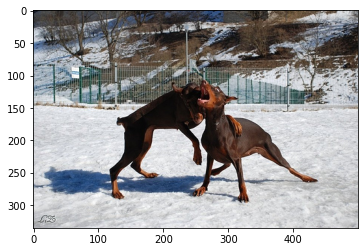

/home/kabilan/Desktop/caption/venv/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/kabilan/Desktop/caption/venv/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/kabilan/Desktop/caption/venv/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A dog be run in a beach .
bleu score:  1.619863157690489e-231


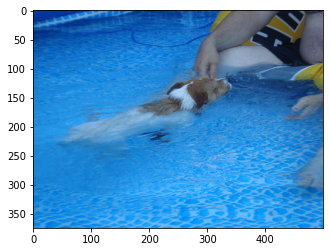

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A dog be be be be be be be be be be be be be be be be be be be be be be be be be a dog
bleu score:  4.6995438382983534e-155


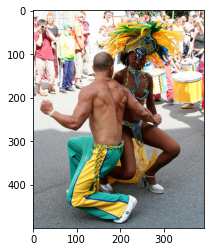

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a shirt in a shirt be be be be be be be be be be be be be be be be be be be a boy .
bleu score:  5.312811551061439e-155


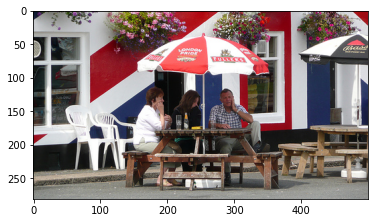

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man be be be be be be be be be be be be be be be be be be be be be be be be be be a dog
bleu score:  1.0244914152188952e-231


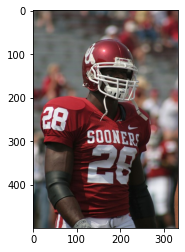

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A player be be be be be be be be be be be be be be be be be be be be be be be be be be be football football football football football football football football football football
bleu score:  1.0309964493856291e-231


In [44]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread(path+ img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [ ]:
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Cider(), "CIDEr")
        ]
def calculate_score(gts,res):

  eval = dict()
  for scorer, method in scorers:
    score, scores = scorer.compute_score(gts, res)
    if type(method) == list:
        for sc, scs, m in zip(score, scores, method):
            eval[m] = sc
    else:
      eval[method] = score
    
  return eval

In [ ]:
gts = {}
can = {}

In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(" ".join(list_caps))
  candidate=greedy_search(photo)
  gts[img_id] = reference
  can[img_id] = " ".join(candidate)
  if(i==5):
    break

NameError: ignored

In [ ]:
print(gts)
print(can)

{'3385593926_d3e9c21170.jpg': ['Dog be in the snow in front of a fence .', 'Dog play on the snow .', 'Two brown dog playful fight in the snow .', 'Two brown dog wrestle in the snow .', 'Two dog play in the snow .'], '2677656448_6b7e7702af.jpg': ['a brown and white dog swim towards some in a pool', 'A dog in a swim pool swim toward sombody we cannot see .', 'A dog swim in a pool near a person .', 'Small dog be paddle through the water in a pool .', 'A small brown and white dog be in a pool .'], '311146855_0b65fdb169.jpg': ['A man and a woman in festive costume dance .', 'A man and a woman with feather on her head dance .', 'A man and a woman wear decorative costume and dance in a crowd of onlooker .', 'one performer wear a feathered headdress dance with another performer in street', 'Two person be dance with drum on the right and a crowd behind them .'], '1258913059_07c613f7ff.jpg': ['A couple of person sit outdoors at a table with an umbrella and talk .', 'Three person be sit at an out

In [ ]:
calculate_score(gts,can)

{'testlen': 2433, 'reflen': 1555, 'guess': [2433, 2332, 2231, 2130], 'correct': [638, 172, 37, 5]}
ratio: 1.5646302250793798


{'Bleu_1': 0.26222770242488197,
 'Bleu_2': 0.13907185109567838,
 'Bleu_3': 0.06845316633881983,
 'Bleu_4': 0.02945728769579055,
 'CIDEr': 0.12006652891990659,
 'METEOR': 0.151633947916401}

## Beam Search Function

In [ ]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

## Predicting Captions on Test Set using Beam Search with k=3

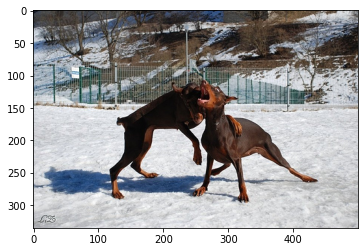

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A doberman jump in the snow .
bleu score:  0.41113361690051975


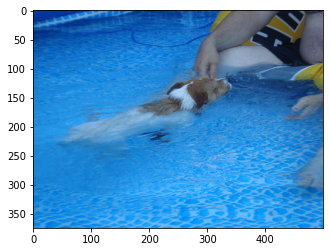

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy be jump into a pool .
bleu score:  0.33584386823726153


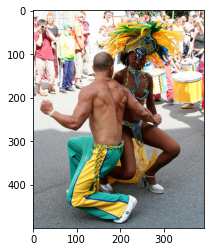

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a street .
bleu score:  0.6076795808137692


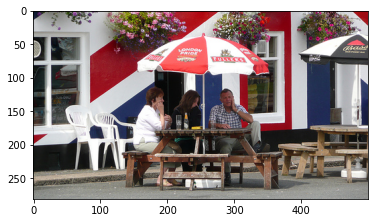

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a pink shirt be jump in a park .
bleu score:  0.7736620501360001


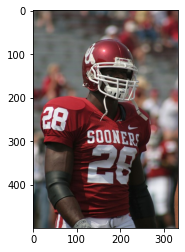

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red helmet .
bleu score:  0.8091067115702212


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [53:42<00:00,  3.22s/it]


Bleu score on Beam search with k=3
Score:  0.4930332459159616
